In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np 
import pandas as pd

from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope

import matplotlib.pyplot as plt
import seaborn as sns

import olympus
from olympus.datasets import Dataset 
from olympus.emulators import Emulator
from olympus.models import BayesNeuralNet

from sklearn.metrics import r2_score, mean_squared_error



## Heptane 100 $\mu$L

In [4]:
dataset = Dataset(kind='liquid_hep_100')
dataset.data.head()

,src_flow,dst_flow,airgap,post_airgap,extra_volume,src_equib,dst_equib,error,stdev
0,53.219769,27.822524,0.197791,0.318073,0.523961,6.968215,13.885812,0.024221,0.018685
1,7.677621,97.245976,0.473208,0.054867,0.699861,24.768714,18.344463,0.110146,0.006918
2,43.201442,59.144573,0.113092,0.113989,0.143209,18.560975,29.187576,0.037039,0.028331
3,6.284396,49.761585,0.374302,0.423494,0.382499,26.660802,5.936635,0.037706,0.009865
4,57.233463,11.578691,0.420385,0.239649,0.087100,14.771930,2.344614,0.083049,0.029477


In [ ]:
dataset.data['']

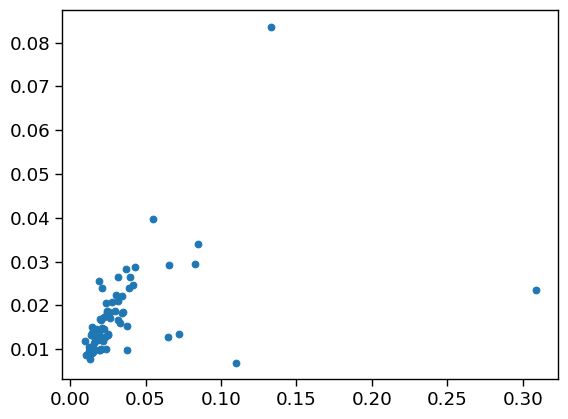

In [9]:
plt.scatter(dataset.data['error'], dataset.data['stdev'])

In [ ]:
df = dataset.

In [2]:
search_space = {
    'batch_size': hp.quniform('batch_size', 10, 50, 10),
    'hidden_act': hp.choice('hidden_act', ['leaky_relu'] ),
    'hidden_depth': hp.quniform('hidden_depth', 2, 5, 1),
    'hidden_nodes': hp.quniform('hidden_nodes', 28, 64, 4),
    'learning_rate': hp.uniform('learning_rate', 1e-5, 5e-3),
    'reg': hp.uniform('reg', 0.001, 0.5)
}

int_params = ['batch_size', 'hidden_depth', 'hidden_nodes']

all_emulators = []
all_losses = []
all_cv_scores = []
all_params = []

In [5]:
def objective(params):
    ''' average performance over cross-validation folds '''
    # build emualtor
    print(f'PARAMS : {params}')
    for param, val in params.items():
        if param in int_params:
            params[param] = int(val)
    model  = BayesNeuralNet(**params, out_act='relu', task='regression')
    emulator = Emulator(
        dataset='liquid_hep_100', model=model, 
        feature_transform='standardize', target_transform='normalize',
    )

    cv_scores = emulator.cross_validate()
    loss = np.mean(cv_scores['validate_rmsd'])
    
    all_losses.append(loss)
    all_cv_scores.append(cv_scores)
    all_params.append(params)
    all_emulators.append(emulator)
    
    return {'loss': loss, 'status': STATUS_OK}

In [ ]:
trials = Trials()

best = fmin(
    fn=objective,
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=5,
    trials=trials
)

print(f"BEST VALUE : {best}")

PARAMS : {'batch_size': 20.0, 'hidden_act': 'leaky_relu', 'hidden_depth': 4.0, 'hidden_nodes': 36.0, 'learning_rate': 0.0013497417585278336, 'reg': 0.32032601218339163}
  0%|                                                                                                      | 0/5 [00:00<?, ?trial/s, best loss=?][INFO] >>> Training model on fold #0...


/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.463          0.255         -0.924          0.144 *
[INFO]             100          0.373          0.167         -0.493          0.133 *
[INFO]             200          0.495          0.150         -0.701          0.122 *
[INFO]             300          0.511          0.147         -1.526          0.160
[INFO]             400          0.621          0.130         -1.775          0.131
[INFO]             500          0.553          0.141         -0.344          0.120 *
[INFO]             600          0.457          0.155         -0.408          0.125
[INFO]             700          0.663          0.122         -0.428          0.127
[INFO]             800          0.663          0.122         -0.440          0.

[INFO]            8700         -0.163          0.228         -0.893          0.139
[INFO]            8800         -0.111          0.222         -0.730          0.128
[INFO]            8900         -0.133          0.225         -1.030          0.148
[INFO]            9000         -0.138          0.225         -0.717          0.127
[INFO]            9100         -0.061          0.217         -0.826          0.135
[INFO]            9200         -0.158          0.227         -1.123          0.153
[INFO]            9300         -0.132          0.225         -1.549          0.176
[INFO]            9400         -0.164          0.228         -0.756          0.136
[INFO]            9500         -0.057          0.217         -0.692          0.126
[INFO]            9600         -0.066          0.218         -0.630          0.121
[INFO]            9700         -0.173          0.229         -0.628          0.121
[INFO]            9800         -0.169          0.228         -1.148          0.154
[INF

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.066          0.196         -0.167          0.126 *
[INFO]             100          0.355          0.148         -0.546          0.167
[INFO]             200          0.356          0.148         -0.657          0.173
[INFO]             300          0.422          0.134         -0.315          0.153
[INFO]             400          0.399          0.137         -0.384          0.154
[INFO]             500          0.534          0.119         -0.208          0.145
[INFO]             600          0.473          0.129         -0.054          0.135
[INFO]             700          0.270          0.160          0.098          0.127
[INFO]             800          0.521          0.121         -0.475          0.162
[I

[INFO]            8600         -0.169          0.207         -0.988          0.166
[INFO]            8700         -0.134          0.204         -1.712          0.203
[INFO]            8800         -0.083          0.201         -1.592          0.197
[INFO]            8900         -0.134          0.204         -1.458          0.191
[INFO]            9000         -0.124          0.203         -0.972          0.165
[INFO]            9100         -0.105          0.202         -2.300          0.228
[INFO]            9200         -0.146          0.205         -0.653          0.146
[INFO]            9300         -0.050          0.198         -1.007          0.167
[INFO]            9400         -0.152          0.205         -1.462          0.191
[INFO]            9500         -0.135          0.204         -1.032          0.169
[INFO]            9600         -0.120          0.203         -1.208          0.178
[INFO]            9700         -0.056          0.199         -0.714          0.150
[INF

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.392          0.319         -1.326          0.586 *
[INFO]             100         -2.321          0.183         -0.277          0.390 *
[INFO]             200         -0.281          0.149         -0.299          0.383 *
[INFO]             300         -0.044          0.127         -0.494          0.420
[INFO]             400         -0.824          0.123         -0.304          0.401
[INFO]             500          0.066          0.124         -0.525          0.394
[INFO]             600          0.227          0.132         -0.402          0.392
[INFO]             700          0.355          0.123         -0.345          0.386
[INFO]             800         -0.017          0.133         -1.846          0.39

[INFO]            8700         -0.680          0.132         -0.556          0.406
[INFO]            8800         -0.702          0.131         -0.689          0.428
[INFO]            8900         -0.671          0.127         -0.557          0.409
[INFO]            9000         -0.618          0.123         -0.759          0.411
[INFO]            9100         -0.739          0.126         -0.657          0.391
[INFO]            9200         -0.650          0.126         -0.539          0.398
[INFO]            9300         -0.585          0.131         -0.935          0.401
[INFO]            9400         -0.509          0.127         -0.924          0.417
[INFO]            9500         -0.699          0.138         -0.815          0.419
[INFO]            9600         -0.500          0.131         -0.742          0.401
[INFO]            9700         -0.512          0.129         -0.769          0.420
[INFO]            9800         -0.694          0.125         -0.634          0.402
[INF

In [ ]:
best_idx = np.argmin(all_losses)
best_emulator = all_emulators[best_idx]
best_emulator

In [ ]:
best_emulator.train(retrain=True)

In [ ]:
emulator = best_emulator
dataset = Dataset(kind='liquid_hep_100')
# make predictions on train and test set
train_params = dataset.train_set_features.to_numpy()
# train_params = emulator.transform_cat_params(train_params)
train_values = dataset.train_set_targets.to_numpy()
test_params = dataset.test_set_features.to_numpy()
# test_params = emulator.transform_cat_params(test_params)

test_values = dataset.test_set_targets.to_numpy()

train_preds = emulator.run(train_params, num_samples=50)
test_preds  = emulator.run(test_params, num_samples=50)

ps_train_r2 = r2_score(train_values[:, 0], train_preds[:, 0])
ps_train_rmsd = np.sqrt(mean_squared_error(train_values[:, 0], train_preds[:, 0]))

ps_test_r2 = r2_score(test_values[:, 0], test_preds[:, 0])
ps_test_rmsd = np.sqrt(mean_squared_error(test_values[:, 0], test_preds[:, 0]))


dl_train_r2 = r2_score(train_values[:, 1], train_preds[:, 1])
dl_train_rmsd = np.sqrt(mean_squared_error(train_values[:, 1], train_preds[:, 1]))

dl_test_r2 = r2_score(test_values[:, 1], test_preds[:, 1])
dl_test_rmsd = np.sqrt(mean_squared_error(test_values[:, 1], test_preds[:, 1]))

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))


# particle diameter distance from 300nm
ax0.scatter(train_values[:, 0], train_preds[:, 0], c='#666B6A', s=30, label='train')
ax0.scatter(test_values[:, 0], test_preds[:, 0], c='#72A276', s=30, label='test')

ax0.set_xscale('log')
ax0.set_yscale('log')

ax0.set_xlabel('true error', fontsize=12)
ax0.set_ylabel('predicted error', fontsize=12)

ax0.legend(loc='lower right', fontsize=12)

textstr = f'train r2 = {round(ps_train_r2, 3)}\ntest r2 = {round(ps_test_r2, 3)}'
props = dict(boxstyle='round', facecolor='#f0eff4', alpha=0.5)
ax0.text(
    0.05, 0.95, textstr, transform=ax0.transAxes, fontsize=14,
    verticalalignment='top', bbox=props,
)

# drug loading capacity
ax1.scatter(train_values[:, 1], train_preds[:, 1], c='#666B6A', s=30, label='train')
ax1.scatter(test_values[:, 1], test_preds[:, 1], c='#72A276', s=30, label='test')

ax1.set_xlabel('true stdev', fontsize=12)
ax1.set_ylabel('predicted stdev', fontsize=12)

textstr = f'train r2 = {round(dl_train_r2, 3)}\ntest r2 = {round(dl_test_r2, 3)}'
props = dict(boxstyle='round', facecolor='#f0eff4', alpha=0.5)
ax1.text(
    0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
    verticalalignment='top', bbox=props,
)

plt.tight_layout()

plt.savefig('hep_100_pairity.png', dpi=400)

## Acetonitrile 100 $\mu$L

In [17]:
search_space = {
    'batch_size': hp.quniform('batch_size', 10, 50, 10),
    'hidden_act': hp.choice('hidden_act', ['leaky_relu'] ),
    'hidden_depth': hp.quniform('hidden_depth', 2, 5, 1),
    'hidden_nodes': hp.quniform('hidden_nodes', 28, 64, 4),
    'learning_rate': hp.uniform('learning_rate', 1e-5, 5e-3),
    'reg': hp.uniform('reg', 0.001, 1.0)
}

int_params = ['batch_size', 'hidden_depth', 'hidden_nodes']

all_emulators = []
all_losses = []
all_cv_scores = []
all_params = []

In [18]:
def objective(params):
    ''' average performance over cross-validation folds '''
    # build emualtor
    print(f'PARAMS : {params}')
    for param, val in params.items():
        if param in int_params:
            params[param] = int(val)
    model  = BayesNeuralNet(**params, out_act='relu')
    emulator = Emulator(
        dataset='liquid_ace_100', model=model, 
        feature_transform='standardize', target_transform='normalize',
    )

    cv_scores = emulator.cross_validate()
    loss = np.mean(cv_scores['validate_rmsd'])
    
    all_losses.append(loss)
    all_cv_scores.append(cv_scores)
    all_params.append(params)
    all_emulators.append(emulator)
    
    return {'loss': loss, 'status': STATUS_OK}

In [19]:
trials = Trials()

best = fmin(
    fn=objective,
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=15,
    trials=trials
)

print(f"BEST VALUE : {best}")

PARAMS : {'batch_size': 30.0, 'hidden_act': 'leaky_relu', 'hidden_depth': 2.0, 'hidden_nodes': 48.0, 'learning_rate': 1.9205890714680185e-05, 'reg': 0.6234112075647469}                    
  0%|                                                                                                                                                | 0/15 [00:00<?, ?trial/s, best loss=?][INFO] >>> Training model on fold #0...


/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.292          0.354         -2.247          0.472 *
[INFO]             100         -1.224          0.349         -2.165          0.466 *
[INFO]             200         -1.135          0.341         -1.935          0.450 *
[INFO]             300         -1.019          0.331         -1.813          0.442 *
[INFO]             400         -0.927          0.323         -1.778          0.439 *
[INFO]             500         -0.872          0.318         -1.631          0.428 *
[INFO]             600         -0.854          0.317         -1.606          0.426 *
[INFO]             700         -0.781          0.310         -1.495          0.418 *
[INFO]             800         -0.722          0.305         -1.472    

[INFO]            8500          0.643          0.140         -0.938          0.365
[INFO]            8600          0.633          0.142         -0.923          0.364
[INFO]            8700          0.624          0.144         -0.857          0.356
[INFO]            8800          0.642          0.141         -0.753          0.347
[INFO]            8900          0.654          0.138         -0.945          0.365
[INFO]            9000          0.644          0.140         -0.958          0.366
[INFO]            9100          0.651          0.139         -1.018          0.372
[INFO]            9200          0.662          0.136         -0.779          0.349
[INFO]            9300          0.661          0.136         -0.877          0.359
[INFO]            9400          0.637          0.141         -0.884          0.360
[INFO]            9500          0.659          0.137         -0.752          0.346
[INFO]            9600          0.652          0.139         -0.843          0.356
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.029          0.370         -1.285          0.257 *
[INFO]             100         -0.927          0.361         -1.069          0.253 *
[INFO]             200         -0.835          0.352         -1.006          0.251 *
[INFO]             300         -0.765          0.345         -1.194          0.254
[INFO]             400         -0.704          0.338         -1.173          0.252
[INFO]             500         -0.633          0.331         -1.250          0.254
[INFO]             600         -0.585          0.326         -1.492          0.256
[INFO]             700         -0.501          0.318         -1.527          0.251
[INFO]             800         -0.381          0.305         -1.515          0.24

[INFO]            8500          0.705          0.142         -1.778          0.226
[INFO]            8600          0.693          0.144         -1.697          0.221
[INFO]            8700          0.706          0.141         -1.498          0.219
[INFO]            8800          0.688          0.146         -1.608          0.226
[INFO]            8900          0.698          0.143         -2.286          0.246
[INFO]            9000          0.727          0.136         -1.521          0.230
[INFO]            9100          0.696          0.144         -1.940          0.240
[INFO]            9200          0.732          0.135         -1.745          0.229
[INFO]            9300          0.695          0.144         -2.049          0.236
[INFO]            9400          0.656          0.153         -1.899          0.237
[INFO]            9500          0.687          0.146         -1.953          0.235
[INFO]            9600          0.712          0.140         -2.137          0.226
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.499          0.412         -2.663          0.678 *
[INFO]             100         -1.478          0.411         -2.626          0.674 *
[INFO]             200         -1.410          0.405         -2.601          0.671 *
[INFO]             300         -1.331          0.399         -2.516          0.665 *
[INFO]             400         -1.216          0.390         -2.400          0.656 *
[INFO]             500         -1.089          0.379         -2.189          0.636 *
[INFO]             600         -0.924          0.365         -2.010          0.624 *
[INFO]             700         -0.743          0.350         -1.978          0.620 *
[INFO]             800         -0.615          0.340         -1.663    

[INFO]            8600          0.616          0.164         -0.870          0.488
[INFO]            8700          0.639          0.159         -0.892          0.492
[INFO]            8800          0.623          0.161         -0.749          0.478
[INFO]            8900          0.645          0.158         -0.778          0.484
[INFO]            9000          0.636          0.157         -0.599          0.456
[INFO]            9100          0.637          0.159         -0.799          0.485
[INFO]            9200          0.623          0.161         -0.687          0.470
[INFO]            9300          0.629          0.158         -0.705          0.473
[INFO]            9400          0.648          0.155         -0.690          0.465
[INFO]            9500          0.653          0.156         -0.869          0.490
[INFO]            9600          0.657          0.155         -0.699          0.472
[INFO]            9700          0.644          0.158         -0.728          0.470
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.429          0.306         -0.462          0.151 *
[INFO]             100         -0.312          0.293         -1.079          0.163
[INFO]             200         -0.245          0.285         -1.602          0.173
[INFO]             300         -0.142          0.274         -1.579          0.170
[INFO]             400         -0.087          0.267         -2.464          0.191
[INFO]             500         -0.038          0.261         -2.124          0.183
[INFO]             600          0.028          0.252         -2.764          0.194
[INFO]             700          0.046          0.250         -3.309          0.202
[INFO]             800          0.114          0.241         -3.049          0.195
[I

[INFO]            8700          0.701          0.141         -1.940          0.177
[INFO]            8800          0.696          0.142         -1.360          0.156
[INFO]            8900          0.724          0.136         -1.197          0.157
[INFO]            9000          0.740          0.131         -1.291          0.164
[INFO]            9100          0.732          0.133         -1.903          0.180
[INFO]            9200          0.737          0.132         -1.906          0.167
[INFO]            9300          0.754          0.128         -1.402          0.161
[INFO]            9400          0.724          0.135         -1.680          0.174
[INFO]            9500          0.746          0.129         -1.792          0.167
[INFO]            9600          0.729          0.134         -1.344          0.170
[INFO]            9700          0.705          0.140         -1.485          0.168
[INFO]            9800          0.743          0.130         -2.002          0.181
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.259          0.394         -1.572          0.263 *
[INFO]             100         -1.118          0.383         -1.539          0.259 *
[INFO]             200         -1.034          0.376         -1.472          0.252 *
[INFO]             300         -0.961          0.370         -1.514          0.256
[INFO]             400         -0.882          0.363         -1.529          0.258
[INFO]             500         -0.820          0.358         -1.467          0.251 *
[INFO]             600         -0.770          0.353         -1.488          0.253
[INFO]             700         -0.706          0.347         -1.501          0.255
[INFO]             800         -0.714          0.348         -1.434          0.

[INFO]           17200          0.729          0.136         -0.636          0.235
[INFO]           17300          0.778          0.124         -0.376          0.218
[INFO]           17400          0.738          0.134         -0.560          0.231
[INFO]           17500          0.753          0.130         -0.430          0.224
[INFO]           17600          0.719          0.139         -0.547          0.226
[INFO]           17700          0.716          0.140         -0.477          0.227
[INFO]           17800          0.715          0.140         -0.388          0.229
[INFO]           17900          0.724          0.137         -0.599          0.229
[INFO]           18000          0.757          0.129         -0.416          0.228
[INFO]           18100          0.741          0.133         -0.470          0.223
[INFO]           18200          0.751          0.131         -0.507          0.233
[INFO]           18300          0.752          0.130         -0.322          0.220
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.874          0.299         -1.296          0.290 *
[INFO]             100          0.765          0.101         -0.662          0.236 *
[INFO]             200          0.772          0.100         -0.549          0.239
[INFO]             300          0.799          0.095         -0.640          0.221 *
[INFO]             400          0.666          0.120         -0.240          0.197 *
[INFO]             500          0.586          0.133         -0.574          0.219
[INFO]             600          0.519          0.142         -0.594          0.222
[INFO]             700          0.625          0.128         -1.241          0.236
[INFO]             800          0.683          0.122         -0.664          0.

[INFO]            8500          0.952          0.046         -6.618          0.443
[INFO]            8600          0.949          0.047         -7.514          0.456
[INFO]            8700          0.948          0.048         -5.656          0.418
[INFO]            8800          0.950          0.047         -7.002          0.445
[INFO]            8900          0.951          0.046         -6.523          0.432
[INFO]            9000          0.954          0.044         -5.947          0.437
[INFO]            9100          0.954          0.044         -8.308          0.482
[INFO]            9200          0.954          0.044         -7.482          0.469
[INFO]            9300          0.943          0.049         -7.798          0.465
[INFO]            9400          0.953          0.046         -7.059          0.459
[INFO]            9500          0.951          0.046         -6.823          0.467
[INFO]            9600          0.955          0.044         -7.381          0.494
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.125          0.366         -1.067          0.706 *
[INFO]             100          0.670          0.146          0.094          0.605 *
[INFO]             200          0.757          0.125          0.134          0.590 *
[INFO]             300          0.755          0.125          0.321          0.514 *
[INFO]             400          0.785          0.117          0.337          0.506 *
[INFO]             500          0.697          0.143          0.224          0.583
[INFO]             600          0.630          0.157         -0.126          0.616
[INFO]             700          0.635          0.150          0.082          0.629
[INFO]             800          0.605          0.158         -0.220          

[INFO]            8500          0.968          0.041         -0.686          0.739
[INFO]            8600          0.972          0.039         -0.706          0.741
[INFO]            8700          0.973          0.038         -0.680          0.739
[INFO]            8800          0.970          0.040         -0.701          0.740
[INFO]            8900          0.968          0.042         -0.688          0.739
[INFO]            9000          0.971          0.039         -0.728          0.742
[INFO]            9100          0.977          0.035         -0.789          0.746
[INFO]            9200          0.976          0.035         -0.719          0.741
[INFO]            9300          0.979          0.033         -0.739          0.742
[INFO]            9400          0.976          0.036         -0.738          0.742
[INFO]            9500          0.975          0.036         -0.727          0.742
[INFO]            9600          0.979          0.033         -0.747          0.743
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.971          0.326         -3.162          0.210 *
[INFO]             100          0.802          0.102         -0.313          0.118 *
[INFO]             200          0.835          0.091          0.133          0.096 *
[INFO]             300          0.723          0.113         -0.268          0.116
[INFO]             400          0.785          0.106         -0.330          0.119
[INFO]             500          0.645          0.126         -0.640          0.132
[INFO]             600          0.641          0.132         -0.687          0.134
[INFO]             700          0.514          0.148         -0.924          0.143
[INFO]             800          0.548          0.146         -0.515          0.12

[INFO]            8600          0.947          0.054         -1.572          0.166
[INFO]            8700          0.959          0.048         -1.448          0.161
[INFO]            8800          0.946          0.054         -1.404          0.160
[INFO]            8900          0.961          0.046         -1.593          0.166
[INFO]            9000          0.965          0.045         -1.523          0.164
[INFO]            9100          0.960          0.047         -1.603          0.167
[INFO]            9200          0.962          0.046         -1.707          0.170
[INFO]            9300          0.965          0.044         -1.638          0.168
[INFO]            9400          0.958          0.048         -1.566          0.165
[INFO]            9500          0.970          0.041         -1.472          0.162
[INFO]            9600          0.965          0.044         -1.775          0.172
[INFO]            9700          0.964          0.045         -1.583          0.166
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.063          0.297         -1.298          0.417 *
[INFO]             100          0.748          0.103         -0.159          0.315 *
[INFO]             200          0.769          0.099         -0.429          0.353
[INFO]             300          0.809          0.089         -0.227          0.337
[INFO]             400          0.640          0.117         -0.086          0.300 *
[INFO]             500          0.723          0.105         -0.488          0.335
[INFO]             600          0.585          0.132         -0.546          0.341
[INFO]             700          0.667          0.116         -0.349          0.327
[INFO]             800          0.536          0.134         -0.499          0.33

[INFO]            8500          0.920          0.054         -1.151          0.436
[INFO]            8600          0.912          0.057         -1.110          0.430
[INFO]            8700          0.914          0.057         -1.086          0.434
[INFO]            8800          0.906          0.059         -1.120          0.434
[INFO]            8900          0.922          0.054         -0.995          0.426
[INFO]            9000          0.923          0.053         -1.121          0.443
[INFO]            9100          0.904          0.059         -1.130          0.440
[INFO]            9200          0.923          0.053         -1.102          0.436
[INFO]            9300          0.914          0.057         -1.041          0.427
[INFO]            9400          0.915          0.056         -1.105          0.435
[INFO]            9500          0.920          0.055         -1.095          0.444
[INFO]            9600          0.909          0.058         -1.054          0.434
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.695          0.286         -1.942          0.137 *
[INFO]             100          0.780          0.102         -2.519          0.107 *
[INFO]             200          0.829          0.091         -5.994          0.174
[INFO]             300          0.807          0.098         -3.208          0.111
[INFO]             400          0.787          0.104         -1.928          0.116
[INFO]             500          0.687          0.125         -5.706          0.172
[INFO]             600          0.663          0.127         -4.380          0.124
[INFO]             700          0.589          0.146         -2.214          0.124
[INFO]             800          0.517          0.156         -6.477          0.182


[INFO]            8600          0.951          0.047         -2.699          0.154
[INFO]            8700          0.953          0.046         -2.849          0.154
[INFO]            8800          0.962          0.042         -7.653          0.214
[INFO]            8900          0.956          0.045         -4.543          0.192
[INFO]            9000          0.956          0.044         -4.015          0.180
[INFO]            9100          0.964          0.040         -7.712          0.197
[INFO]            9200          0.959          0.043         -7.477          0.225
[INFO]            9300          0.942          0.052         -7.941          0.190
[INFO]            9400          0.966          0.039         -6.098          0.211
[INFO]            9500          0.962          0.041         -6.042          0.159
[INFO]            9600          0.959          0.043         -3.092          0.177
[INFO]            9700          0.964          0.040         -6.105          0.197
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.441          0.390         -5.630          0.322 *
[INFO]             100          0.541          0.169         -0.530          0.183 *
[INFO]             200          0.790          0.114         -0.182          0.159 *
[INFO]             300          0.813          0.108          0.043          0.156 *
[INFO]             400          0.792          0.114         -0.034          0.148 *
[INFO]             500          0.842          0.099         -0.257          0.170
[INFO]             600          0.804          0.110         -0.086          0.161
[INFO]             700          0.794          0.113          0.035          0.155
[INFO]             800          0.777          0.118         -0.067          

[INFO]            8500          0.981          0.035         -4.111          0.313
[INFO]            8600          0.980          0.035         -3.784          0.315
[INFO]            8700          0.983          0.033         -3.913          0.315
[INFO]            8800          0.983          0.033         -3.991          0.318
[INFO]            8900          0.987          0.029         -3.760          0.311
[INFO]            9000          0.985          0.031         -4.464          0.327
[INFO]            9100          0.988          0.028         -4.161          0.321
[INFO]            9200          0.988          0.028         -4.199          0.321
[INFO]            9300          0.987          0.029         -4.142          0.323
[INFO]            9400          0.988          0.028         -4.319          0.325
[INFO]            9500          0.987          0.028         -4.544          0.330
[INFO]            9600          0.988          0.027         -4.281          0.322
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.424          0.372         -3.215          0.403 *
[INFO]             100          0.501          0.169         -0.194          0.214 *
[INFO]             200          0.689          0.134         -0.564          0.246
[INFO]             300          0.728          0.125         -0.238          0.218
[INFO]             400          0.737          0.123         -0.431          0.235
[INFO]             500          0.752          0.120         -0.058          0.202 *
[INFO]             600          0.749          0.120         -0.285          0.223
[INFO]             700          0.758          0.118         -0.203          0.215
[INFO]             800          0.768          0.115         -0.047          0.20

[INFO]            8500          0.930          0.063         -0.541          0.243
[INFO]            8600          0.923          0.066         -0.566          0.245
[INFO]            8700          0.934          0.061         -0.535          0.243
[INFO]            8800          0.930          0.063         -0.572          0.246
[INFO]            8900          0.937          0.060         -0.556          0.244
[INFO]            9000          0.930          0.063         -0.501          0.240
[INFO]            9100          0.938          0.059         -0.548          0.244
[INFO]            9200          0.945          0.056         -0.595          0.248
[INFO]            9300          0.941          0.058         -0.612          0.249
[INFO]            9400          0.938          0.059         -0.554          0.244
[INFO]            9500          0.943          0.057         -0.586          0.247
[INFO]            9600          0.947          0.055         -0.538          0.243
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.525          0.361         -1.107          0.361 *
[INFO]             100          0.660          0.139         -1.824          0.404
[INFO]             200          0.704          0.129         -1.580          0.382
[INFO]             300          0.791          0.108         -1.671          0.381
[INFO]             400          0.806          0.103         -1.458          0.361 *
[INFO]             500          0.814          0.101         -1.462          0.361
[INFO]             600          0.776          0.109         -1.558          0.372
[INFO]             700          0.819          0.100         -1.582          0.374
[INFO]             800          0.784          0.109         -1.423          0.358 

[INFO]            8500          0.987          0.026         -1.593          0.376
[INFO]            8600          0.987          0.026         -1.566          0.376
[INFO]            8700          0.988          0.025         -1.562          0.373
[INFO]            8800          0.989          0.024         -1.439          0.363
[INFO]            8900          0.988          0.025         -1.545          0.368
[INFO]            9000          0.990          0.022         -1.562          0.373
[INFO]            9100          0.987          0.026         -1.578          0.371
[INFO]            9200          0.991          0.022         -1.504          0.364
[INFO]            9300          0.992          0.021         -1.636          0.377
[INFO]            9400          0.991          0.021         -1.662          0.384
[INFO]            9500          0.992          0.021         -1.723          0.381
[INFO]            9600          0.993          0.020         -1.593          0.375
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.650          0.398         -1.771          0.255 *
[INFO]             100          0.307          0.203         -0.709          0.201 *
[INFO]             200          0.668          0.140         -0.168          0.175 *
[INFO]             300          0.703          0.133         -0.217          0.178
[INFO]             400          0.734          0.125         -0.127          0.170 *
[INFO]             500          0.740          0.124         -0.378          0.184
[INFO]             600          0.726          0.127         -0.251          0.178
[INFO]             700          0.696          0.134          0.096          0.156 *
[INFO]             800          0.705          0.132         -0.157          

[INFO]            8500          0.811          0.105         -1.682          0.238
[INFO]            8600          0.775          0.115         -1.658          0.234
[INFO]            8700          0.787          0.111         -1.760          0.239
[INFO]            8800          0.778          0.114         -1.656          0.236
[INFO]            8900          0.789          0.111         -1.639          0.235
[INFO]            9000          0.785          0.112         -1.645          0.237
[INFO]            9100          0.773          0.115         -1.649          0.236
[INFO]            9200          0.773          0.115         -1.766          0.242
[INFO]            9300          0.777          0.114         -1.697          0.239
[INFO]            9400          0.788          0.111         -1.723          0.238
[INFO]            9500          0.774          0.115         -1.816          0.242
[INFO]            9600          0.782          0.113         -1.641          0.233
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.661          0.395         -1.100          0.568 *
[INFO]             100          0.559          0.177         -0.533          0.497 *
[INFO]             200          0.582          0.170         -0.495          0.492 *
[INFO]             300          0.645          0.153         -0.497          0.498
[INFO]             400          0.769          0.120         -0.516          0.497
[INFO]             500          0.816          0.106         -0.489          0.492 *
[INFO]             600          0.775          0.116         -0.431          0.479 *
[INFO]             700          0.782          0.116         -0.488          0.494
[INFO]             800          0.783          0.116         -0.353          

[INFO]            8600          0.997          0.013         -0.410          0.479
[INFO]            8700          0.999          0.010         -0.437          0.482
[INFO]            8800          0.999          0.010         -0.386          0.478
[INFO]            8900          0.999          0.010         -0.397          0.477
[INFO]            9000          0.999          0.009         -0.431          0.482
[INFO]            9100          0.999          0.010         -0.451          0.486
[INFO]            9200          0.999          0.009         -0.407          0.479
[INFO]            9300          0.998          0.010         -0.407          0.478
[INFO]            9400          0.999          0.009         -0.394          0.477
[INFO]            9500          0.999          0.009         -0.425          0.482
[INFO]            9600          0.999          0.009         -0.418          0.479
[INFO]            9700          0.999          0.009         -0.396          0.478
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.594          0.268         -1.364          0.275 *
[INFO]             100          0.678          0.123         -0.237          0.247 *
[INFO]             200          0.749          0.110         -0.321          0.259
[INFO]             300          0.723          0.115         -0.602          0.271
[INFO]             400          0.649          0.129         -0.320          0.241 *
[INFO]             500          0.591          0.138         -0.988          0.278
[INFO]             600          0.623          0.135         -0.669          0.255
[INFO]             700          0.700          0.119         -0.844          0.276
[INFO]             800          0.698          0.117         -0.931          0.28

[INFO]            8500          0.988          0.025         -0.402          0.300
[INFO]            8600          0.983          0.029         -0.330          0.297
[INFO]            8700          0.990          0.023         -0.397          0.302
[INFO]            8800          0.989          0.024         -0.420          0.301
[INFO]            8900          0.988          0.025         -0.403          0.301
[INFO]            9000          0.988          0.025         -0.438          0.303
[INFO]            9100          0.989          0.024         -0.412          0.303
[INFO]            9200          0.990          0.023         -0.409          0.302
[INFO]            9300          0.987          0.026         -0.465          0.305
[INFO]            9400          0.989          0.024         -0.423          0.302
[INFO]            9500          0.989          0.024         -0.427          0.303
[INFO]            9600          0.988          0.026         -0.458          0.306
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.488          0.288         -1.196          0.200 *
[INFO]             100          0.770          0.110         -0.085          0.135 *
[INFO]             200          0.782          0.109         -0.095          0.135 *
[INFO]             300          0.616          0.138         -0.156          0.139
[INFO]             400          0.425          0.169         -0.356          0.144
[INFO]             500          0.570          0.148         -0.453          0.155
[INFO]             600          0.769          0.108         -0.323          0.144
[INFO]             700          0.805          0.101         -0.659          0.169
[INFO]             800          0.841          0.087         -0.890          0.18

[INFO]            8600          0.998          0.009         -0.752          0.166
[INFO]            8700          0.999          0.006         -0.863          0.169
[INFO]            8800          0.999          0.008         -0.811          0.167
[INFO]            8900          0.999          0.006         -0.843          0.168
[INFO]            9000          0.999          0.006         -0.878          0.170
[INFO]            9100          1.000          0.004         -0.862          0.169
[INFO]            9200          0.999          0.008         -0.880          0.170
[INFO]            9300          0.997          0.012         -0.859          0.169
[INFO]            9400          0.998          0.009         -0.908          0.171
[INFO]            9500          1.000          0.005         -0.887          0.171
[INFO]            9600          0.997          0.012         -0.838          0.168
[INFO]            9700          0.998          0.009         -0.799          0.167
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.253          0.354         -1.905          0.211 *
[INFO]             100          0.710          0.126         -1.668          0.131 *
[INFO]             200          0.791          0.107         -3.766          0.166
[INFO]             300          0.641          0.133         -1.508          0.140
[INFO]             400          0.667          0.129         -2.860          0.161
[INFO]             500          0.748          0.115         -1.908          0.156
[INFO]             600          0.814          0.097         -3.334          0.161
[INFO]             700          0.833          0.090         -2.195          0.161
[INFO]             800          0.862          0.081         -0.836          0.149


[INFO]            8600          0.998          0.010         -1.092          0.163
[INFO]            8700          0.998          0.010         -1.170          0.164
[INFO]            8800          0.997          0.011         -0.990          0.163
[INFO]            8900          0.997          0.010         -1.084          0.162
[INFO]            9000          0.998          0.009         -1.009          0.162
[INFO]            9100          0.997          0.011         -1.016          0.162
[INFO]            9200          0.998          0.010         -1.135          0.163
[INFO]            9300          0.997          0.010         -0.926          0.161
[INFO]            9400          0.997          0.010         -1.219          0.164
[INFO]            9500          0.997          0.010         -0.997          0.161
[INFO]            9600          0.997          0.012         -1.085          0.162
[INFO]            9700          0.997          0.011         -1.112          0.162
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.545          0.279         -1.243          0.409 *
[INFO]             100          0.651          0.132         -0.354          0.311 *
[INFO]             200          0.758          0.105         -0.644          0.331
[INFO]             300          0.578          0.138         -0.701          0.337
[INFO]             400          0.494          0.150         -0.572          0.329
[INFO]             500          0.478          0.160         -0.614          0.330
[INFO]             600          0.633          0.129         -1.131          0.376
[INFO]             700          0.713          0.115         -1.269          0.386
[INFO]             800          0.720          0.113         -1.033          0.370


[INFO]            8500          0.969          0.043         -0.424          0.313
[INFO]            8600          0.969          0.043         -0.436          0.308
[INFO]            8700          0.971          0.041         -0.450          0.323
[INFO]            8800          0.968          0.044         -0.474          0.318
[INFO]            8900          0.968          0.044         -0.430          0.298 *
[INFO]            9000          0.972          0.041         -0.399          0.298
[INFO]            9100          0.972          0.041         -0.422          0.306
[INFO]            9200          0.970          0.042         -0.428          0.309
[INFO]            9300          0.972          0.041         -0.440          0.323
[INFO]            9400          0.971          0.042         -0.461          0.317
[INFO]            9500          0.971          0.042         -0.463          0.324
[INFO]            9600          0.968          0.044         -0.483          0.331
[I

[INFO]           17400          0.995          0.017         -0.564          0.338
[INFO]           17500          0.996          0.015         -0.473          0.316
[INFO]           17600          0.996          0.016         -0.500          0.304
[INFO]           17700          0.995          0.017         -0.477          0.328
[INFO]           17800          0.996          0.015         -0.520          0.326
[INFO]           17900          0.995          0.017         -0.502          0.322
[INFO]           18000          0.995          0.017         -0.494          0.317
[INFO]           18100          0.985          0.028         -0.494          0.304
[INFO]           18200          0.996          0.015         -0.500          0.320
[INFO]           18300          0.997          0.014         -0.519          0.332
[INFO]           18400          0.996          0.015         -0.506          0.322
[INFO]           18500          0.996          0.015         -0.509          0.314
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.555          0.425         -1.184          0.634 *
[INFO]             100          0.682          0.148          0.101          0.507 *
[INFO]             200          0.810          0.113         -0.111          0.532
[INFO]             300          0.703          0.142         -0.191          0.547
[INFO]             400          0.614          0.167         -0.454          0.580
[INFO]             500          0.778          0.123         -0.409          0.583
[INFO]             600          0.769          0.125         -0.392          0.569
[INFO]             700          0.849          0.101         -0.456          0.589
[INFO]             800          0.777          0.125         -0.482          0.589


[INFO]            8600          0.997          0.013         -0.081          0.331
[INFO]            8700          1.000          0.006         -0.055          0.325
[INFO]            8800          0.999          0.007         -0.045          0.326
[INFO]            8900          0.999          0.007         -0.060          0.324
[INFO]            9000          0.999          0.007         -0.067          0.324
[INFO]            9100          1.000          0.005         -0.058          0.324
[INFO]            9200          1.000          0.004         -0.033          0.322
[INFO]            9300          1.000          0.005         -0.051          0.321
[INFO]            9400          1.000          0.006         -0.024          0.322
[INFO]            9500          0.999          0.006         -0.048          0.322
[INFO]            9600          0.999          0.007         -0.051          0.326
[INFO]            9700          1.000          0.005         -0.044          0.323
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.865          0.311         -4.200          0.193 *
[INFO]             100          0.813          0.096         -1.093          0.123 *
[INFO]             200          0.859          0.081         -1.156          0.139
[INFO]             300          0.848          0.084         -2.170          0.144
[INFO]             400          0.854          0.081         -0.909          0.115 *
[INFO]             500          0.778          0.100         -1.472          0.143
[INFO]             600          0.841          0.086         -1.462          0.129
[INFO]             700          0.873          0.077         -1.483          0.125
[INFO]             800          0.828          0.087         -0.915          0.11

[INFO]            8600          1.000          0.003         -2.629          0.189
[INFO]            8700          1.000          0.001         -2.596          0.187
[INFO]            8800          1.000          0.003         -2.595          0.187
[INFO]            8900          0.999          0.005         -2.657          0.187
[INFO]            9000          1.000          0.002         -2.625          0.187
[INFO]            9100          1.000          0.001         -2.614          0.187
[INFO]            9200          1.000          0.001         -2.577          0.187
[INFO]            9300          1.000          0.003         -2.568          0.187
[INFO]            9400          1.000          0.002         -2.644          0.186
[INFO]            9500          1.000          0.003         -2.656          0.186
[INFO]            9600          1.000          0.002         -2.574          0.186
[INFO]            9700          1.000          0.002         -2.572          0.186
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.510          0.250         -1.479          0.288 *
[INFO]             100          0.680          0.116         -0.654          0.244 *
[INFO]             200          0.878          0.070         -0.337          0.214 *
[INFO]             300          0.854          0.076         -0.248          0.208 *
[INFO]             400          0.874          0.072         -0.095          0.199 *
[INFO]             500          0.750          0.098         -0.090          0.203
[INFO]             600          0.814          0.087          0.084          0.176 *
[INFO]             700          0.840          0.082         -0.035          0.201
[INFO]             800          0.869          0.072          0.108        

[INFO]            8600          1.000          0.003         -0.535          0.224
[INFO]            8700          1.000          0.002         -0.502          0.222
[INFO]            8800          1.000          0.001         -0.505          0.222
[INFO]            8900          1.000          0.002         -0.490          0.221
[INFO]            9000          1.000          0.004         -0.506          0.221
[INFO]            9100          1.000          0.003         -0.504          0.221
[INFO]            9200          1.000          0.002         -0.493          0.221
[INFO]            9300          1.000          0.002         -0.511          0.222
[INFO]            9400          0.999          0.007         -0.472          0.218
[INFO]            9500          1.000          0.003         -0.527          0.222
[INFO]            9600          1.000          0.002         -0.512          0.222
[INFO]            9700          1.000          0.002         -0.503          0.221
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.071          0.233         -0.128          0.527 *
[INFO]             100          0.721          0.120          0.316          0.433 *
[INFO]             200          0.775          0.107          0.404          0.370 *
[INFO]             300          0.810          0.099          0.382          0.408
[INFO]             400          0.775          0.107          0.311          0.427
[INFO]             500          0.798          0.102          0.360          0.339 *
[INFO]             600          0.815          0.097          0.200          0.430
[INFO]             700          0.770          0.107          0.406          0.339
[INFO]             800          0.790          0.102          0.479          0.

[INFO]            8600          1.000          0.003         -0.012          0.361
[INFO]            8700          1.000          0.001         -0.007          0.363
[INFO]            8800          1.000          0.001         -0.016          0.363
[INFO]            8900          1.000          0.002         -0.017          0.363
[INFO]            9000          1.000          0.002         -0.026          0.367
[INFO]            9100          1.000          0.002          0.031          0.358
[INFO]            9200          1.000          0.002         -0.006          0.366
[INFO]            9300          1.000          0.002          0.013          0.362
[INFO]            9400          0.998          0.009          0.007          0.353
[INFO]            9500          1.000          0.002          0.009          0.368
[INFO]            9600          1.000          0.001          0.003          0.368
[INFO]            9700          1.000          0.001          0.009          0.365
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.699          0.291         -4.060          0.170 *
[INFO]             100          0.822          0.096         -4.072          0.178
[INFO]             200          0.888          0.077         -8.125          0.241
[INFO]             300          0.842          0.089         -4.125          0.179
[INFO]             400          0.841          0.088         -3.582          0.169 *
[INFO]             500          0.868          0.083         -4.286          0.182
[INFO]             600          0.879          0.078         -2.426          0.147 *
[INFO]             700          0.880          0.077         -4.856          0.192
[INFO]             800          0.900          0.072         -4.104          0.18

[INFO]            8600          1.000          0.001         -4.172          0.179
[INFO]            8700          1.000          0.002         -4.181          0.179
[INFO]            8800          1.000          0.001         -4.242          0.180
[INFO]            8900          1.000          0.003         -4.085          0.177
[INFO]            9000          1.000          0.002         -4.194          0.179
[INFO]            9100          1.000          0.001         -4.133          0.178
[INFO]            9200          1.000          0.002         -4.138          0.178
[INFO]            9300          1.000          0.003         -4.377          0.183
[INFO]            9400          1.000          0.004         -4.169          0.179
[INFO]            9500          1.000          0.002         -4.346          0.182
[INFO]            9600          1.000          0.002         -4.252          0.180
[INFO]            9700          1.000          0.002         -4.219          0.180
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.728          0.316         -1.077          0.383 *
[INFO]             100          0.823          0.108         -0.297          0.325 *
[INFO]             200          0.831          0.105         -0.356          0.323 *
[INFO]             300          0.841          0.101         -0.249          0.318 *
[INFO]             400          0.865          0.092         -0.478          0.343
[INFO]             500          0.813          0.099         -0.921          0.368
[INFO]             600          0.841          0.098         -0.765          0.364
[INFO]             700          0.798          0.105         -0.855          0.358
[INFO]             800          0.792          0.099         -0.900          0.

[INFO]            8600          0.999          0.009         -1.621          0.393
[INFO]            8700          1.000          0.002         -1.566          0.392
[INFO]            8800          1.000          0.001         -1.554          0.392
[INFO]            8900          1.000          0.002         -1.551          0.392
[INFO]            9000          1.000          0.002         -1.554          0.392
[INFO]            9100          1.000          0.001         -1.561          0.392
[INFO]            9200          1.000          0.003         -1.555          0.392
[INFO]            9300          1.000          0.003         -1.554          0.392
[INFO]            9400          1.000          0.003         -1.531          0.390
[INFO]            9500          1.000          0.002         -1.553          0.392
[INFO]            9600          1.000          0.003         -1.540          0.391
[INFO]            9700          1.000          0.005         -1.586          0.393
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.452          0.369         -2.057          0.595 *
[INFO]             100          0.712          0.128         -0.705          0.407 *
[INFO]             200          0.759          0.118         -0.639          0.399 *
[INFO]             300          0.709          0.127         -0.580          0.412
[INFO]             400          0.820          0.100         -0.479          0.397 *
[INFO]             500          0.791          0.106         -0.432          0.379 *
[INFO]             600          0.795          0.103         -0.714          0.403
[INFO]             700          0.855          0.088         -0.654          0.414
[INFO]             800          0.824          0.093         -0.639          

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.354          0.263         -0.633          0.235 *
[INFO]             100          0.844          0.093         -0.273          0.195 *
[INFO]             200          0.868          0.084         -0.348          0.200
[INFO]             300          0.888          0.078         -0.059          0.190 *
[INFO]             400          0.862          0.086         -0.010          0.186 *
[INFO]             500          0.838          0.094         -0.194          0.184 *
[INFO]             600          0.864          0.086         -0.228          0.185
[INFO]             700          0.890          0.077         -0.221          0.198
[INFO]             800          0.907          0.071         -0.511          

[INFO]            8700          1.000          0.004         -0.707          0.238
[INFO]            8800          1.000          0.005         -0.706          0.238
[INFO]            8900          1.000          0.005         -0.696          0.237
[INFO]            9000          1.000          0.004         -0.690          0.236
[INFO]            9100          0.999          0.006         -0.694          0.236
[INFO]            9200          1.000          0.004         -0.694          0.237
[INFO]            9300          1.000          0.004         -0.699          0.237
[INFO]            9400          0.999          0.006         -0.681          0.236
[INFO]            9500          0.999          0.006         -0.653          0.233
[INFO]            9600          1.000          0.004         -0.691          0.236
[INFO]            9700          0.999          0.006         -0.682          0.235
[INFO]            9800          0.998          0.009         -0.686          0.236
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.421          0.288         -2.334          0.128 *
[INFO]             100          0.826          0.102        -18.534          0.287
[INFO]             200          0.838          0.098        -12.377          0.250
[INFO]             300          0.809          0.108        -19.399          0.308
[INFO]             400          0.824          0.099        -10.587          0.232
[INFO]             500          0.813          0.108         -9.606          0.219
[INFO]             600          0.838          0.098        -13.418          0.262
[INFO]             700          0.858          0.089        -14.441          0.276
[INFO]             800          0.887          0.079        -17.061          0.306
[I

[INFO]            8700          0.999          0.009        -27.746          0.380
[INFO]            8800          1.000          0.001        -30.096          0.392
[INFO]            8900          1.000          0.001        -30.158          0.392
[INFO]            9000          1.000          0.001        -30.014          0.391
[INFO]            9100          1.000          0.001        -30.041          0.392
[INFO]            9200          1.000          0.002        -30.168          0.392
[INFO]            9300          1.000          0.002        -29.557          0.389
[INFO]            9400          1.000          0.003        -29.372          0.388
[INFO]            9500          1.000          0.001        -29.823          0.390
[INFO]            9600          1.000          0.002        -29.954          0.391
[INFO]            9700          1.000          0.002        -30.049          0.391
[INFO]            9800          1.000          0.004        -30.605          0.394
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.176          0.381         -1.628          0.594 *
[INFO]             100          0.666          0.149         -2.484          0.515 *
[INFO]             200          0.774          0.123         -4.924          0.507 *
[INFO]             300          0.784          0.120         -1.836          0.350 *
[INFO]             400          0.767          0.125         -1.730          0.311 *
[INFO]             500          0.794          0.117         -1.193          0.271 *
[INFO]             600          0.874          0.092         -1.817          0.290
[INFO]             700          0.890          0.086         -0.703          0.226 *
[INFO]             800          0.889          0.086         -1.098      

[INFO]            8600          0.999          0.008         -6.317          0.521
[INFO]            8700          0.999          0.009         -6.408          0.521
[INFO]            8800          0.999          0.008         -6.029          0.513
[INFO]            8900          0.999          0.007         -6.128          0.517
[INFO]            9000          0.999          0.007         -6.057          0.515
[INFO]            9100          0.999          0.008         -6.125          0.516
[INFO]            9200          0.999          0.007         -6.078          0.515
[INFO]            9300          0.999          0.008         -6.086          0.514
[INFO]            9400          0.999          0.009         -6.078          0.515
[INFO]            9500          0.999          0.008         -6.052          0.516
[INFO]            9600          0.999          0.007         -5.953          0.513
[INFO]            9700          0.999          0.007         -5.916          0.512
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.415          0.263         -0.542          0.148 *
[INFO]             100          0.790          0.106         -5.847          0.216
[INFO]             200          0.837          0.090         -2.899          0.209
[INFO]             300          0.820          0.096         -1.633          0.192
[INFO]             400          0.829          0.093         -2.622          0.219
[INFO]             500          0.789          0.105         -1.348          0.178
[INFO]             600          0.873          0.081         -2.810          0.198
[INFO]             700          0.883          0.078         -2.373          0.208
[INFO]             800          0.901          0.070         -1.565          0.185
[I

[INFO]            8700          1.000          0.002         -1.382          0.230
[INFO]            8800          1.000          0.002         -1.383          0.229
[INFO]            8900          0.999          0.007         -1.474          0.229
[INFO]            9000          1.000          0.001         -1.405          0.230
[INFO]            9100          1.000          0.001         -1.424          0.230
[INFO]            9200          1.000          0.002         -1.413          0.231
[INFO]            9300          1.000          0.002         -1.394          0.231
[INFO]            9400          1.000          0.003         -1.420          0.230
[INFO]            9500          1.000          0.004         -1.429          0.232
[INFO]            9600          1.000          0.004         -1.411          0.231
[INFO]            9700          1.000          0.001         -1.418          0.231
[INFO]            9800          1.000          0.003         -1.425          0.230
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.907          0.306         -8.831          0.215 *
[INFO]             100          0.606          0.138         -1.127          0.103 *
[INFO]             200          0.757          0.109         -1.840          0.116
[INFO]             300          0.715          0.117         -1.410          0.109
[INFO]             400          0.785          0.102         -1.045          0.101 *
[INFO]             500          0.761          0.109         -1.472          0.108
[INFO]             600          0.763          0.106         -0.706          0.093 *
[INFO]             700          0.624          0.131         -1.367          0.107
[INFO]             800          0.712          0.118         -1.424          0.

[INFO]            8600         -0.111          0.219         -6.038          0.186
[INFO]            8700         -0.064          0.213         -5.845          0.181
[INFO]            8800         -0.057          0.212         -6.699          0.193
[INFO]            8900         -0.039          0.210         -6.000          0.185
[INFO]            9000         -0.370          0.251         -7.170          0.198
[INFO]            9100         -0.127          0.221         -8.296          0.210
[INFO]            9200         -0.053          0.212         -6.506          0.190
[INFO]            9300          0.066          0.200         -7.443          0.201
[INFO]            9400          0.001          0.205         -5.482          0.176
[INFO]            9500          0.030          0.203         -6.158          0.185
[INFO]            9600         -0.018          0.207         -5.805          0.183
[INFO]            9700          0.074          0.201         -4.748          0.171
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.629          0.355         -1.318          0.623 *
[INFO]             100         -0.319          0.248         -0.165          0.590 *
[INFO]             200          0.581          0.141         -0.062          0.526 *
[INFO]             300          0.621          0.134         -0.100          0.530
[INFO]             400          0.654          0.128          0.159          0.475 *
[INFO]             500          0.571          0.143          0.241          0.462 *
[INFO]             600          0.656          0.128          0.204          0.477
[INFO]             700          0.473          0.158          0.055          0.502
[INFO]             800          0.537          0.148          0.263          

[INFO]            8600          0.526          0.150         -0.620          0.588
[INFO]            8700          0.519          0.151         -0.632          0.592
[INFO]            8800          0.521          0.151         -0.684          0.593
[INFO]            8900          0.505          0.153         -0.649          0.598
[INFO]            9000          0.511          0.152         -0.638          0.586
[INFO]            9100          0.524          0.150         -0.661          0.594
[INFO]            9200          0.496          0.155         -0.636          0.588
[INFO]            9300          0.452          0.161         -0.646          0.587
[INFO]            9400          0.479          0.157         -0.618          0.586
[INFO]            9500          0.518          0.151         -0.697          0.589
[INFO]            9600          0.480          0.157         -0.638          0.590
[INFO]            9700          0.513          0.152         -0.716          0.590
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.683          0.286         -0.516          0.587 *
[INFO]             100          0.666          0.126         -0.160          0.459 *
[INFO]             200          0.755          0.107         -0.106          0.426 *
[INFO]             300          0.807          0.095          0.090          0.417 *
[INFO]             400          0.829          0.090          0.067          0.418
[INFO]             500          0.797          0.096         -0.023          0.429
[INFO]             600          0.790          0.097         -0.024          0.436
[INFO]             700          0.781          0.100          0.072          0.430
[INFO]             800          0.748          0.109         -0.089          0.

[INFO]            8600         -0.081          0.208         -1.033          0.563
[INFO]            8700          0.070          0.195         -0.959          0.544
[INFO]            8800          0.007          0.199         -0.897          0.527
[INFO]            8900         -0.017          0.201         -0.899          0.527
[INFO]            9000         -0.011          0.200         -0.982          0.550
[INFO]            9100          0.125          0.187         -0.959          0.544
[INFO]            9200          0.183          0.181         -0.936          0.539
[INFO]            9300          0.083          0.191         -0.920          0.535
[INFO]            9400         -0.018          0.201         -0.892          0.525
[INFO]            9500         -0.005          0.199         -0.900          0.527
[INFO]            9600         -0.032          0.203         -0.974          0.548
[INFO]            9700          0.185          0.181         -0.967          0.546
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.598          0.268         -1.342          0.189 *
[INFO]             100          0.512          0.116         -2.269          0.188 *
[INFO]             200          0.707          0.092         -0.627          0.128 *
[INFO]             300          0.712          0.090         -0.447          0.124 *
[INFO]             400          0.719          0.089         -0.411          0.119 *
[INFO]             500          0.781          0.081         -0.586          0.129
[INFO]             600          0.699          0.094         -0.829          0.134
[INFO]             700          0.703          0.091         -0.646          0.134
[INFO]             800          0.484          0.125         -0.037          

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.343          0.350         -2.339          0.212 *
[INFO]             100          0.431          0.174         -0.178          0.125 *
[INFO]             200          0.793          0.103          0.047          0.101 *
[INFO]             300          0.825          0.095          0.114          0.105
[INFO]             400          0.856          0.086         -0.137          0.109
[INFO]             500          0.843          0.091          0.113          0.102
[INFO]             600          0.826          0.095         -0.064          0.115
[INFO]             700          0.675          0.134          0.139          0.108
[INFO]             800          0.808          0.101         -0.136          0.11

[INFO]            8500          0.136          0.221         -1.032          0.158
[INFO]            8600          0.230          0.209         -1.463          0.163
[INFO]            8700          0.048          0.232         -1.274          0.151
[INFO]            8800          0.115          0.225         -1.100          0.157
[INFO]            8900          0.188          0.214         -1.735          0.178
[INFO]            9000          0.077          0.230         -1.525          0.166
[INFO]            9100          0.057          0.232         -1.383          0.162
[INFO]            9200          0.057          0.232         -1.137          0.160
[INFO]            9300          0.045          0.232         -1.655          0.173
[INFO]            9400          0.098          0.227         -1.646          0.173
[INFO]            9500          0.129          0.223         -1.446          0.162
[INFO]            9600         -0.002          0.238         -1.491          0.164
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.126          0.336         -2.694          0.185 *
[INFO]             100          0.783          0.109         -0.653          0.103 *
[INFO]             200          0.859          0.087         -1.619          0.134
[INFO]             300          0.865          0.084         -1.373          0.121
[INFO]             400          0.850          0.088         -1.560          0.138
[INFO]             500          0.893          0.073         -2.054          0.157
[INFO]             600          0.877          0.077         -1.525          0.135
[INFO]             700          0.896          0.072         -2.098          0.160
[INFO]             800          0.893          0.073         -1.410          0.132


[INFO]            8600          1.000          0.003         -4.991          0.211
[INFO]            8700          1.000          0.001         -5.033          0.212
[INFO]            8800          1.000          0.002         -5.001          0.211
[INFO]            8900          1.000          0.002         -5.064          0.213
[INFO]            9000          1.000          0.003         -5.046          0.211
[INFO]            9100          1.000          0.002         -5.039          0.211
[INFO]            9200          1.000          0.003         -5.087          0.212
[INFO]            9300          1.000          0.002         -5.083          0.212
[INFO]            9400          1.000          0.002         -5.033          0.213
[INFO]            9500          1.000          0.002         -5.128          0.213
[INFO]            9600          1.000          0.002         -5.058          0.212
[INFO]            9700          1.000          0.003         -5.015          0.211
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.708          0.303         -1.117          0.392 *
[INFO]             100          0.824          0.099         -0.271          0.339 *
[INFO]             200          0.841          0.093         -0.171          0.338 *
[INFO]             300          0.876          0.083         -0.175          0.333 *
[INFO]             400          0.894          0.076         -0.128          0.338
[INFO]             500          0.898          0.076         -0.067          0.341
[INFO]             600          0.919          0.067         -0.242          0.357
[INFO]             700          0.888          0.077         -0.303          0.359
[INFO]             800          0.904          0.072         -0.252          0.

[INFO]            8600          0.999          0.006         -0.048          0.353
[INFO]            8700          1.000          0.002         -0.023          0.353
[INFO]            8800          1.000          0.002         -0.024          0.353
[INFO]            8900          1.000          0.004         -0.031          0.354
[INFO]            9000          1.000          0.002         -0.027          0.354
[INFO]            9100          1.000          0.002         -0.027          0.353
[INFO]            9200          1.000          0.003         -0.026          0.354
[INFO]            9300          1.000          0.002         -0.033          0.354
[INFO]            9400          1.000          0.002         -0.033          0.354
[INFO]            9500          1.000          0.002         -0.024          0.353
[INFO]            9600          1.000          0.002         -0.025          0.353
[INFO]            9700          1.000          0.002         -0.016          0.353
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.327          0.383         -1.431          0.738 *
[INFO]             100          0.682          0.142          0.048          0.609 *
[INFO]             200          0.762          0.121         -0.130          0.616
[INFO]             300          0.803          0.111         -0.115          0.607 *
[INFO]             400          0.840          0.098         -0.010          0.590 *
[INFO]             500          0.875          0.086          0.098          0.561 *
[INFO]             600          0.886          0.086         -0.006          0.596
[INFO]             700          0.860          0.090         -0.086          0.601
[INFO]             800          0.891          0.081          0.061          

[INFO]            8400          1.000          0.003          0.231          0.530
[INFO]            8500          1.000          0.003          0.231          0.530
[INFO]            8600          1.000          0.003          0.234          0.529
[INFO]            8700          1.000          0.005          0.230          0.531
[INFO]            8800          1.000          0.003          0.240          0.526
[INFO]            8900          1.000          0.002          0.232          0.530
[INFO]            9000          1.000          0.003          0.233          0.528
[INFO]            9100          0.999          0.006          0.238          0.528
[INFO]            9200          1.000          0.003          0.238          0.528
[INFO]            9300          1.000          0.004          0.230          0.531
[INFO]            9400          1.000          0.004          0.236          0.530
[INFO]            9500          1.000          0.003          0.235          0.530
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.491          0.263         -0.879          0.266 *
[INFO]             100          0.808          0.092         -0.075          0.205 *
[INFO]             200          0.845          0.084         -0.236          0.224
[INFO]             300          0.904          0.066         -0.485          0.249
[INFO]             400          0.895          0.068         -0.364          0.227
[INFO]             500          0.892          0.070         -0.460          0.241
[INFO]             600          0.896          0.069         -0.174          0.212
[INFO]             700          0.879          0.073         -0.225          0.226
[INFO]             800          0.884          0.073         -0.055          0.206


[INFO]            8600          1.000          0.004         -0.850          0.276
[INFO]            8700          1.000          0.002         -0.845          0.276
[INFO]            8800          1.000          0.003         -0.820          0.274
[INFO]            8900          1.000          0.003         -0.837          0.276
[INFO]            9000          1.000          0.004         -0.822          0.274
[INFO]            9100          1.000          0.003         -0.859          0.277
[INFO]            9200          1.000          0.003         -0.857          0.275
[INFO]            9300          1.000          0.002         -0.824          0.275
[INFO]            9400          1.000          0.002         -0.849          0.276
[INFO]            9500          1.000          0.002         -0.791          0.272
[INFO]            9600          1.000          0.003         -0.834          0.275
[INFO]            9700          1.000          0.004         -0.835          0.275
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.846          0.294         -2.339          0.245 *
[INFO]             100          0.780          0.106         -0.142          0.142 *
[INFO]             200          0.843          0.091         -0.091          0.139 *
[INFO]             300          0.849          0.090         -0.009          0.133 *
[INFO]             400          0.873          0.083         -0.334          0.154
[INFO]             500          0.877          0.079          0.027          0.131 *
[INFO]             600          0.908          0.069         -0.063          0.136
[INFO]             700          0.906          0.070         -0.211          0.146
[INFO]             800          0.897          0.072         -0.124          

[INFO]            8600          1.000          0.004         -1.160          0.198
[INFO]            8700          1.000          0.003         -1.178          0.198
[INFO]            8800          1.000          0.004         -1.172          0.198
[INFO]            8900          1.000          0.003         -1.209          0.200
[INFO]            9000          1.000          0.003         -1.193          0.199
[INFO]            9100          1.000          0.003         -1.146          0.197
[INFO]            9200          1.000          0.003         -1.154          0.197
[INFO]            9300          1.000          0.004         -1.180          0.199
[INFO]            9400          1.000          0.004         -1.130          0.196
[INFO]            9500          1.000          0.003         -1.170          0.198
[INFO]            9600          1.000          0.003         -1.162          0.198
[INFO]            9700          1.000          0.003         -1.172          0.198
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.368          0.278         -0.117          0.286 *
[INFO]             100          0.651          0.141         -2.009          0.457
[INFO]             200          0.715          0.127         -2.432          0.489
[INFO]             300          0.768          0.114         -2.305          0.474
[INFO]             400          0.717          0.125         -1.255          0.392
[INFO]             500          0.780          0.110         -0.767          0.352
[INFO]             600          0.767          0.113         -1.099          0.386
[INFO]             700          0.787          0.107         -0.808          0.359
[INFO]             800          0.752          0.113         -1.502          0.409
[I

[INFO]            8600          1.000          0.002         -1.210          0.395
[INFO]            8700          1.000          0.002         -1.227          0.396
[INFO]            8800          1.000          0.002         -1.215          0.395
[INFO]            8900          1.000          0.003         -1.195          0.393
[INFO]            9000          1.000          0.003         -1.211          0.395
[INFO]            9100          1.000          0.002         -1.209          0.395
[INFO]            9200          0.999          0.006         -1.160          0.391
[INFO]            9300          1.000          0.002         -1.215          0.395
[INFO]            9400          1.000          0.002         -1.225          0.396
[INFO]            9500          1.000          0.002         -1.184          0.393
[INFO]            9600          1.000          0.003         -1.215          0.395
[INFO]            9700          0.999          0.007         -1.179          0.392
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.672          0.319         -0.407          0.155 *
[INFO]             100          0.699          0.136         -4.767          0.293
[INFO]             200          0.786          0.114         -5.968          0.332
[INFO]             300          0.778          0.116         -3.688          0.260
[INFO]             400          0.748          0.124         -5.320          0.305
[INFO]             500          0.804          0.109         -5.029          0.299
[INFO]             600          0.772          0.119         -6.593          0.339
[INFO]             700          0.788          0.113         -4.604          0.294
[INFO]             800          0.772          0.117         -8.223          0.370
[I

[INFO]            8600          1.000          0.004         -8.903          0.370
[INFO]            8700          1.000          0.004         -8.966          0.371
[INFO]            8800          1.000          0.004         -8.905          0.370
[INFO]            8900          1.000          0.005         -8.860          0.370
[INFO]            9000          1.000          0.004         -9.040          0.372
[INFO]            9100          1.000          0.004         -9.052          0.372
[INFO]            9200          1.000          0.004         -8.951          0.371
[INFO]            9300          1.000          0.004         -8.974          0.371
[INFO]            9400          0.999          0.006         -8.777          0.368
[INFO]            9500          1.000          0.004         -8.964          0.371
[INFO]            9600          1.000          0.004         -8.874          0.369
[INFO]            9700          1.000          0.005         -8.935          0.371
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.612          0.304         -0.504          0.223 *
[INFO]             100          0.716          0.129         -0.405          0.216 *
[INFO]             200          0.819          0.103         -0.327          0.214 *
[INFO]             300          0.871          0.087         -0.607          0.225
[INFO]             400          0.865          0.088         -0.783          0.246
[INFO]             500          0.788          0.111         -1.276          0.259
[INFO]             600          0.852          0.093         -0.620          0.225
[INFO]             700          0.849          0.094         -0.843          0.238
[INFO]             800          0.864          0.089         -0.828          0.23

[INFO]            8600          0.999          0.006         -1.557          0.286
[INFO]            8700          1.000          0.005         -1.550          0.285
[INFO]            8800          1.000          0.005         -1.567          0.286
[INFO]            8900          1.000          0.005         -1.559          0.286
[INFO]            9000          1.000          0.005         -1.549          0.285
[INFO]            9100          1.000          0.005         -1.541          0.284
[INFO]            9200          0.999          0.005         -1.549          0.285
[INFO]            9300          1.000          0.005         -1.522          0.284
[INFO]            9400          1.000          0.004         -1.508          0.283
[INFO]            9500          1.000          0.004         -1.525          0.284
[INFO]            9600          1.000          0.004         -1.528          0.284
[INFO]            9700          0.999          0.006         -1.529          0.284
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.412          0.283         -1.009          0.455 *
[INFO]             100          0.729          0.129         -1.103          0.474
[INFO]             200          0.811          0.107         -1.175          0.489
[INFO]             300          0.818          0.103         -1.240          0.499
[INFO]             400          0.797          0.107         -0.851          0.463
[INFO]             500          0.847          0.093         -0.945          0.473
[INFO]             600          0.827          0.099         -1.214          0.498
[INFO]             700          0.852          0.090         -1.271          0.505
[INFO]             800          0.866          0.085         -1.188          0.491
[I

[INFO]            8600          1.000          0.001         -1.443          0.513
[INFO]            8700          1.000          0.002         -1.437          0.513
[INFO]            8800          1.000          0.002         -1.435          0.513
[INFO]            8900          1.000          0.002         -1.442          0.513
[INFO]            9000          1.000          0.002         -1.451          0.514
[INFO]            9100          1.000          0.002         -1.448          0.514
[INFO]            9200          1.000          0.001         -1.445          0.514
[INFO]            9300          1.000          0.002         -1.443          0.514
[INFO]            9400          1.000          0.001         -1.436          0.513
[INFO]            9500          1.000          0.002         -1.447          0.514
[INFO]            9600          1.000          0.001         -1.439          0.513
[INFO]            9700          1.000          0.002         -1.442          0.513
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.968          0.328         -1.934          0.344 *
[INFO]             100          0.664          0.138         -0.288          0.229 *
[INFO]             200          0.794          0.108         -0.010          0.202 *
[INFO]             300          0.825          0.099          0.093          0.192 *
[INFO]             400          0.834          0.097          0.069          0.195
[INFO]             500          0.779          0.111         -0.031          0.204
[INFO]             600          0.783          0.111         -0.025          0.204
[INFO]             700          0.805          0.105          0.069          0.195
[INFO]             800          0.803          0.106         -0.022          0.

[INFO]            8600          0.999          0.006         -0.433          0.240
[INFO]            8700          1.000          0.003         -0.434          0.240
[INFO]            8800          1.000          0.003         -0.438          0.241
[INFO]            8900          1.000          0.002         -0.428          0.240
[INFO]            9000          1.000          0.002         -0.442          0.241
[INFO]            9100          1.000          0.002         -0.447          0.242
[INFO]            9200          1.000          0.003         -0.442          0.241
[INFO]            9300          1.000          0.002         -0.450          0.242
[INFO]            9400          1.000          0.002         -0.459          0.243
[INFO]            9500          0.999          0.006         -0.434          0.240
[INFO]            9600          1.000          0.001         -0.426          0.240
[INFO]            9700          1.000          0.003         -0.419          0.239
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.794          0.323         -1.218          0.264 *
[INFO]             100          0.403          0.181         -0.264          0.162 *
[INFO]             200          0.556          0.157          0.254          0.138 *
[INFO]             300          0.674          0.135         -0.106          0.162
[INFO]             400          0.778          0.112          0.163          0.145
[INFO]             500          0.794          0.107          0.033          0.157
[INFO]             600          0.850          0.090         -0.055          0.162
[INFO]             700          0.870          0.084         -0.025          0.162
[INFO]             800          0.884          0.079          0.039          0.15

[INFO]            8600          1.000          0.005          0.180          0.152
[INFO]            8700          1.000          0.005          0.189          0.154
[INFO]            8800          1.000          0.003          0.221          0.152
[INFO]            8900          1.000          0.004          0.216          0.151
[INFO]            9000          1.000          0.004          0.209          0.151
[INFO]            9100          1.000          0.003          0.216          0.151
[INFO]            9200          1.000          0.004          0.199          0.153
[INFO]            9300          1.000          0.005          0.194          0.153
[INFO]            9400          1.000          0.003          0.226          0.151
[INFO]            9500          1.000          0.003          0.238          0.150
[INFO]            9600          1.000          0.004          0.218          0.151
[INFO]            9700          1.000          0.004          0.199          0.151
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.257          0.325         -1.000          0.376 *
[INFO]             100          0.239          0.185         -0.324          0.296 *
[INFO]             200          0.590          0.138         -0.619          0.304
[INFO]             300          0.711          0.116         -0.794          0.311
[INFO]             400          0.761          0.106         -0.726          0.304
[INFO]             500          0.820          0.093         -0.649          0.301
[INFO]             600          0.836          0.089         -0.767          0.309
[INFO]             700          0.864          0.081         -0.612          0.302
[INFO]             800          0.879          0.077         -0.703          0.305


[INFO]            8600          0.999          0.005         -0.749          0.316
[INFO]            8700          0.999          0.006         -0.747          0.316
[INFO]            8800          0.999          0.006         -0.722          0.315
[INFO]            8900          0.999          0.006         -0.754          0.318
[INFO]            9000          0.999          0.007         -0.764          0.316
[INFO]            9100          0.999          0.005         -0.740          0.316
[INFO]            9200          0.999          0.006         -0.756          0.317
[INFO]            9300          0.999          0.005         -0.747          0.317
[INFO]            9400          0.999          0.005         -0.733          0.316
[INFO]            9500          0.999          0.005         -0.733          0.315
[INFO]            9600          0.999          0.005         -0.752          0.317
[INFO]            9700          0.999          0.005         -0.732          0.316
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.955          0.338         -1.834          0.270 *
[INFO]             100          0.402          0.187         -1.610          0.249 *
[INFO]             200          0.534          0.167         -1.678          0.275
[INFO]             300          0.618          0.153         -1.763          0.270
[INFO]             400          0.724          0.130         -1.490          0.254
[INFO]             500          0.800          0.110         -0.925          0.241 *
[INFO]             600          0.819          0.105         -1.072          0.252
[INFO]             700          0.858          0.092         -1.219          0.262
[INFO]             800          0.875          0.087         -1.545          0.28

[INFO]            8600          1.000          0.005         -1.394          0.262
[INFO]            8700          1.000          0.004         -1.388          0.261
[INFO]            8800          0.999          0.006         -1.391          0.262
[INFO]            8900          1.000          0.005         -1.424          0.264
[INFO]            9000          1.000          0.005         -1.384          0.262
[INFO]            9100          1.000          0.004         -1.406          0.263
[INFO]            9200          1.000          0.005         -1.431          0.264
[INFO]            9300          0.999          0.006         -1.364          0.260
[INFO]            9400          1.000          0.003         -1.421          0.264
[INFO]            9500          1.000          0.004         -1.403          0.262
[INFO]            9600          0.999          0.006         -1.403          0.264
[INFO]            9700          0.999          0.005         -1.380          0.262
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.055          0.363         -1.367          0.610 *
[INFO]             100          0.199          0.227         -0.116          0.511 *
[INFO]             200          0.330          0.207         -0.108          0.523
[INFO]             300          0.385          0.199         -0.041          0.506 *
[INFO]             400          0.558          0.168         -0.016          0.492 *
[INFO]             500          0.674          0.145          0.155          0.461 *
[INFO]             600          0.734          0.130          0.239          0.430 *
[INFO]             700          0.784          0.117          0.306          0.399 *
[INFO]             800          0.802          0.112          0.175      

[INFO]            8500          1.000          0.005         -0.303          0.317
[INFO]            8600          1.000          0.004         -0.272          0.317
[INFO]            8700          1.000          0.005         -0.278          0.314
[INFO]            8800          1.000          0.005         -0.298          0.314
[INFO]            8900          1.000          0.004         -0.272          0.317
[INFO]            9000          1.000          0.005         -0.247          0.313
[INFO]            9100          1.000          0.004         -0.255          0.315
[INFO]            9200          1.000          0.005         -0.293          0.318
[INFO]            9300          1.000          0.003         -0.273          0.317
[INFO]            9400          1.000          0.005         -0.248          0.312
[INFO]            9500          1.000          0.005         -0.267          0.313
[INFO]            9600          1.000          0.005         -0.284          0.316
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.542          0.279         -0.866          0.273 *
[INFO]             100          0.396          0.174         -0.219          0.208 *
[INFO]             200          0.572          0.148         -0.511          0.263
[INFO]             300          0.732          0.117         -0.754          0.294
[INFO]             400          0.767          0.111         -0.951          0.320
[INFO]             500          0.816          0.098         -0.880          0.318
[INFO]             600          0.838          0.092         -0.862          0.324
[INFO]             700          0.846          0.091         -1.068          0.335
[INFO]             800          0.861          0.086         -1.052          0.333


[INFO]            8600          0.992          0.022         -1.388          0.333
[INFO]            8700          0.992          0.022         -1.390          0.334
[INFO]            8800          0.992          0.022         -1.380          0.333
[INFO]            8900          0.992          0.022         -1.379          0.334
[INFO]            9000          0.992          0.022         -1.410          0.334
[INFO]            9100          0.992          0.022         -1.395          0.333
[INFO]            9200          0.992          0.022         -1.402          0.334
[INFO]            9300          0.992          0.022         -1.371          0.332
[INFO]            9400          0.992          0.022         -1.412          0.334
[INFO]            9500          0.992          0.022         -1.402          0.333
[INFO]            9600          0.992          0.022         -1.378          0.333
[INFO]            9700          0.992          0.022         -1.412          0.333
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -2.022          0.413         -0.926          0.730 *
[INFO]             100          0.415          0.182         -0.106          0.629 *
[INFO]             200          0.545          0.160          0.005          0.615 *
[INFO]             300          0.561          0.158         -0.089          0.605 *
[INFO]             400          0.541          0.161         -0.359          0.673
[INFO]             500          0.532          0.163         -0.296          0.658
[INFO]             600          0.463          0.174         -0.543          0.702
[INFO]             700          0.519          0.165         -0.362          0.691
[INFO]             800          0.610          0.149         -0.330          0.

[INFO]            8400          0.986          0.028          0.216          0.307
[INFO]            8500          0.985          0.029          0.374          0.283 *
[INFO]            8600          0.988          0.026          0.365          0.282 *
[INFO]            8700          0.989          0.025          0.278          0.276 *
[INFO]            8800          0.991          0.023          0.351          0.274 *
[INFO]            8900          0.992          0.021          0.429          0.255 *
[INFO]            9000          0.989          0.025          0.433          0.247 *
[INFO]            9100          0.992          0.022          0.381          0.257
[INFO]            9200          0.990          0.024          0.475          0.238 *
[INFO]            9300          0.989          0.025          0.510          0.233 *
[INFO]            9400          0.989          0.025          0.444          0.244
[INFO]            9500          0.993          0.020          0.492    

[INFO]           17100          0.998          0.010          0.635          0.199
[INFO]           17200          0.999          0.006          0.646          0.209
[INFO]           17300          0.999          0.006          0.656          0.205
[INFO]           17400          0.996          0.015          0.617          0.209
[INFO]           17500          0.998          0.011          0.633          0.202
[INFO]           17600          0.999          0.008          0.669          0.192
[INFO]           17700          0.999          0.008          0.648          0.209
[INFO]           17800          0.996          0.015          0.624          0.203
[INFO]           17900          0.999          0.006          0.629          0.205
[INFO]           18000          0.999          0.005          0.656          0.196
[INFO]           18100          0.999          0.008          0.635          0.207
[INFO]           18200          0.999          0.008          0.661          0.202
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.507          0.354         -2.181          0.282 *
[INFO]             100          0.691          0.124         -0.544          0.197 *
[INFO]             200          0.682          0.124         -0.311          0.201
[INFO]             300          0.740          0.113         -0.471          0.200
[INFO]             400          0.670          0.127         -0.506          0.190 *
[INFO]             500          0.668          0.129         -1.029          0.218
[INFO]             600          0.408          0.171         -0.124          0.169 *
[INFO]             700          0.642          0.132         -0.175          0.176
[INFO]             800          0.478          0.160         -0.034          0.

[INFO]            8500          0.982          0.030         -4.541          0.340
[INFO]            8600          0.985          0.028         -5.824          0.347
[INFO]            8700          0.991          0.021         -4.988          0.339
[INFO]            8800          0.994          0.017         -5.012          0.340
[INFO]            8900          0.993          0.019         -5.052          0.341
[INFO]            9000          0.990          0.022         -4.820          0.335
[INFO]            9100          0.990          0.022         -5.780          0.347
[INFO]            9200          0.992          0.020         -4.981          0.335
[INFO]            9300          0.969          0.039         -5.941          0.351
[INFO]            9400          0.991          0.021         -5.267          0.343
[INFO]            9500          0.993          0.018         -4.814          0.340
[INFO]            9600          0.994          0.017         -5.174          0.340
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.382          0.297         -0.640          0.322 *
[INFO]             100          0.646          0.160          0.093          0.240 *
[INFO]             200          0.617          0.161          0.076          0.243
[INFO]             300          0.496          0.183         -0.021          0.254
[INFO]             400          0.270          0.211         -0.015          0.248
[INFO]             500          0.470          0.181         -0.101          0.254
[INFO]             600          0.409          0.190          0.019          0.249
[INFO]             700          0.504          0.179         -0.252          0.248
[INFO]             800          0.440          0.187         -0.146          0.245


[INFO]            8500          0.936          0.072         -0.211          0.275
[INFO]            8600          0.936          0.071         -0.185          0.269
[INFO]            8700          0.922          0.075         -0.256          0.274
[INFO]            8800          0.930          0.075         -0.250          0.281
[INFO]            8900          0.941          0.069         -0.183          0.265
[INFO]            9000          0.927          0.076         -0.223          0.274
[INFO]            9100          0.939          0.069         -0.171          0.266
[INFO]            9200          0.936          0.071         -0.179          0.273
[INFO]            9300          0.941          0.069         -0.200          0.272
[INFO]            9400          0.938          0.071         -0.239          0.279
[INFO]            9500          0.940          0.069         -0.154          0.266
[INFO]            9600          0.927          0.076         -0.283          0.287
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.439          0.325         -3.419          0.281 *
[INFO]             100          0.772          0.099         -0.356          0.153 *
[INFO]             200          0.837          0.084         -0.798          0.179
[INFO]             300          0.680          0.118         -0.215          0.146 *
[INFO]             400          0.718          0.110         -0.478          0.161
[INFO]             500          0.784          0.097         -0.139          0.138 *
[INFO]             600          0.593          0.133         -0.327          0.153
[INFO]             700          0.777          0.098         -0.391          0.154
[INFO]             800          0.568          0.136         -0.416          0.

[INFO]            8600          0.964          0.039         -1.057          0.193
[INFO]            8700          0.964          0.039         -1.070          0.193
[INFO]            8800          0.966          0.038         -0.998          0.190
[INFO]            8900          0.967          0.037         -1.166          0.198
[INFO]            9000          0.966          0.038         -1.147          0.196
[INFO]            9100          0.970          0.036         -1.034          0.192
[INFO]            9200          0.964          0.039         -0.851          0.183
[INFO]            9300          0.969          0.037         -1.152          0.198
[INFO]            9400          0.972          0.035         -1.083          0.194
[INFO]            9500          0.971          0.035         -1.100          0.195
[INFO]            9600          0.968          0.037         -1.075          0.194
[INFO]            9700          0.974          0.033         -1.224          0.200
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.731          0.266         -0.450          0.182 *
[INFO]             100          0.666          0.116         -0.206          0.179 *
[INFO]             200          0.678          0.116          0.140          0.130 *
[INFO]             300          0.670          0.119         -0.242          0.163
[INFO]             400          0.583          0.134          0.033          0.139
[INFO]             500          0.420          0.158         -0.105          0.152
[INFO]             600          0.504          0.143         -0.345          0.165
[INFO]             700          0.347          0.168         -0.024          0.163
[INFO]             800          0.464          0.151         -0.301          0.16

[INFO]            8500          0.907          0.061         -4.014          0.396
[INFO]            8600          0.921          0.055         -4.093          0.394
[INFO]            8700          0.911          0.059         -4.045          0.394
[INFO]            8800          0.901          0.062         -3.799          0.387
[INFO]            8900          0.898          0.063         -4.336          0.403
[INFO]            9000          0.923          0.054         -3.860          0.382
[INFO]            9100          0.917          0.057         -3.494          0.372
[INFO]            9200          0.919          0.056         -3.722          0.369
[INFO]            9300          0.913          0.059         -3.439          0.377
[INFO]            9400          0.922          0.055         -3.219          0.357
[INFO]            9500          0.917          0.057         -2.770          0.345
[INFO]            9600          0.928          0.053         -3.029          0.348
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.256          0.467         -1.563          0.605 *
[INFO]             100          0.026          0.306         -0.244          0.495 *
[INFO]             200         -0.208          0.341         -0.133          0.511
[INFO]             300          0.365          0.247          0.027          0.431 *
[INFO]             400          0.412          0.238         -0.642          0.463
[INFO]             500         -0.152          0.333          0.229          0.479
[INFO]             600         -0.194          0.339          0.035          0.548
[INFO]             700         -1.070          0.447         -1.475          0.601
[INFO]             800         -1.256          0.467         -1.522          0.61

[INFO]            8500         -1.256          0.467         -1.563          0.605
[INFO]            8600         -1.256          0.467         -1.563          0.605
[INFO]            8700         -1.256          0.467         -1.563          0.605
[INFO]            8800         -1.256          0.467         -1.850          0.697
[INFO]            8900         -1.256          0.467         -1.563          0.605
[INFO]            9000         -1.256          0.467         -1.563          0.605
[INFO]            9100         -1.256          0.467         -1.563          0.605
[INFO]            9200         -1.256          0.467         -1.563          0.605
[INFO]            9300         -1.256          0.467         -1.563          0.605
[INFO]            9400         -1.256          0.467         -1.563          0.605
[INFO]            9500         -1.256          0.467         -1.563          0.605
[INFO]            9600         -1.256          0.467         -1.563          0.605
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.642          0.320         -0.780          0.227 *
[INFO]             100         -0.045          0.254          0.013          0.188 *
[INFO]             200         -0.051          0.254         -0.018          0.188 *
[INFO]             300          0.049          0.242          0.036          0.185 *
[INFO]             400          0.183          0.223         -0.078          0.193
[INFO]             500         -0.293          0.276          0.081          0.177 *
[INFO]             600         -0.505          0.299         -0.366          0.213
[INFO]             700         -0.640          0.301         -0.899          0.255
[INFO]             800         -1.684          0.388         -1.436          

[INFO]            8700         -1.612          0.381         -1.398          0.299
[INFO]            8800         -1.612          0.381         -1.398          0.299
[INFO]            8900         -1.612          0.381         -1.398          0.299
[INFO]            9000         -1.612          0.381         -1.398          0.299
[INFO]            9100         -1.612          0.381         -1.398          0.299
[INFO]            9200         -1.612          0.381         -1.398          0.299
[INFO]            9300         -1.612          0.381         -1.398          0.299
[INFO]            9400         -1.612          0.381         -1.398          0.299
[INFO]            9500         -6.850          0.739         -1.398          0.299
[INFO]            9600         -1.612          0.381         -1.398          0.299
[INFO]            9700         -1.612          0.381         -1.398          0.299
[INFO]            9800         -1.612          0.381         -1.398          0.299
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.987          0.394         -0.685          0.509 *
[INFO]             100          0.374          0.193         -0.119          0.363 *
[INFO]             200          0.386          0.166         -0.271          0.376
[INFO]             300          0.379          0.194         -0.105          0.363
[INFO]             400         -0.102          0.241          0.050          0.353 *
[INFO]             500         -0.256          0.267          0.107          0.376
[INFO]             600         -0.750          0.275         -0.838          0.478
[INFO]             700         -1.112          0.371         -0.663          0.447
[INFO]             800         -1.711          0.403         -1.209          0.52

[INFO]            8600         -1.749          0.408         -1.220          0.524
[INFO]            8700         -1.749          0.408         -1.220          0.524
[INFO]            8800         -1.749          0.408         -1.220          0.524
[INFO]            8900         -1.749          0.408         -1.220          0.524
[INFO]            9000         -1.749          0.408         -1.220          0.524
[INFO]            9100         -1.749          0.408         -1.220          0.524
[INFO]            9200         -1.749          0.408         -1.220          0.524
[INFO]            9300         -1.749          0.408         -1.220          0.524
[INFO]            9400         -1.749          0.408         -1.220          0.524
[INFO]            9500         -1.749          0.408         -1.220          0.524
[INFO]            9600         -1.749          0.408         -1.220          0.524
[INFO]            9700         -1.749          0.408         -1.220          0.524
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.774          0.311         -2.425          0.350 *
[INFO]             100          0.455          0.185         -0.889          0.267 *
[INFO]             200          0.487          0.191         -1.204          0.285
[INFO]             300          0.492          0.175         -0.669          0.252 *
[INFO]             400          0.309          0.195         -0.393          0.220 *
[INFO]             500          0.127          0.233         -0.687          0.248
[INFO]             600         -0.943          0.316         -1.750          0.294
[INFO]             700         -0.649          0.305         -2.657          0.368
[INFO]             800         -1.136          0.329         -2.092          0.

[INFO]            8700         -1.136          0.329         -2.795          0.378
[INFO]            8800         -1.136          0.329         -2.795          0.378
[INFO]            8900         -1.136          0.329         -2.795          0.378
[INFO]            9000         -1.136          0.329         -2.795          0.378
[INFO]            9100         -1.136          0.329         -2.795          0.378
[INFO]            9200         -1.136          0.329         -2.795          0.378
[INFO]            9300         -1.136          0.329         -2.795          0.378
[INFO]            9400         -1.136          0.329         -2.795          0.378
[INFO]            9500         -1.136          0.329         -2.795          0.378
[INFO]            9600         -1.136          0.329         -2.795          0.378
[INFO]            9700         -1.136          0.329         -2.795          0.378
[INFO]            9800         -1.136          0.329         -2.795          0.378
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.862          0.362         -4.856          0.173 *
[INFO]             100         -1.113          0.338         -7.118          0.196
[INFO]             200          0.023          0.196         -3.327          0.142 *
[INFO]             300          0.253          0.167         -4.690          0.165
[INFO]             400          0.242          0.178        -12.111          0.240
[INFO]             500         -0.332          0.216         -3.825          0.149
[INFO]             600         -0.718          0.260        -13.449          0.273
[INFO]             700         -1.846          0.351         -4.221          0.155
[INFO]             800         -1.708          0.339         -5.353          0.178


[INFO]            8600         -2.230          0.374         -5.500          0.180
[INFO]            8700         -2.230          0.374         -5.500          0.180
[INFO]            8800         -2.230          0.374         -5.500          0.180
[INFO]            8900         -2.230          0.374         -5.500          0.180
[INFO]            9000         -2.230          0.374         -5.500          0.180
[INFO]            9100         -2.230          0.374         -5.500          0.180
[INFO]            9200         -2.230          0.374         -5.500          0.180
[INFO]            9300         -2.230          0.374         -5.500          0.180
[INFO]            9400         -2.230          0.374         -5.500          0.180
[INFO]            9500         -2.230          0.374         -5.500          0.180
[INFO]            9600         -2.230          0.374         -5.500          0.180
[INFO]            9700         -2.230          0.374         -5.500          0.180
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.159          0.135         -0.926          0.206 *
[INFO]             100          0.320          0.082         -0.239          0.179 *
[INFO]             200          0.299          0.085          0.059          0.170 *
[INFO]             300          0.109          0.090         -0.048          0.165 *
[INFO]             400         -0.623          0.122         -0.378          0.183
[INFO]             500         -0.367          0.108         -0.526          0.188
[INFO]             600         -1.840          0.173         -1.475          0.262
[INFO]             700         -3.844          0.247         -2.087          0.312
[INFO]             800         -3.970          0.251         -2.054          0.

[INFO]            8500         -3.970          0.251         -2.104          0.313
[INFO]            8600         -3.970          0.251         -2.104          0.313
[INFO]            8700         -3.970          0.251         -2.104          0.313
[INFO]            8800         -3.970          0.251         -2.104          0.313
[INFO]            8900         -3.970          0.251         -2.104          0.313
[INFO]            9000         -3.970          0.251         -2.104          0.313
[INFO]            9100         -3.970          0.251         -2.104          0.313
[INFO]            9200         -3.970          0.251         -2.104          0.313
[INFO]            9300         -3.970          0.251         -2.104          0.313
[INFO]            9400         -3.970          0.251         -2.104          0.313
[INFO]            9500         -3.970          0.251         -2.104          0.313
[INFO]            9600         -3.970          0.251         -2.104          0.313
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.011          0.360         -1.000          0.378 *
[INFO]             100          0.641          0.148         -1.008          0.333 *
[INFO]             200          0.701          0.134         -0.076          0.301 *
[INFO]             300          0.509          0.172         -0.346          0.324
[INFO]             400          0.371          0.202         -0.328          0.290 *
[INFO]             500         -0.364          0.288         -0.615          0.334
[INFO]             600         -0.838          0.338         -0.843          0.394
[INFO]             700         -1.397          0.395         -0.981          0.374
[INFO]             800         -1.493          0.405         -1.287          0.

[INFO]            8500         -1.493          0.405         -1.287          0.413
[INFO]            8600         -1.493          0.405         -1.287          0.413
[INFO]            8700         -1.493          0.405         -1.287          0.413
[INFO]            8800         -1.493          0.405         -1.287          0.413
[INFO]            8900         -1.493          0.405         -1.287          0.413
[INFO]            9000         -1.493          0.405         -1.287          0.413
[INFO]            9100         -1.493          0.405         -1.287          0.413
[INFO]            9200         -1.493          0.405         -1.287          0.413
[INFO]            9300         -1.493          0.405         -1.287          0.413
[INFO]            9400         -1.493          0.405         -1.287          0.413
[INFO]            9500         -1.493          0.405         -1.287          0.413
[INFO]            9600         -1.493          0.405         -1.287          0.413
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.988          0.309         -3.907          0.170 *
[INFO]             100          0.615          0.136         -0.449          0.091 *
[INFO]             200          0.530          0.150         -0.096          0.078 *
[INFO]             300          0.363          0.175         -0.733          0.099
[INFO]             400          0.182          0.198         -1.747          0.125
[INFO]             500         -0.203          0.240        -12.745          0.269
[INFO]             600         -0.638          0.280         -4.834          0.185
[INFO]             700         -1.744          0.363        -36.994          0.451
[INFO]             800         -1.541          0.349         -8.041          0.23

[INFO]            8600         -1.774          0.365         -8.041          0.231
[INFO]            8700         -1.774          0.365         -8.041          0.231
[INFO]            8800         -1.774          0.365         -8.041          0.231
[INFO]            8900         -4.148          0.497         -8.041          0.231
[INFO]            9000         -8.620          0.680         -8.041          0.231
[INFO]            9100         -1.774          0.365         -8.041          0.231
[INFO]            9200         -1.774          0.365         -8.041          0.231
[INFO]            9300         -1.774          0.365         -8.041          0.231
[INFO]            9400         -1.774          0.365         -8.041          0.231
[INFO]            9500         -1.774          0.365         -8.041          0.231
[INFO]            9600         -1.774          0.365         -8.041          0.231
[INFO]            9700         -1.774          0.365         -8.041          0.231
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.073          0.365         -0.969          0.769 *
[INFO]             100          0.483          0.195         -0.274          0.753 *
[INFO]             200          0.590          0.182         -0.355          0.761
[INFO]             300          0.394          0.213         -0.221          0.714 *
[INFO]             400          0.489          0.198         -0.764          0.789
[INFO]             500          0.034          0.261         -0.248          0.770
[INFO]             600         -0.246          0.296         -0.553          0.768
[INFO]             700         -1.616          0.412         -1.550          0.842
[INFO]             800         -1.781          0.425         -1.549          0.84

[INFO]            8500         -1.845          0.429         -1.550          0.842
[INFO]            8600         -1.845          0.429         -1.550          0.842
[INFO]            8700         -1.845          0.429       -346.669          3.843
[INFO]            8800         -1.845          0.429         -1.550          0.842
[INFO]            8900         -1.845          0.429         -1.550          0.842
[INFO]            9000         -1.845          0.429         -1.550          0.842
[INFO]            9100         -1.845          0.429         -1.550          0.842
[INFO]            9200         -1.845          0.429         -1.550          0.842
[INFO]            9300         -1.845          0.429         -1.550          0.842
[INFO]            9400         -1.845          0.429         -1.550          0.842
[INFO]            9500         -1.845          0.429         -1.550          0.842
[INFO]            9600         -6.185          0.623         -1.550          0.842
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.384          0.152         -0.223          0.180 *
[INFO]             100          0.193          0.115         -0.228          0.184
[INFO]             200          0.264          0.112         -0.155          0.178 *
[INFO]             300          0.100          0.123         -0.141          0.181
[INFO]             400         -0.463          0.150         -0.385          0.188
[INFO]             500         -1.239          0.189         -1.182          0.246
[INFO]             600         -2.615          0.265         -1.997          0.303
[INFO]             700         -2.767          0.273         -2.128          0.311
[INFO]             800         -2.793          0.273         -2.205          0.316


[INFO]            8600         -2.793          0.273         -2.205          0.316
[INFO]            8700         -2.793          0.273         -2.205          0.316
[INFO]            8800         -2.793          0.273         -2.205          0.316
[INFO]            8900         -2.793          0.273         -2.205          0.316
[INFO]            9000         -2.793          0.273         -2.205          0.316
[INFO]            9100         -2.793          0.273         -2.205          0.316
[INFO]            9200         -2.793          0.273         -2.205          0.316
[INFO]            9300         -2.793          0.273         -2.205          0.316
[INFO]            9400         -2.793          0.273         -2.205          0.316
[INFO]            9500         -2.793          0.273         -2.205          0.316
[INFO]            9600         -2.793          0.273         -2.205          0.316
[INFO]            9700         -2.793          0.273         -2.205          0.316
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.883          0.369         -1.026          0.596 *
[INFO]             100          0.277          0.228         -0.460          0.550 *
[INFO]             200          0.684          0.151         -0.335          0.530 *
[INFO]             300          0.781          0.126         -0.259          0.507 *
[INFO]             400          0.737          0.137         -0.031          0.452 *
[INFO]             500          0.735          0.138         -0.081          0.473
[INFO]             600          0.827          0.112          0.042          0.456
[INFO]             700          0.440          0.200         -0.185          0.499
[INFO]             800          0.529          0.185         -0.176          

[INFO]            8500         -1.204          0.398         -1.301          0.668
[INFO]            8600         -1.204          0.398         -1.301          0.668
[INFO]            8700         -1.204          0.398         -1.301          0.668
[INFO]            8800         -1.204          0.398         -1.301          0.668
[INFO]            8900         -1.204          0.398         -1.301          0.668
[INFO]            9000         -1.204          0.398         -1.301          0.668
[INFO]            9100         -1.204          0.398         -1.301          0.668
[INFO]            9200         -1.204          0.398         -1.301          0.668
[INFO]            9300         -1.204          0.398         -1.301          0.668
[INFO]            9400         -1.204          0.398         -1.301          0.668
[INFO]            9500         -1.204          0.398         -1.301          0.668
[INFO]            9600         -1.204          0.398         -1.301          0.668
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.127          0.326         -0.899          0.157 *
[INFO]             100          0.699          0.123         -4.720          0.194
[INFO]             200          0.806          0.102         -4.416          0.214
[INFO]             300          0.775          0.115         -2.652          0.180
[INFO]             400          0.751          0.123         -1.991          0.173
[INFO]             500          0.838          0.100         -5.734          0.233
[INFO]             600          0.680          0.139         -2.373          0.152 *
[INFO]             700          0.351          0.188         -2.453          0.164
[INFO]             800          0.259          0.200         -1.439          0.165


[INFO]            8700         -2.176          0.398         -4.429          0.222
[INFO]            8800         -2.176          0.398         -4.429          0.222
[INFO]            8900         -2.176          0.398         -4.429          0.222
[INFO]            9000         -2.176          0.398         -4.429          0.222
[INFO]            9100         -2.176          0.398         -4.429          0.222
[INFO]            9200         -2.176          0.398         -4.429          0.222
[INFO]            9300         -2.176          0.398         -4.429          0.222
[INFO]            9400         -2.176          0.398         -4.429          0.222
[INFO]            9500         -2.176          0.398         -4.429          0.222
[INFO]            9600         -2.176          0.398         -4.429          0.222
[INFO]            9700         -2.176          0.398         -4.429          0.222
[INFO]            9800         -2.176          0.398         -4.429          0.222
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.161          0.392         -1.001          0.265 *
[INFO]             100         -0.127          0.234          0.078          0.161 *
[INFO]             200          0.268          0.198         -0.021          0.175
[INFO]             300          0.476          0.161         -0.097          0.178
[INFO]             400          0.465          0.159         -0.135          0.179
[INFO]             500          0.609          0.144          0.048          0.156 *
[INFO]             600         -0.069          0.225         -0.239          0.194
[INFO]             700          0.128          0.156         -0.364          0.189
[INFO]             800          0.360          0.186         -0.311          0.18

[INFO]            8600         -2.690          0.412         -1.706          0.279
[INFO]            8700         -2.690          0.412         -1.706          0.279
[INFO]            8800         -2.690          0.412         -1.706          0.279
[INFO]            8900         -2.690          0.412         -1.706          0.279
[INFO]            9000         -2.690          0.412         -1.706          0.279
[INFO]            9100         -2.690          0.412         -1.706          0.279
[INFO]            9200         -2.690          0.412         -1.706          0.279
[INFO]            9300         -2.690          0.412         -1.706          0.279
[INFO]            9400         -2.690          0.412         -1.706          0.279
[INFO]            9500         -2.690          0.412         -1.706          0.279
[INFO]            9600         -2.690          0.412         -1.706          0.279
[INFO]            9700         -2.690          0.412         -1.706          0.279
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.306          0.117         -0.415          0.214 *
[INFO]             100         -1.362          0.172         -0.146          0.193 *
[INFO]             200         -0.221          0.115         -0.498          0.230
[INFO]             300          0.043          0.101         -0.568          0.241
[INFO]             400         -0.012          0.107         -0.409          0.216
[INFO]             500         -0.088          0.111         -0.536          0.249
[INFO]             600         -0.416          0.131         -0.253          0.202
[INFO]             700         -0.817          0.146         -0.041          0.180 *
[INFO]             800         -0.438          0.125         -0.264          0.21

[INFO]            8500         -2.060          0.187         -2.405          0.340
[INFO]            8600         -2.060          0.187         -2.405          0.340
[INFO]            8700         -7.549          0.280         -2.405          0.340
[INFO]            8800         -2.060          0.187         -2.405          0.340
[INFO]            8900         -2.060          0.187         -2.405          0.340
[INFO]            9000         -2.060          0.187         -2.405          0.340
[INFO]            9100         -2.060          0.187         -2.405          0.340
[INFO]            9200         -2.060          0.187         -2.405          0.340
[INFO]            9300         -2.060          0.187         -2.405          0.340
[INFO]            9400         -2.060          0.187         -2.339          0.336
[INFO]            9500         -2.060          0.187         -2.405          0.340
[INFO]            9600         -2.060          0.187         -2.405          0.340
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.162          0.392         -0.318          0.301 *
[INFO]             100          0.393          0.206         -0.193          0.284 *
[INFO]             200          0.612          0.167         -0.212          0.292
[INFO]             300          0.611          0.166         -0.214          0.286
[INFO]             400          0.808          0.117         -0.142          0.276 *
[INFO]             500          0.568          0.172         -0.150          0.283
[INFO]             600          0.382          0.212         -0.090          0.277
[INFO]             700          0.067          0.257         -0.072          0.267 *
[INFO]             800          0.346          0.213         -0.289          0.

[INFO]            8700         -1.971          0.456         -0.785          0.352
[INFO]            8800         -1.971          0.456         -0.785          0.352
[INFO]            8900         -1.971          0.456         -0.785          0.352
[INFO]            9000         -1.971          0.456         -0.785          0.352
[INFO]            9100         -1.971          0.456         -0.785          0.352
[INFO]            9200         -1.971          0.456         -0.785          0.352
[INFO]            9300         -1.971          0.456         -0.785          0.352
[INFO]            9400         -1.971          0.456         -0.785          0.352
[INFO]            9500         -1.971          0.456         -0.785          0.352
[INFO]            9600         -1.971          0.456         -0.785          0.352
[INFO]            9700         -1.971          0.456         -0.785          0.352
[INFO]            9800         -1.971          0.456         -0.785          0.352
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.454          0.267         -1.832          0.587 *
[INFO]             100          0.442          0.174         -0.262          0.463 *
[INFO]             200          0.651          0.143         -0.467          0.479
[INFO]             300          0.625          0.149         -0.298          0.462 *
[INFO]             400          0.646          0.147         -0.202          0.433 *
[INFO]             500          0.578          0.158         -0.546          0.510
[INFO]             600          0.541          0.165         -0.552          0.500
[INFO]             700          0.571          0.162         -0.326          0.421 *
[INFO]             800          0.498          0.170         -0.252          

[INFO]            8600          0.983          0.031         -2.153          0.445
[INFO]            8700          0.966          0.043         -2.120          0.469
[INFO]            8800          0.976          0.039         -1.937          0.446
[INFO]            8900          0.970          0.045         -2.017          0.460
[INFO]            9000          0.990          0.025         -2.248          0.491
[INFO]            9100          0.979          0.038         -2.171          0.480
[INFO]            9200          0.982          0.031         -1.872          0.441
[INFO]            9300          0.987          0.029         -2.162          0.518
[INFO]            9400          0.984          0.031         -1.944          0.454
[INFO]            9500          0.984          0.031         -2.000          0.465
[INFO]            9600          0.986          0.030         -2.056          0.481
[INFO]            9700          0.986          0.030         -1.999          0.503
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.687          0.335         -1.162          0.358 *
[INFO]             100          0.874          0.090         -0.261          0.259 *
[INFO]             200          0.826          0.103         -0.155          0.256 *
[INFO]             300          0.796          0.118         -0.099          0.257
[INFO]             400          0.818          0.107         -0.112          0.250 *
[INFO]             500          0.808          0.112         -0.086          0.237 *
[INFO]             600          0.815          0.108         -0.315          0.264
[INFO]             700          0.671          0.144         -0.055          0.245
[INFO]             800          0.729          0.140         -0.346          

[INFO]            8500          0.991          0.023         -0.091          0.231
[INFO]            8600          0.991          0.022         -0.118          0.230
[INFO]            8700          0.986          0.028         -0.140          0.226
[INFO]            8800          0.991          0.023         -0.093          0.223
[INFO]            8900          0.987          0.028         -0.135          0.228
[INFO]            9000          0.990          0.024         -0.234          0.232
[INFO]            9100          0.991          0.023         -0.161          0.228
[INFO]            9200          0.984          0.031         -0.213          0.228
[INFO]            9300          0.985          0.029         -0.259          0.229
[INFO]            9400          0.992          0.021         -0.217          0.228
[INFO]            9500          0.988          0.026         -0.239          0.220
[INFO]            9600          0.991          0.022         -0.203          0.224
[INF

[INFO]           17300          0.999          0.010         -0.444          0.218
[INFO]           17400          0.999          0.008         -0.406          0.218
[INFO]           17500          0.999          0.007         -0.420          0.218
[INFO]           17600          0.999          0.009         -0.433          0.219
[INFO]           17700          0.999          0.007         -0.455          0.220
[INFO]           17800          0.999          0.010         -0.488          0.222
[INFO]           17900          0.999          0.009         -0.510          0.223
[INFO]           18000          0.999          0.008         -0.435          0.216
[INFO]           18100          0.999          0.010         -0.487          0.221
[INFO]           18200          0.998          0.010         -0.474          0.221
[INFO]           18300          0.994          0.019         -0.345          0.208
[INFO]           18400          0.999          0.010         -0.412          0.213
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.441          0.359         -2.750          0.139 *
[INFO]             100         -1.084          0.315         -2.674          0.137 *
[INFO]             200          0.781          0.116         -6.904          0.194
[INFO]             300          0.840          0.093         -7.708          0.200
[INFO]             400          0.781          0.113         -2.970          0.140
[INFO]             500          0.763          0.121         -5.428          0.172
[INFO]             600          0.832          0.104         -5.058          0.164
[INFO]             700          0.813          0.101         -3.130          0.142
[INFO]             800          0.760          0.116         -2.471          0.133 

[INFO]            8600          0.975          0.035         -7.561          0.200
[INFO]            8700          0.978          0.033         -8.137          0.207
[INFO]            8800          0.982          0.030         -8.109          0.205
[INFO]            8900          0.980          0.031         -7.210          0.198
[INFO]            9000          0.979          0.033         -6.367          0.192
[INFO]            9100          0.981          0.033         -7.949          0.207
[INFO]            9200          0.987          0.026         -7.274          0.198
[INFO]            9300          0.981          0.032         -7.310          0.197
[INFO]            9400          0.989          0.023         -7.102          0.197
[INFO]            9500          0.982          0.030         -6.778          0.194
[INFO]            9600          0.989          0.023         -7.838          0.204
[INFO]            9700          0.978          0.032         -7.871          0.204
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.077          0.334         -2.522          0.292 *
[INFO]             100          0.677          0.131         -2.184          0.213 *
[INFO]             200          0.772          0.110         -1.912          0.208 *
[INFO]             300          0.746          0.116         -1.306          0.193 *
[INFO]             400          0.749          0.115         -1.178          0.195
[INFO]             500          0.709          0.125         -1.799          0.207
[INFO]             600          0.812          0.099         -2.119          0.210
[INFO]             700          0.768          0.111         -1.154          0.208
[INFO]             800          0.734          0.119         -1.881          0.

[INFO]            8700          0.961          0.045         -2.664          0.268
[INFO]            8800          0.965          0.043         -2.709          0.269
[INFO]            8900          0.962          0.044         -2.774          0.272
[INFO]            9000          0.967          0.041         -2.706          0.268
[INFO]            9100          0.965          0.043         -2.739          0.270
[INFO]            9200          0.964          0.043         -2.672          0.262
[INFO]            9300          0.965          0.043         -2.755          0.270
[INFO]            9400          0.963          0.044         -2.748          0.270
[INFO]            9500          0.965          0.042         -2.761          0.269
[INFO]            9600          0.963          0.044         -2.700          0.267
[INFO]            9700          0.963          0.044         -2.656          0.265
[INFO]            9800          0.967          0.042         -2.755          0.269
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.344          0.382         -1.883          0.372 *
[INFO]             100          0.829          0.104         -0.897          0.269 *
[INFO]             200          0.844          0.103         -0.965          0.281
[INFO]             300          0.884          0.089         -0.975          0.280
[INFO]             400          0.868          0.092         -1.096          0.291
[INFO]             500          0.842          0.106         -1.037          0.308
[INFO]             600          0.842          0.101         -1.536          0.331
[INFO]             700          0.760          0.125         -1.400          0.319
[INFO]             800          0.777          0.120         -1.371          0.316


[INFO]            8600          0.998          0.013         -0.313          0.219
[INFO]            8700          0.996          0.015         -0.293          0.216
[INFO]            8800          0.998          0.011         -0.418          0.226
[INFO]            8900          0.998          0.011         -0.438          0.223
[INFO]            9000          0.999          0.010         -0.338          0.227
[INFO]            9100          0.998          0.012         -0.201          0.217
[INFO]            9200          0.998          0.012         -0.293          0.227
[INFO]            9300          0.999          0.010         -0.267          0.228
[INFO]            9400          0.998          0.010         -0.277          0.228
[INFO]            9500          0.999          0.009         -0.192          0.222
[INFO]            9600          0.998          0.011         -0.252          0.224
[INFO]            9700          0.995          0.018         -0.203          0.212
[INF

[INFO]           17600          0.999          0.006         -0.150          0.227
[INFO]           17700          0.999          0.008         -0.169          0.228
[INFO]           17800          1.000          0.006         -0.117          0.226
[INFO]           17900          0.999          0.007         -0.166          0.229
[INFO]           18000          0.999          0.009         -0.156          0.230
[INFO]           18100          0.999          0.008         -0.147          0.227
[INFO] Training completed in 18.28 seconds.
[INFO] ===========================================================================

[INFO] Performance statistics based on transformed data [standardize, normalize]:
[INFO] Validation   R2: -0.8615 +/- 0.4582
[INFO] Validation RSMD: 0.2204 +/- 0.0391
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [15:31<00:00, 62.09s/trial, best loss: 0.16698133186831227]
BEST VALUE : {'bat

In [18]:
# best_idx = np.argmin(all_losses)
# best_emulator = all_emulators[best_idx]
# #best_emulator
# best

hyperparams = {
         'batch_size': 20,
         'hidden_act': 'leaky_relu',
         'hidden_depth': 4,
         'hidden_nodes': 32,
#          'learning_rate': 0.003480556567921532,
         'learning_rate': 0.001,
         'reg': 0.20770805073536144,
    }

model  = BayesNeuralNet(**hyperparams, out_act='relu', task='regression')
emulator = Emulator(
    dataset='liquid_ace_100', 
    model=model,
    feature_transform='standardize',
    target_transform='mean'
    
)


In [19]:
emulator.train(retrain=True)

[INFO] >>> Training model on 80% of the dataset, testing on 20%...


/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -4.406          1.021         -6.333          1.046 *
[INFO]             100          0.062          0.427         -0.181          0.450 *
[INFO]             200          0.104          0.417         -0.037          0.429 *
[INFO]             300          0.391          0.344         -0.228          0.470
[INFO]             400          0.573          0.288         -0.279          0.479
[INFO]             500          0.550          0.295         -0.145          0.453
[INFO]             600          0.632          0.267         -0.139          0.439
[INFO]             700          0.557          0.293         -0.370          0.483
[INFO]             800          0.622          0.271         -0.208          0.45

[INFO]            8600          0.974          0.071         -0.149          0.437
[INFO]            8700          0.977          0.067         -0.166          0.439
[INFO]            8800          0.978          0.066         -0.230          0.448
[INFO]            8900          0.984          0.056         -0.252          0.448
[INFO]            9000          0.979          0.063         -0.181          0.441
[INFO]            9100          0.988          0.048         -0.210          0.438
[INFO]            9200          0.987          0.051         -0.212          0.443
[INFO]            9300          0.988          0.049         -0.166          0.437
[INFO]            9400          0.986          0.053         -0.279          0.451
[INFO]            9500          0.988          0.049         -0.263          0.451
[INFO]            9600          0.992          0.040         -0.321          0.454
[INFO]            9700          0.988          0.047         -0.235          0.447
[INF

{'train_r2': 0.993027747696781,
 'test_r2': -0.3031828871151624,
 'train_rmsd': 0.0018652790499585675,
 'test_rmsd': 0.017688501436711915}

In [22]:
# emulator = best_emulator
dataset = Dataset(kind='liquid_ace_100')
# make predictions on train and test set
train_params = dataset.train_set_features.to_numpy()
# train_params = emulator.transform_cat_params(train_params)
train_values = dataset.train_set_targets.to_numpy()
test_params = dataset.test_set_features.to_numpy()
# test_params = emulator.transform_cat_params(test_params)

test_values = dataset.test_set_targets.to_numpy()

train_preds,_,__ = emulator.run(train_params, num_samples=50)
test_preds,_,__  = emulator.run(test_params, num_samples=50)

ps_train_r2 = r2_score(train_values[:, 0], train_preds[:, 0])
ps_train_rmsd = np.sqrt(mean_squared_error(train_values[:, 0], train_preds[:, 0]))

ps_test_r2 = r2_score(test_values[:, 0], test_preds[:, 0])
ps_test_rmsd = np.sqrt(mean_squared_error(test_values[:, 0], test_preds[:, 0]))


dl_train_r2 = r2_score(train_values[:, 1], train_preds[:, 1])
dl_train_rmsd = np.sqrt(mean_squared_error(train_values[:, 1], train_preds[:, 1]))

dl_test_r2 = r2_score(test_values[:, 1], test_preds[:, 1])
dl_test_rmsd = np.sqrt(mean_squared_error(test_values[:, 1], test_preds[:, 1]))

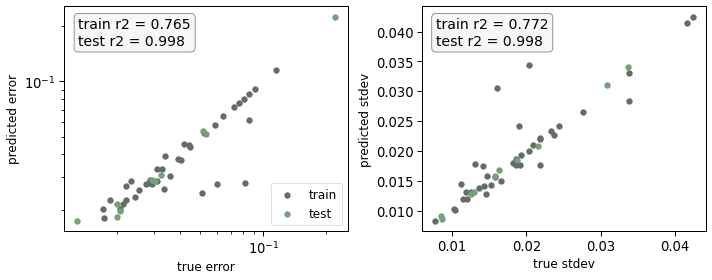

In [23]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))


# particle diameter distance from 300nm
ax0.scatter(train_values[:, 0], train_preds[:, 0], c='#666B6A', s=30, label='train')
ax0.scatter(test_values[:, 0], test_preds[:, 0], c='#72A276', s=30, label='test')

ax0.set_xscale('log')
ax0.set_yscale('log')

ax0.set_xlabel('true error', fontsize=12)
ax0.set_ylabel('predicted error', fontsize=12)

ax0.legend(loc='lower right', fontsize=12)

textstr = f'train r2 = {round(ps_train_r2, 3)}\ntest r2 = {round(ps_test_r2, 3)}'
props = dict(boxstyle='round', facecolor='#f0eff4', alpha=0.5)
ax0.text(
    0.05, 0.95, textstr, transform=ax0.transAxes, fontsize=14,
    verticalalignment='top', bbox=props,
)

# drug loading capacity
ax1.scatter(train_values[:, 1], train_preds[:, 1], c='#666B6A', s=30, label='train')
ax1.scatter(test_values[:, 1], test_preds[:, 1], c='#72A276', s=30, label='test')

ax1.set_xlabel('true stdev', fontsize=12)
ax1.set_ylabel('predicted stdev', fontsize=12)

textstr = f'train r2 = {round(dl_train_r2, 3)}\ntest r2 = {round(dl_test_r2, 3)}'
props = dict(boxstyle='round', facecolor='#f0eff4', alpha=0.5)
ax1.text(
    0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
    verticalalignment='top', bbox=props,
)

plt.tight_layout()

# plt.savefig('ace_100_pairity.png', dpi=400)

## THF 100 $\mu$L

In [44]:
search_space = {
    'batch_size': hp.quniform('batch_size', 10, 50, 10),
    'hidden_act': hp.choice('hidden_act', ['leaky_relu'] ),
    'hidden_depth': hp.quniform('hidden_depth', 2, 5, 1),
    'hidden_nodes': hp.quniform('hidden_nodes', 28, 64, 4),
    'learning_rate': hp.uniform('learning_rate', 1e-5, 5e-3),
    'reg': hp.uniform('reg', 0.001, 1.0)
}

int_params = ['batch_size', 'hidden_depth', 'hidden_nodes']

all_emulators = []
all_losses = []
all_cv_scores = []
all_params = []

In [45]:
def objective(params):
    ''' average performance over cross-validation folds '''
    # build emualtor
    print(f'PARAMS : {params}')
    for param, val in params.items():
        if param in int_params:
            params[param] = int(val)
    model  = BayesNeuralNet(**params, out_act='relu')
    emulator = Emulator(
        dataset='liquid_thf_100', model=model, 
        feature_transform='standardize', target_transform='mean',
    )

    cv_scores = emulator.cross_validate()
    loss = np.mean(cv_scores['validate_rmsd'])
    
    all_losses.append(loss)
    all_cv_scores.append(cv_scores)
    all_params.append(params)
    all_emulators.append(emulator)
    
    return {'loss': loss, 'status': STATUS_OK}

In [46]:
trials = Trials()

best = fmin(
    fn=objective,
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=15,
    trials=trials
)

print(f"BEST VALUE : {best}")

PARAMS : {'batch_size': 20.0, 'hidden_act': 'leaky_relu', 'hidden_depth': 3.0, 'hidden_nodes': 44.0, 'learning_rate': 0.004089603523431327, 'reg': 0.6699678986632992}                              
  0%|                                                                                                                                                        | 0/15 [00:00<?, ?trial/s, best loss=?][INFO] >>> Training model on fold #0...


/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.492          1.483         -2.372          1.539 *
[INFO]             100          0.504          0.676         -0.651          1.209 *
[INFO]             200          0.823          0.404         -0.712          1.251
[INFO]             300          0.837          0.388         -1.834          1.368
[INFO]             400          0.741          0.483         -1.025          1.306
[INFO]             500          0.772          0.451         -1.017          1.302
[INFO]             600          0.874          0.338         -1.555          1.407
[INFO]             700          0.813          0.407         -0.988          1.304
[INFO]             800          0.802          0.428         -2.165          1.466


[INFO]            8600          0.999          0.033         -2.513          1.581
[INFO]            8700          0.995          0.068         -2.611          1.598
[INFO]            8800          0.999          0.029         -2.750          1.622
[INFO]            8900          0.997          0.050         -2.754          1.612
[INFO]            9000          0.999          0.029         -2.735          1.612
[INFO]            9100          0.997          0.051         -2.366          1.580
[INFO]            9200          0.999          0.027         -2.549          1.597
[INFO]            9300          0.998          0.041         -2.498          1.572
[INFO]            9400          0.999          0.034         -2.724          1.614
[INFO]            9500          0.998          0.037         -2.390          1.584
[INFO]            9600          0.998          0.039         -2.427          1.590
[INFO]            9700          0.998          0.038         -2.677          1.611
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.267          1.465         -1.220          0.916 *
[INFO]             100          0.835          0.396         -1.502          1.158
[INFO]             200          0.823          0.420         -3.266          1.461
[INFO]             300          0.910          0.296         -1.985          1.256
[INFO]             400          0.899          0.307         -2.214          1.395
[INFO]             500          0.862          0.358         -2.662          1.428
[INFO]             600          0.887          0.353         -3.603          1.557
[INFO]             700          0.873          0.345         -2.887          1.455
[INFO]             800          0.885          0.331         -5.409          1.837
[I

[INFO]            8700          0.997          0.058         -2.071          1.159
[INFO]            8800          0.998          0.048         -1.913          1.152
[INFO]            8900          0.996          0.071         -2.136          1.164
[INFO]            9000          0.997          0.053         -2.191          1.187
[INFO]            9100          0.997          0.051         -2.064          1.170
[INFO]            9200          0.997          0.055         -1.862          1.125
[INFO]            9300          0.997          0.059         -1.980          1.146
[INFO]            9400          0.995          0.067         -2.154          1.169
[INFO]            9500          0.997          0.054         -2.147          1.173
[INFO]            9600          0.997          0.058         -2.446          1.223
[INFO]            9700          0.992          0.084         -2.390          1.215
[INFO]            9800          0.998          0.042         -2.162          1.173
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.812          1.159         -1.815          1.121 *
[INFO]             100          0.650          0.513         -3.239          1.418
[INFO]             200          0.796          0.388         -3.724          1.500
[INFO]             300          0.892          0.282         -3.227          1.442
[INFO]             400          0.876          0.303         -2.441          1.243
[INFO]             500          0.856          0.328         -1.222          1.017 *
[INFO]             600          0.860          0.332         -2.795          1.382
[INFO]             700          0.890          0.287         -2.692          1.322
[INFO]             800          0.900          0.276         -4.689          1.663


/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.052          1.272         -2.438          2.270 *
[INFO]             100          0.780          0.484         -0.836          1.633 *
[INFO]             200          0.803          0.420         -0.897          1.659
[INFO]             300          0.888          0.335         -0.774          1.615 *
[INFO]             400          0.858          0.368         -0.643          1.573 *
[INFO]             500          0.866          0.365         -0.842          1.612
[INFO]             600          0.875          0.353         -0.501          1.504 *
[INFO]             700          0.884          0.319         -0.685          1.584
[INFO]             800          0.913          0.288         -0.796          

[INFO]            8700          0.982          0.120         -0.467          1.530
[INFO]            8800          0.973          0.149         -0.422          1.499 *
[INFO]            8900          0.977          0.143         -0.474          1.527
[INFO]            9000          0.978          0.137         -0.429          1.506
[INFO]            9100          0.983          0.114         -0.383          1.493 *
[INFO]            9200          0.973          0.151         -0.318          1.449 *
[INFO]            9300          0.982          0.128         -0.359          1.483
[INFO]            9400          0.979          0.122         -0.284          1.450
[INFO]            9500          0.981          0.126         -0.282          1.443 *
[INFO]            9600          0.985          0.111         -0.272          1.433 *
[INFO]            9700          0.984          0.108         -0.387          1.492
[INFO]            9800          0.970          0.146         -0.281          

[INFO]           17500          0.986          0.087         -0.531          1.531
[INFO]           17600          0.990          0.078         -0.424          1.487
[INFO]           17700          0.991          0.072         -0.407          1.481
[INFO]           17800          0.992          0.070         -0.397          1.478
[INFO]           17900          0.991          0.076         -0.445          1.489
[INFO]           18000          0.991          0.075         -0.533          1.528
[INFO]           18100          0.991          0.075         -0.406          1.479
[INFO]           18200          0.991          0.073         -0.453          1.498
[INFO]           18300          0.987          0.086         -0.552          1.549
[INFO]           18400          0.991          0.072         -0.414          1.489
[INFO]           18500          0.991          0.080         -0.274          1.439
[INFO]           18600          0.990          0.079         -0.562          1.536
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.054          1.028         -0.558          0.621 *
[INFO]             100          0.828          0.297         -0.661          0.697
[INFO]             200          0.927          0.193         -2.727          1.033
[INFO]             300          0.816          0.303         -2.050          0.977
[INFO]             400          0.967          0.130         -1.748          0.866
[INFO]             500          0.920          0.204         -2.467          0.995
[INFO]             600          0.910          0.221         -2.558          1.006
[INFO]             700          0.899          0.222         -3.141          1.116
[INFO]             800          0.912          0.211         -2.457          1.010
[I

[INFO]            8700          0.994          0.058         -3.292          1.151
[INFO]            8800          0.993          0.058         -3.363          1.157
[INFO]            8900          0.995          0.050         -3.169          1.132
[INFO]            9000          0.996          0.048         -3.037          1.120
[INFO]            9100          0.995          0.053         -3.051          1.121
[INFO]            9200          0.995          0.052         -3.026          1.115
[INFO]            9300          0.996          0.046         -2.982          1.119
[INFO]            9400          0.995          0.053         -3.042          1.121
[INFO]            9500          0.996          0.045         -3.065          1.121
[INFO]            9600          0.997          0.041         -3.174          1.141
[INFO]            9700          0.995          0.049         -3.122          1.130
[INFO]            9800          0.995          0.052         -3.339          1.156
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.695          1.269         -0.606          0.782 *
[INFO]             100          0.498          0.688         -5.244          1.578
[INFO]             200          0.815          0.426        -22.111          2.891
[INFO]             300          0.849          0.378        -19.925          2.736
[INFO]             400          0.836          0.397        -26.688          3.104
[INFO]             500          0.881          0.337        -25.120          3.013
[INFO]             600          0.888          0.325        -12.990          2.241
[INFO]             700          0.912          0.286        -20.370          2.734
[INFO]             800          0.871          0.343        -18.044          2.627
[I

[INFO]            8700          0.991          0.092        -29.953          3.236
[INFO]            8800          0.992          0.088        -30.213          3.260
[INFO]            8900          0.989          0.101        -31.623          3.330
[INFO]            9000          0.991          0.091        -27.454          3.108
[INFO]            9100          0.991          0.091        -28.003          3.135
[INFO]            9200          0.992          0.088        -30.518          3.257
[INFO]            9300          0.994          0.077        -27.741          3.126
[INFO]            9400          0.989          0.103        -27.996          3.141
[INFO]            9500          0.993          0.084        -30.693          3.271
[INFO]            9600          0.994          0.079        -28.025          3.136
[INFO]            9700          0.989          0.102        -26.146          3.036
[INFO]            9800          0.994          0.076        -28.066          3.132
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.835          1.369         -2.146          0.845 *
[INFO]             100          0.503          0.714         -5.982          1.055
[INFO]             200          0.803          0.450         -8.486          1.121
[INFO]             300          0.847          0.400         -4.611          0.898
[INFO]             400          0.879          0.359         -5.972          0.991
[INFO]             500          0.793          0.466         -6.669          1.047
[INFO]             600          0.750          0.512         -7.308          1.049
[INFO]             700          0.847          0.401         -8.198          1.154
[INFO]             800          0.838          0.407         -5.494          0.946
[I

[INFO]            8500          0.990          0.103         -4.778          0.908
[INFO]            8600          0.996          0.067         -5.880          0.958
[INFO]            8700          0.996          0.067         -5.375          0.906
[INFO]            8800          0.992          0.090         -6.280          0.981
[INFO]            8900          0.994          0.080         -6.095          0.976
[INFO]            9000          0.992          0.093         -5.298          0.911
[INFO]            9100          0.994          0.076         -5.335          0.914
[INFO]            9200          0.992          0.095         -5.024          0.917
[INFO]            9300          0.995          0.071         -4.963          0.901
[INFO]            9400          0.995          0.069         -5.976          0.983
[INFO]            9500          0.992          0.087         -6.082          0.995
[INFO]            9600          0.996          0.067         -7.134          1.034
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.911          1.350         -1.680          2.527 *
[INFO]             100          0.493          0.697         -1.319          2.496 *
[INFO]             200          0.841          0.389         -2.412          2.952
[INFO]             300          0.766          0.471         -1.495          2.588
[INFO]             400          0.873          0.347         -1.960          2.747
[INFO]             500          0.896          0.314         -1.486          2.583
[INFO]             600          0.865          0.358         -1.802          2.706
[INFO]             700          0.882          0.334         -1.536          2.573
[INFO]             800          0.899          0.310         -1.596          2.639


[INFO]            8500          0.972          0.161         -1.857          2.724
[INFO]            8600          0.964          0.183         -1.733          2.700
[INFO]            8700          0.969          0.170         -1.740          2.696
[INFO]            8800          0.970          0.169         -1.589          2.619
[INFO]            8900          0.968          0.174         -1.634          2.640
[INFO]            9000          0.972          0.162         -1.606          2.637
[INFO]            9100          0.973          0.158         -1.423          2.546
[INFO]            9200          0.977          0.148         -1.830          2.716
[INFO]            9300          0.979          0.139         -1.635          2.617
[INFO]            9400          0.977          0.145         -1.868          2.703
[INFO]            9500          0.980          0.136         -1.638          2.633
[INFO]            9600          0.982          0.131         -1.559          2.618
[INF

[INFO]           17400          0.995          0.068         -1.566          2.630
[INFO]           17500          0.994          0.074         -1.463          2.590
[INFO]           17600          0.991          0.091         -1.633          2.663
[INFO]           17700          0.995          0.065         -1.536          2.624
[INFO]           17800          0.996          0.064         -1.621          2.654
[INFO]           17900          0.995          0.071         -1.475          2.599
[INFO]           18000          0.996          0.063         -1.580          2.641
[INFO]           18100          0.993          0.081         -1.508          2.618
[INFO]           18200          0.995          0.070         -1.438          2.579
[INFO]           18300          0.995          0.066         -1.605          2.653
[INFO]           18400          0.995          0.067         -1.516          2.619
[INFO]           18500          0.994          0.073         -1.524          2.624
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.969          1.298         -0.731          1.660 *
[INFO]             100          0.470          0.718         -0.620          1.612 *
[INFO]             200          0.883          0.330         -0.683          1.636
[INFO]             300          0.910          0.292         -0.523          1.564 *
[INFO]             400          0.861          0.366         -0.618          1.606
[INFO]             500          0.860          0.374         -0.662          1.623
[INFO]             600          0.867          0.356         -0.679          1.635
[INFO]             700          0.815          0.419         -0.654          1.623
[INFO]             800          0.878          0.334         -0.650          1.62

[INFO]            8500          0.999          0.037         -0.576          1.585
[INFO]            8600          0.998          0.039         -0.587          1.590
[INFO]            8700          0.994          0.069         -0.589          1.591
[INFO]            8800          0.998          0.040         -0.596          1.594
[INFO]            8900          0.998          0.040         -0.572          1.583
[INFO]            9000          0.998          0.038         -0.584          1.588
[INFO]            9100          0.997          0.052         -0.613          1.601
[INFO]            9200          0.997          0.047         -0.606          1.599
[INFO]            9300          0.998          0.042         -0.585          1.589
[INFO]            9400          0.999          0.032         -0.587          1.590
[INFO]            9500          0.997          0.057         -0.611          1.601
[INFO]            9600          0.999          0.032         -0.598          1.595
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.813          1.335         -0.996          0.857 *
[INFO]             100          0.536          0.675        -10.915          1.673
[INFO]             200          0.873          0.352         -8.760          1.634
[INFO]             300          0.888          0.331        -12.507          1.806
[INFO]             400          0.897          0.317         -9.539          1.646
[INFO]             500          0.885          0.334        -10.323          1.631
[INFO]             600          0.894          0.323         -8.561          1.518
[INFO]             700          0.862          0.370         -5.733          1.298
[INFO]             800          0.832          0.406         -7.641          1.472
[I

[INFO]            8600          0.996          0.060        -14.971          1.878
[INFO]            8700          0.998          0.044        -14.633          1.873
[INFO]            8800          0.998          0.044        -14.727          1.880
[INFO]            8900          0.994          0.080        -14.851          1.868
[INFO]            9000          0.997          0.051        -14.084          1.841
[INFO]            9100          0.997          0.058        -13.775          1.831
[INFO]            9200          0.998          0.043        -15.257          1.912
[INFO]            9300          0.999          0.037        -16.539          1.974
[INFO]            9400          0.997          0.055        -16.201          1.955
[INFO]            9500          0.997          0.056        -16.879          1.986
[INFO]            9600          0.997          0.051        -15.317          1.893
[INFO]            9700          0.997          0.057        -16.044          1.941
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.270          1.294         -1.504          2.134 *
[INFO]             100          0.629          0.517         -0.938          1.884 *
[INFO]             200          0.899          0.276         -1.390          2.060
[INFO]             300          0.906          0.275         -1.367          2.068
[INFO]             400          0.867          0.330         -1.190          1.967
[INFO]             500          0.904          0.266         -1.760          2.165
[INFO]             600          0.863          0.335         -1.382          2.025
[INFO]             700          0.812          0.371         -1.040          1.906
[INFO]             800          0.870          0.293         -1.481          2.055


[INFO]            8500          0.963          0.161         -1.857          2.186
[INFO]            8600          0.937          0.201         -2.180          2.292
[INFO]            8700          0.924          0.230         -2.289          2.319
[INFO]            8800          0.966          0.161         -2.770          2.469
[INFO]            8900          0.893          0.289         -2.618          2.408
[INFO]            9000          0.965          0.158         -2.443          2.357
[INFO]            9100          0.933          0.215         -3.473          2.654
[INFO]            9200          0.926          0.227         -2.515          2.387
[INFO]            9300          0.949          0.192         -2.484          2.374
[INFO]            9400          0.943          0.203         -3.522          2.669
[INFO]            9500          0.924          0.237         -2.686          2.437
[INFO]            9600          0.954          0.179         -2.299          2.319
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.832          1.257         -1.512          1.434 *
[INFO]             100          0.147          0.877         -0.067          0.936 *
[INFO]             200          0.360          0.739         -0.078          0.944
[INFO]             300          0.686          0.564          0.180          0.815 *
[INFO]             400          0.681          0.531         -0.119          0.946
[INFO]             500          0.590          0.575         -0.010          0.908
[INFO]             600          0.700          0.494         -0.195          0.979
[INFO]             700          0.598          0.565          0.040          0.886
[INFO]             800          0.634          0.514         -0.248          1.01

[INFO]            8500          0.505          0.560          0.044          0.876
[INFO]            8600          0.467          0.605          0.207          0.801
[INFO]            8700          0.461          0.587         -0.146          0.958
[INFO]            8800          0.412          0.610          0.328          0.727
[INFO]            8900          0.467          0.592          0.166          0.821
[INFO]            9000          0.381          0.614          0.258          0.771
[INFO]            9100          0.516          0.570          0.018          0.896
[INFO]            9200          0.420          0.604          0.081          0.866
[INFO]            9300          0.455          0.594          0.229          0.787
[INFO]            9400          0.431          0.618          0.072          0.864
[INFO]            9500          0.474          0.602          0.141          0.824
[INFO]            9600          0.201          0.713          0.040          0.882
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.271          1.265         -3.369          0.558 *
[INFO]             100          0.397          0.730         -8.437          0.861
[INFO]             200          0.709          0.476        -27.220          1.626
[INFO]             300          0.757          0.419        -76.910          2.646
[INFO]             400          0.785          0.370        -60.872          2.352
[INFO]             500          0.832          0.400       -106.543          3.066
[INFO]             600          0.734          0.500        -53.970          2.215
[INFO]             700          0.567          0.474        -90.394          2.795
[INFO]             800          0.812          0.403       -100.862          3.008
[I

[INFO]            8600          0.723          0.316        -95.656          2.778
[INFO]            8700          0.806          0.284       -117.575          3.136
[INFO]            8800          0.776          0.305       -123.272          3.293
[INFO]            8900          0.711          0.310       -117.059          3.307
[INFO]            9000          0.833          0.248       -122.315          3.205
[INFO]            9100          0.702          0.324        -87.094          2.786
[INFO]            9200          0.729          0.329       -109.035          2.982
[INFO]            9300          0.692          0.317       -143.580          3.368
[INFO]            9400          0.749          0.294       -156.770          3.628
[INFO]            9500          0.766          0.289       -142.152          3.509
[INFO]            9600          0.698          0.322       -135.168          3.347
[INFO]            9700          0.673          0.343       -105.924          2.948
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -2.104          0.709         -1.674          1.530 *
[INFO]             100         -0.847          0.554         -0.025          1.081 *
[INFO]             200         -2.652          0.713         -0.203          1.049 *
[INFO]             300         -0.850          0.567         -0.263          1.089
[INFO]             400          0.115          0.437         -0.335          1.122
[INFO]             500         -0.113          0.406         -0.489          1.134
[INFO]             600          0.613          0.336         -0.323          1.155
[INFO]             700         -1.130          0.536         -0.496          1.136
[INFO]             800          0.493          0.323         -0.213          1.13

[INFO]            8600          0.076          0.315         -2.034          1.454
[INFO]            8700          0.271          0.279         -1.281          1.301
[INFO]            8800          0.057          0.337         -2.746          1.589
[INFO]            8900          0.458          0.268         -1.683          1.412
[INFO]            9000          0.320          0.306         -1.520          1.423
[INFO]            9100         -0.092          0.336         -1.279          1.290
[INFO]            9200          0.252          0.282         -1.451          1.375
[INFO]            9300          0.261          0.312         -2.299          1.522
[INFO]            9400         -0.048          0.303         -2.480          1.559
[INFO]            9500          0.355          0.269         -2.135          1.465
[INFO]            9600          0.451          0.277         -2.002          1.423
[INFO]            9700          0.389          0.257         -1.853          1.403
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -2.071          0.769         -1.104          0.867 *
[INFO]             100         -1.025          0.685         -1.913          1.019
[INFO]             200          0.194          0.484         -1.953          1.212
[INFO]             300          0.445          0.303         -1.103          0.945
[INFO]             400         -0.078          0.456         -1.606          1.018
[INFO]             500          0.214          0.340         -1.407          0.956
[INFO]             600         -0.255          0.499         -2.599          1.181
[INFO]             700          0.446          0.343         -1.538          1.064
[INFO]             800          0.472          0.292         -1.101          0.908
[I

[INFO]            8700         -0.769          0.539         -1.581          0.975
[INFO]            8800         -0.364          0.437         -2.386          1.069
[INFO]            8900         -0.175          0.399         -1.891          1.082
[INFO]            9000         -0.925          0.520         -1.554          1.025
[INFO]            9100         -0.520          0.460         -1.412          0.972
[INFO]            9200         -0.767          0.500         -2.134          1.142
[INFO]            9300         -0.082          0.440         -1.193          0.896
[INFO]            9400         -0.570          0.455         -1.603          0.913
[INFO]            9500         -0.673          0.467         -2.349          1.008
[INFO]            9600         -0.275          0.423         -2.058          1.083
[INFO]            9700         -0.428          0.421         -1.160          0.936
[INFO]            9800         -0.303          0.464         -1.524          0.923
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.888          1.291         -0.977          1.481 *
[INFO]             100          0.387          0.739          0.045          1.026 *
[INFO]             200          0.674          0.542         -1.167          1.545
[INFO]             300          0.802          0.419         -1.250          1.577
[INFO]             400          0.913          0.277         -1.977          1.819
[INFO]             500          0.876          0.333         -1.958          1.811
[INFO]             600          0.932          0.245         -1.518          1.670
[INFO]             700          0.909          0.282         -1.502          1.660
[INFO]             800          0.922          0.260         -2.074          1.843


[INFO]            8600          1.000          0.011         -2.258          1.900
[INFO]            8700          1.000          0.016         -2.196          1.882
[INFO]            8800          1.000          0.018         -2.201          1.884
[INFO]            8900          1.000          0.016         -2.274          1.905
[INFO]            9000          1.000          0.012         -2.269          1.903
[INFO]            9100          1.000          0.012         -2.264          1.902
[INFO]            9200          1.000          0.014         -2.241          1.896
[INFO]            9300          1.000          0.015         -2.313          1.916
[INFO]            9400          1.000          0.019         -2.280          1.907
[INFO]            9500          1.000          0.010         -2.220          1.889
[INFO]            9600          1.000          0.013         -2.288          1.909
[INFO]            9700          1.000          0.009         -2.236          1.893
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.115          1.318         -1.029          0.767 *
[INFO]             100          0.387          0.710          0.086          0.523 *
[INFO]             200          0.550          0.609         -0.487          0.661
[INFO]             300          0.787          0.418         -2.371          0.992
[INFO]             400          0.843          0.359         -3.593          1.170
[INFO]             500          0.901          0.285         -4.295          1.256
[INFO]             600          0.901          0.284         -6.384          1.488
[INFO]             700          0.914          0.266         -6.827          1.526
[INFO]             800          0.917          0.261         -6.393          1.486


[INFO]            8600          1.000          0.019         -8.064          1.653
[INFO]            8700          1.000          0.018         -7.857          1.635
[INFO]            8800          1.000          0.013         -7.690          1.618
[INFO]            8900          1.000          0.020         -8.037          1.650
[INFO]            9000          1.000          0.012         -7.743          1.624
[INFO]            9100          1.000          0.013         -7.610          1.611
[INFO]            9200          1.000          0.015         -7.874          1.635
[INFO]            9300          1.000          0.012         -7.949          1.642
[INFO]            9400          1.000          0.013         -7.848          1.632
[INFO]            9500          0.999          0.021         -7.926          1.640
[INFO]            9600          1.000          0.018         -7.632          1.614
[INFO]            9700          1.000          0.012         -7.640          1.614
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.231          1.322         -6.817          0.638 *
[INFO]             100          0.348          0.718         -9.958          0.501 *
[INFO]             200          0.566          0.587        -27.949          0.709
[INFO]             300          0.671          0.512        -22.963          0.709
[INFO]             400          0.700          0.489        -38.363          0.811
[INFO]             500          0.748          0.448        -43.307          0.825
[INFO]             600          0.770          0.427        -54.184          0.976
[INFO]             700          0.792          0.409        -43.834          0.921
[INFO]             800          0.825          0.371        -60.676          0.971


[INFO]            8600          1.000          0.011        -76.451          0.955
[INFO]            8700          0.999          0.020        -74.291          0.944
[INFO]            8800          1.000          0.016        -81.899          0.986
[INFO]            8900          1.000          0.012        -76.941          0.955
[INFO]            9000          1.000          0.013        -76.407          0.954
[INFO]            9100          0.999          0.021        -77.847          0.962
[INFO]            9200          1.000          0.013        -80.390          0.978
[INFO]            9300          0.999          0.023        -79.862          0.979
[INFO]            9400          1.000          0.015        -77.376          0.962
[INFO]            9500          1.000          0.011        -79.046          0.966
[INFO]            9600          1.000          0.013        -77.983          0.959
[INFO]            9700          1.000          0.012        -79.140          0.974
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.082          1.355         -1.830          1.118 *
[INFO]             100          0.422          0.714         -2.110          0.924 *
[INFO]             200          0.488          0.672         -1.991          0.977
[INFO]             300          0.534          0.641         -3.070          1.041
[INFO]             400          0.585          0.604         -0.915          0.884 *
[INFO]             500          0.666          0.542         -1.458          0.941
[INFO]             600          0.742          0.477         -0.806          0.920
[INFO]             700          0.755          0.465         -0.952          0.900
[INFO]             800          0.829          0.388         -1.757          0.99

[INFO]            8700          1.000          0.016         -2.119          0.983
[INFO]            8800          0.999          0.025         -2.056          0.980
[INFO]            8900          0.999          0.021         -2.023          0.972
[INFO]            9000          0.999          0.024         -2.221          0.990
[INFO]            9100          1.000          0.016         -2.186          0.983
[INFO]            9200          0.999          0.027         -2.405          0.996
[INFO]            9300          1.000          0.015         -2.133          0.983
[INFO]            9400          1.000          0.015         -2.210          0.984
[INFO]            9500          1.000          0.015         -2.259          0.989
[INFO]            9600          0.999          0.023         -2.187          0.982
[INFO]            9700          1.000          0.018         -2.165          0.981
[INFO]            9800          1.000          0.017         -2.349          0.992
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.973          1.352         -2.840          2.579 *
[INFO]             100          0.856          0.363         -1.940          2.222 *
[INFO]             200          0.957          0.200         -1.813          2.182 *
[INFO]             300          0.956          0.203         -1.655          2.126 *
[INFO]             400          0.964          0.184         -1.658          2.115 *
[INFO]             500          0.951          0.212         -1.509          2.072 *
[INFO]             600          0.948          0.217         -1.531          2.085
[INFO]             700          0.961          0.187         -1.569          2.093
[INFO]             800          0.971          0.165         -1.603        

[INFO]            8600          1.000          0.016         -1.772          2.155
[INFO]            8700          1.000          0.014         -1.774          2.156
[INFO]            8800          1.000          0.010         -1.766          2.154
[INFO]            8900          1.000          0.021         -1.769          2.154
[INFO]            9000          1.000          0.016         -1.764          2.152
[INFO]            9100          1.000          0.009         -1.777          2.157
[INFO]            9200          1.000          0.018         -1.776          2.156
[INFO]            9300          1.000          0.012         -1.785          2.160
[INFO]            9400          1.000          0.010         -1.777          2.156
[INFO]            9500          1.000          0.012         -1.781          2.159
[INFO]            9600          1.000          0.012         -1.784          2.160
[INFO]            9700          1.000          0.012         -1.774          2.156
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.144          1.336         -1.564          0.940 *
[INFO]             100          0.625          0.568         -1.824          0.876 *
[INFO]             200          0.821          0.392         -2.499          0.945
[INFO]             300          0.931          0.239         -4.968          1.215
[INFO]             400          0.936          0.231         -4.635          1.146
[INFO]             500          0.941          0.224         -4.295          1.108
[INFO]             600          0.944          0.218         -3.791          1.063
[INFO]             700          0.950          0.204         -4.213          1.112
[INFO]             800          0.932          0.240         -3.615          1.007


[INFO]            8500          1.000          0.011         -3.395          0.958
[INFO]            8600          0.999          0.024         -3.456          0.960
[INFO]            8700          1.000          0.014         -3.579          0.977
[INFO]            8800          1.000          0.017         -3.225          0.942
[INFO]            8900          1.000          0.018         -3.282          0.947
[INFO]            9000          1.000          0.012         -3.315          0.951
[INFO]            9100          1.000          0.014         -3.244          0.944
[INFO]            9200          1.000          0.008         -3.301          0.950
[INFO]            9300          0.999          0.021         -3.354          0.954
[INFO]            9400          1.000          0.012         -3.394          0.961
[INFO]            9500          1.000          0.010         -3.418          0.963
[INFO]            9600          1.000          0.008         -3.362          0.956
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.113          1.325         -1.022          1.244 *
[INFO]             100          0.462          0.670         -0.150          0.963 *
[INFO]             200          0.683          0.525         -0.216          0.998
[INFO]             300          0.859          0.344         -0.268          1.031
[INFO]             400          0.871          0.326         -0.027          0.922 *
[INFO]             500          0.942          0.224         -0.061          0.934
[INFO]             600          0.948          0.214          0.043          0.893 *
[INFO]             700          0.907          0.288         -0.081          0.940
[INFO]             800          0.949          0.212          0.082          0.

[INFO]            8500          0.999          0.021          0.078          0.882
[INFO]            8600          1.000          0.015          0.076          0.884
[INFO]            8700          1.000          0.010          0.086          0.880
[INFO]            8800          1.000          0.017          0.092          0.875
[INFO]            8900          1.000          0.012          0.099          0.873
[INFO]            9000          1.000          0.010          0.086          0.879
[INFO]            9100          1.000          0.012          0.098          0.873
[INFO]            9200          1.000          0.012          0.075          0.883
[INFO]            9300          1.000          0.015          0.093          0.876
[INFO]            9400          0.999          0.022          0.113          0.868
[INFO]            9500          1.000          0.010          0.092          0.877
[INFO]            9600          1.000          0.009          0.096          0.875
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.245          1.320         -1.484          1.967 *
[INFO]             100          0.626          0.589         -0.405          1.521 *
[INFO]             200          0.857          0.360         -0.799          1.651
[INFO]             300          0.904          0.282         -0.722          1.606
[INFO]             400          0.900          0.278         -0.640          1.581
[INFO]             500          0.966          0.165         -0.599          1.567
[INFO]             600          0.943          0.209         -0.725          1.607
[INFO]             700          0.953          0.183         -0.708          1.601
[INFO]             800          0.957          0.172         -0.730          1.606


[INFO]            8500          0.999          0.025         -0.696          1.600
[INFO]            8600          1.000          0.020         -0.680          1.591
[INFO]            8700          0.999          0.022         -0.695          1.599
[INFO]            8800          1.000          0.009         -0.702          1.600
[INFO]            8900          1.000          0.008         -0.676          1.591
[INFO]            9000          1.000          0.014         -0.682          1.593
[INFO]            9100          1.000          0.009         -0.689          1.595
[INFO]            9200          1.000          0.012         -0.694          1.596
[INFO]            9300          1.000          0.008         -0.696          1.598
[INFO]            9400          0.999          0.023         -0.683          1.591
[INFO]            9500          1.000          0.015         -0.691          1.595
[INFO]            9600          1.000          0.010         -0.696          1.598
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.148          1.344         -2.732          0.923 *
[INFO]             100          0.416          0.729         -2.024          0.566 *
[INFO]             200          0.685          0.532         -3.196          0.648
[INFO]             300          0.829          0.391         -1.474          0.501 *
[INFO]             400          0.945          0.227         -2.077          0.594
[INFO]             500          0.958          0.190         -1.780          0.560
[INFO]             600          0.956          0.196         -1.453          0.591
[INFO]             700          0.955          0.198         -2.077          0.577
[INFO]             800          0.936          0.238         -2.232          0.56

[INFO]            8500          1.000          0.015         -6.959          0.775
[INFO]            8600          1.000          0.016         -6.708          0.762
[INFO]            8700          1.000          0.011         -6.737          0.765
[INFO]            8800          1.000          0.015         -6.701          0.764
[INFO]            8900          1.000          0.012         -6.623          0.761
[INFO]            9000          1.000          0.013         -6.715          0.765
[INFO]            9100          1.000          0.012         -6.684          0.764
[INFO]            9200          1.000          0.014         -6.943          0.774
[INFO]            9300          1.000          0.012         -6.755          0.768
[INFO]            9400          1.000          0.012         -6.644          0.762
[INFO]            9500          1.000          0.016         -6.828          0.770
[INFO]            9600          1.000          0.019         -6.974          0.778
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.186          1.358         -2.462          1.744 *
[INFO]             100         -1.186          1.358         -2.462          1.744
[INFO]             200         -1.186          1.358         -2.462          1.744
[INFO]             300          0.189          0.829         -0.470          1.365 *
[INFO]             400          0.531          0.631         -1.143          1.445
[INFO]             500          0.699          0.506         -1.910          1.559
[INFO]             600          0.735          0.475         -1.268          1.484
[INFO]             700          0.797          0.415         -2.198          1.622
[INFO]             800          0.769          0.443         -2.127          1.623


[INFO]            8600          1.000          0.016         -1.619          1.735
[INFO]            8700          1.000          0.016         -1.685          1.749
[INFO]            8800          1.000          0.016         -1.669          1.761
[INFO]            8900          1.000          0.015         -1.666          1.749
[INFO]            9000          1.000          0.015         -1.677          1.758
[INFO]            9100          1.000          0.015         -1.663          1.751
[INFO]            9200          1.000          0.016         -1.659          1.757
[INFO]            9300          1.000          0.016         -1.648          1.754
[INFO]            9400          0.999          0.021         -1.709          1.769
[INFO]            9500          1.000          0.013         -1.642          1.755
[INFO]            9600          1.000          0.012         -1.665          1.760
[INFO]            9700          1.000          0.009         -1.679          1.767
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.174          1.630         -1.741          1.214 *
[INFO]             100          0.295          0.952         -0.324          0.908 *
[INFO]             200          0.560          0.751         -1.704          1.249
[INFO]             300          0.679          0.635         -3.328          1.610
[INFO]             400          0.823          0.468         -5.457          1.964
[INFO]             500          0.935          0.284        -15.697          2.965
[INFO]             600          0.952          0.247        -12.034          2.652
[INFO]             700          0.917          0.328        -15.557          2.885
[INFO]             800          0.919          0.306        -13.377          2.768


[INFO]            8600          0.995          0.080         -4.089          1.504
[INFO]            8700          0.995          0.076         -4.179          1.549
[INFO]            8800          0.996          0.072         -4.156          1.520
[INFO]            8900          0.995          0.072         -4.622          1.624
[INFO]            9000          0.996          0.070         -4.576          1.630
[INFO]            9100          0.995          0.078         -4.032          1.513
[INFO]            9200          0.995          0.076         -4.166          1.570
[INFO]            9300          0.993          0.092         -4.780          1.621
[INFO]            9400          0.995          0.074         -4.737          1.613
[INFO]            9500          0.997          0.061         -4.747          1.655
[INFO]            9600          0.996          0.070         -4.998          1.646
[INFO]            9700          0.995          0.073         -5.250          1.708
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.987          1.366         -1.270          2.617 *
[INFO]             100          0.564          0.685         -0.565          2.169 *
[INFO]             200          0.783          0.472         -0.629          2.226
[INFO]             300          0.852          0.373         -0.761          2.312
[INFO]             400          0.934          0.252         -0.788          2.335
[INFO]             500          0.943          0.212         -0.801          2.342
[INFO]             600          0.910          0.281         -0.751          2.309
[INFO]             700          0.919          0.248         -0.763          2.319
[INFO]             800          0.934          0.256         -0.689          2.267


[INFO]            8500          0.980          0.139         -0.636          2.236
[INFO]            8600          0.976          0.161         -0.611          2.226
[INFO]            8700          0.980          0.144         -0.618          2.226
[INFO]            8800          0.981          0.139         -0.584          2.213
[INFO]            8900          0.983          0.130         -0.623          2.234
[INFO]            9000          0.974          0.161         -0.611          2.227
[INFO]            9100          0.974          0.175         -0.598          2.216
[INFO]            9200          0.984          0.124         -0.606          2.223
[INFO]            9300          0.980          0.141         -0.619          2.234
[INFO]            9400          0.980          0.142         -0.577          2.199
[INFO]            9500          0.978          0.151         -0.619          2.231
[INFO]            9600          0.980          0.150         -0.561          2.187
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.053          1.362         -1.097          0.698 *
[INFO]             100          0.355          0.764         -1.572          0.614 *
[INFO]             200          0.648          0.566         -2.497          0.671
[INFO]             300          0.798          0.429         -6.393          0.998
[INFO]             400          0.774          0.454        -14.122          1.398
[INFO]             500          0.858          0.359        -17.929          1.539
[INFO]             600          0.869          0.346        -15.001          1.419
[INFO]             700          0.890          0.316        -10.832          1.215
[INFO]             800          0.902          0.299        -20.571          1.653


[INFO]            8600          0.989          0.101        -55.277          2.672
[INFO]            8700          0.991          0.091        -55.243          2.662
[INFO]            8800          0.991          0.089        -47.296          2.480
[INFO]            8900          0.985          0.118        -43.672          2.404
[INFO]            9000          0.990          0.093        -48.104          2.488
[INFO]            9100          0.986          0.113        -47.914          2.485
[INFO]            9200          0.990          0.096        -48.122          2.509
[INFO]            9300          0.991          0.090        -50.000          2.557
[INFO]            9400          0.991          0.090        -47.985          2.515
[INFO]            9500          0.988          0.105        -48.974          2.535
[INFO]            9600          0.991          0.089        -47.713          2.504
[INFO]            9700          0.989          0.100        -51.132          2.590
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.856          1.057         -1.407          1.280 *
[INFO]             100         -0.214          0.693         -0.599          1.062 *
[INFO]             200          0.327          0.518         -1.003          1.187
[INFO]             300          0.612          0.393         -2.190          1.484
[INFO]             400          0.713          0.338         -2.174          1.489
[INFO]             500          0.784          0.294         -1.846          1.428
[INFO]             600          0.806          0.278         -1.857          1.429
[INFO]             700          0.828          0.261         -1.000          1.202
[INFO]             800          0.772          0.300         -1.425          1.322


[INFO]            8600          0.940          0.154         -0.822          1.166
[INFO]            8700          0.955          0.134         -1.082          1.243
[INFO]            8800          0.960          0.126         -1.073          1.236
[INFO]            8900          0.958          0.129         -0.850          1.168
[INFO]            9000          0.959          0.128         -1.103          1.242
[INFO]            9100          0.970          0.110         -1.021          1.220
[INFO]            9200          0.969          0.111         -0.937          1.194
[INFO]            9300          0.953          0.137         -0.851          1.171
[INFO]            9400          0.966          0.115         -0.803          1.162
[INFO]            9500          0.963          0.121         -0.761          1.147
[INFO]            9600          0.971          0.107         -0.973          1.211
[INFO]            9700          0.976          0.098         -0.746          1.142
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.621          1.450         -2.365          0.882 *
[INFO]             100          0.297          0.966         -1.776          0.666 *
[INFO]             200          0.373          0.916         -5.723          0.958
[INFO]             300          0.509          0.813         -4.017          0.855
[INFO]             400          0.586          0.748         -4.726          0.980
[INFO]             500          0.813          0.504         -2.538          0.834
[INFO]             600          0.813          0.505         -2.717          0.881
[INFO]             700          0.836          0.469         -3.279          0.958
[INFO]             800          0.822          0.492         -3.836          1.014


[INFO]            8500          0.990          0.116         -0.831          0.727
[INFO]            8600          0.991          0.112         -1.362          0.745
[INFO]            8700          0.992          0.106         -1.346          0.754
[INFO]            8800          0.991          0.113         -1.303          0.737
[INFO]            8900          0.984          0.144         -1.364          0.780
[INFO]            9000          0.992          0.101         -1.038          0.729
[INFO]            9100          0.993          0.094         -0.945          0.681
[INFO]            9200          0.992          0.101         -1.173          0.756
[INFO]            9300          0.994          0.086         -0.947          0.732
[INFO]            9400          0.994          0.090         -1.245          0.725
[INFO]            9500          0.990          0.112         -1.090          0.696
[INFO]            9600          0.994          0.093         -0.907          0.693
[INF

[INFO]           17400          0.999          0.030         -0.103          0.506
[INFO]           17500          0.999          0.031         -0.161          0.526
[INFO]           17600          0.999          0.034         -0.027          0.524
[INFO]           17700          0.999          0.031         -0.093          0.512
[INFO]           17800          0.999          0.037         -0.165          0.510
[INFO]           17900          0.999          0.044         -0.137          0.504
[INFO]           18000          0.999          0.035         -0.138          0.518
[INFO]           18100          0.999          0.031         -0.085          0.505
[INFO]           18200          0.999          0.034         -0.153          0.530
[INFO]           18300          0.999          0.033         -0.188          0.522
[INFO]           18400          1.000          0.025         -0.006          0.503
[INFO]           18500          1.000          0.023         -0.098          0.517
[INF

[INFO]           26200          1.000          0.021          0.096          0.512
[INFO]           26300          1.000          0.020          0.084          0.514
[INFO]           26400          1.000          0.024          0.125          0.512
[INFO]           26500          1.000          0.020          0.084          0.536
[INFO]           26600          1.000          0.019          0.080          0.525
[INFO]           26700          1.000          0.025         -0.026          0.531
[INFO]           26800          1.000          0.023          0.025          0.530
[INFO]           26900          1.000          0.016          0.084          0.526
[INFO]           27000          1.000          0.016          0.121          0.519
[INFO]           27100          0.999          0.028          0.107          0.519
[INFO]           27200          1.000          0.020          0.021          0.521
[INFO]           27300          1.000          0.016          0.098          0.519
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.361          1.426         -1.358          1.091 *
[INFO]             100          0.196          0.861         -0.038          0.733 *
[INFO]             200          0.369          0.761         -0.363          0.856
[INFO]             300          0.457          0.712         -0.462          0.890
[INFO]             400          0.566          0.636         -0.452          0.888
[INFO]             500          0.651          0.572         -0.875          0.992
[INFO]             600          0.732          0.504         -1.142          1.055
[INFO]             700          0.770          0.462         -1.248          1.058
[INFO]             800          0.815          0.417         -1.240          1.061


[INFO]            8600          0.999          0.029         -1.821          1.144
[INFO]            8700          0.998          0.036         -1.812          1.143
[INFO]            8800          0.999          0.025         -1.913          1.160
[INFO]            8900          0.999          0.031         -1.996          1.174
[INFO]            9000          0.998          0.040         -1.832          1.146
[INFO]            9100          0.999          0.035         -1.901          1.158
[INFO]            9200          0.999          0.031         -1.913          1.162
[INFO]            9300          0.999          0.032         -1.972          1.172
[INFO]            9400          0.999          0.026         -1.820          1.143
[INFO]            9500          0.998          0.039         -1.927          1.167
[INFO]            9600          0.999          0.026         -1.869          1.153
[INFO]            9700          0.999          0.036         -2.007          1.178
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.992          1.582         -1.789          2.016 *
[INFO]             100          0.068          1.122         -0.396          1.436 *
[INFO]             200          0.257          1.009         -0.646          1.545
[INFO]             300          0.394          0.916         -0.824          1.613
[INFO]             400          0.542          0.791         -1.215          1.752
[INFO]             500          0.673          0.671         -1.373          1.808
[INFO]             600          0.795          0.537         -1.549          1.873
[INFO]             700          0.873          0.410         -1.487          1.855
[INFO]             800          0.918          0.324         -1.574          1.878


[INFO]            8600          0.999          0.029         -1.204          1.744
[INFO]            8700          0.999          0.033         -1.178          1.738
[INFO]            8800          0.999          0.031         -1.208          1.747
[INFO]            8900          0.999          0.026         -1.185          1.741
[INFO]            9000          0.999          0.041         -1.225          1.752
[INFO]            9100          0.999          0.037         -1.185          1.743
[INFO]            9200          0.999          0.026         -1.196          1.744
[INFO]            9300          1.000          0.020         -1.186          1.742
[INFO]            9400          1.000          0.020         -1.170          1.736
[INFO]            9500          0.999          0.035         -1.174          1.737
[INFO]            9600          1.000          0.021         -1.176          1.739
[INFO]            9700          1.000          0.022         -1.188          1.742
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.914          1.076         -0.810          1.539 *
[INFO]             100          0.230          0.683         -0.276          1.342 *
[INFO]             200          0.422          0.591         -0.283          1.338 *
[INFO]             300          0.506          0.546         -0.451          1.413
[INFO]             400          0.592          0.497         -0.843          1.564
[INFO]             500          0.802          0.346         -1.288          1.737
[INFO]             600          0.887          0.262         -2.046          1.972
[INFO]             700          0.872          0.279         -2.454          2.100
[INFO]             800          0.843          0.308         -2.666          2.14

[INFO]            8600          0.999          0.022         -5.991          2.804
[INFO]            8700          0.999          0.022         -6.356          2.857
[INFO]            8800          0.999          0.021         -6.541          2.886
[INFO]            8900          1.000          0.016         -6.199          2.826
[INFO]            9000          0.999          0.026         -6.019          2.804
[INFO]            9100          1.000          0.017         -6.279          2.835
[INFO]            9200          1.000          0.016         -6.155          2.834
[INFO]            9300          0.999          0.021         -6.557          2.893
[INFO]            9400          0.999          0.023         -6.298          2.844
[INFO]            9500          0.999          0.021         -6.333          2.853
[INFO]            9600          0.999          0.018         -6.259          2.842
[INFO]            9700          1.000          0.016         -6.503          2.880
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.977          1.478         -1.245          1.051 *
[INFO]             100          0.164          1.013         -0.125          0.727 *
[INFO]             200          0.328          0.925         -0.549          0.816
[INFO]             300          0.418          0.868         -0.845          0.880
[INFO]             400          0.527          0.785         -0.979          0.920
[INFO]             500          0.577          0.741         -1.275          1.007
[INFO]             600          0.650          0.675         -0.592          0.835
[INFO]             700          0.699          0.619         -0.795          0.881
[INFO]             800          0.753          0.569         -0.763          0.895


[INFO]            8600          0.993          0.088         -0.854          0.884
[INFO]            8700          0.992          0.091         -0.994          0.915
[INFO]            8800          0.992          0.088         -0.912          0.900
[INFO]            8900          0.992          0.089         -0.992          0.915
[INFO]            9000          0.991          0.094         -1.115          0.939
[INFO]            9100          0.992          0.092         -1.075          0.938
[INFO]            9200          0.992          0.091         -0.965          0.906
[INFO]            9300          0.993          0.087         -1.034          0.926
[INFO]            9400          0.992          0.089         -0.925          0.904
[INFO]            9500          0.992          0.090         -0.941          0.901
[INFO]            9600          0.992          0.089         -0.909          0.898
[INFO]            9700          0.993          0.088         -1.007          0.916
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.609          1.540         -0.614          1.122 *
[INFO]             100         -0.001          0.952         -0.026          0.887 *
[INFO]             200          0.024          0.940          0.063          0.843 *
[INFO]             300          0.097          0.906         -0.151          0.934
[INFO]             400          0.238          0.835         -0.380          1.013
[INFO]             500          0.391          0.752         -0.957          1.202
[INFO]             600          0.543          0.660         -1.444          1.342
[INFO]             700          0.568          0.642         -1.620          1.387
[INFO]             800          0.608          0.612         -1.694          1.41

[INFO]            8600          0.995          0.063         -1.470          1.364
[INFO]            8700          0.994          0.069         -1.461          1.362
[INFO]            8800          0.995          0.062         -1.490          1.371
[INFO]            8900          0.995          0.065         -1.464          1.363
[INFO]            9000          0.995          0.066         -1.480          1.365
[INFO]            9100          0.995          0.064         -1.503          1.374
[INFO]            9200          0.995          0.065         -1.473          1.364
[INFO]            9300          0.995          0.061         -1.458          1.361
[INFO]            9400          0.995          0.062         -1.503          1.374
[INFO]            9500          0.995          0.060         -1.487          1.369
[INFO]            9600          0.995          0.062         -1.465          1.363
[INFO]            9700          0.995          0.061         -1.469          1.364
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.104          1.374         -1.180          2.031 *
[INFO]             100          0.366          0.755         -0.773          1.814 *
[INFO]             200          0.502          0.672         -0.890          1.900
[INFO]             300          0.675          0.542         -0.833          1.897
[INFO]             400          0.911          0.280         -0.738          1.859
[INFO]             500          0.885          0.318         -0.610          1.839
[INFO]             600          0.927          0.253         -0.676          1.816
[INFO]             700          0.923          0.260         -0.585          1.814 *
[INFO]             800          0.943          0.223         -0.822          1.87

[INFO]            8700          1.000          0.013         -0.738          1.881
[INFO]            8800          0.999          0.027         -0.729          1.880
[INFO]            8900          1.000          0.018         -0.740          1.881
[INFO]            9000          0.999          0.028         -0.746          1.883
[INFO]            9100          1.000          0.010         -0.742          1.883
[INFO]            9200          1.000          0.013         -0.746          1.884
[INFO]            9300          1.000          0.013         -0.740          1.882
[INFO]            9400          1.000          0.013         -0.738          1.881
[INFO]            9500          1.000          0.010         -0.743          1.883
[INFO]            9600          1.000          0.014         -0.735          1.880
[INFO]            9700          1.000          0.010         -0.746          1.883
[INFO]            9800          1.000          0.012         -0.746          1.883
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.806          1.430         -2.211          1.173 *
[INFO]             100          0.158          0.983         -0.386          0.804 *
[INFO]             200          0.389          0.835         -0.351          0.760 *
[INFO]             300          0.793          0.482         -5.631          1.731
[INFO]             400          0.880          0.370         -9.751          2.188
[INFO]             500          0.943          0.253        -11.911          2.486
[INFO]             600          0.924          0.297        -14.541          2.717
[INFO]             700          0.956          0.228        -11.294          2.433
[INFO]             800          0.962          0.208        -21.242          3.25

[INFO]            8600          1.000          0.012        -21.021          3.237
[INFO]            8700          1.000          0.012        -20.429          3.198
[INFO]            8800          1.000          0.020        -20.691          3.225
[INFO]            8900          1.000          0.020        -20.941          3.243
[INFO]            9000          1.000          0.017        -19.886          3.142
[INFO]            9100          1.000          0.012        -20.571          3.214
[INFO]            9200          1.000          0.012        -20.431          3.196
[INFO]            9300          1.000          0.014        -20.146          3.171
[INFO]            9400          1.000          0.014        -20.470          3.193
[INFO]            9500          1.000          0.020        -20.179          3.180
[INFO]            9600          1.000          0.013        -19.919          3.158
[INFO]            9700          1.000          0.023        -19.606          3.136
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.930          1.312         -0.838          1.738 *
[INFO]             100          0.326          0.831         -0.516          1.519 *
[INFO]             200          0.833          0.396         -1.518          1.807
[INFO]             300          0.944          0.227         -2.225          1.966
[INFO]             400          0.945          0.235         -1.621          1.816
[INFO]             500          0.959          0.203         -2.311          1.948
[INFO]             600          0.960          0.196         -1.503          1.774
[INFO]             700          0.940          0.229         -1.765          1.812
[INFO]             800          0.959          0.205         -1.442          1.771


[INFO]            8600          1.000          0.010         -1.003          1.661
[INFO]            8700          1.000          0.010         -0.983          1.653
[INFO]            8800          1.000          0.008         -0.950          1.644
[INFO]            8900          1.000          0.012         -0.974          1.651
[INFO]            9000          1.000          0.007         -0.983          1.654
[INFO]            9100          1.000          0.009         -0.991          1.655
[INFO]            9200          1.000          0.008         -0.991          1.655
[INFO]            9300          0.999          0.026         -0.941          1.641
[INFO]            9400          1.000          0.008         -1.005          1.659
[INFO]            9500          1.000          0.017         -1.029          1.665
[INFO]            9600          1.000          0.021         -1.060          1.675
[INFO]            9700          1.000          0.011         -1.028          1.666
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.939          1.414         -1.102          1.186 *
[INFO]             100          0.236          0.884         -0.311          0.986 *
[INFO]             200          0.523          0.686         -1.077          1.231
[INFO]             300          0.734          0.506         -2.870          1.660
[INFO]             400          0.827          0.415         -4.081          1.847
[INFO]             500          0.912          0.301         -3.952          1.850
[INFO]             600          0.956          0.213         -3.706          1.787
[INFO]             700          0.930          0.269         -5.031          1.999
[INFO]             800          0.957          0.211         -3.360          1.736


[INFO]            8600          1.000          0.015         -8.323          2.516
[INFO]            8700          0.999          0.025         -8.472          2.536
[INFO]            8800          0.998          0.042         -7.790          2.438
[INFO]            8900          1.000          0.013         -7.972          2.468
[INFO]            9000          1.000          0.010         -8.142          2.492
[INFO]            9100          1.000          0.014         -8.105          2.486
[INFO]            9200          1.000          0.015         -8.322          2.514
[INFO]            9300          1.000          0.017         -8.084          2.484
[INFO]            9400          1.000          0.017         -8.491          2.538
[INFO]            9500          1.000          0.018         -8.139          2.487
[INFO]            9600          1.000          0.015         -8.310          2.510
[INFO]            9700          0.999          0.028         -8.579          2.548
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.983          1.347         -1.081          0.746 *
[INFO]             100          0.161          0.885         -6.690          1.000
[INFO]             200          0.294          0.809         -5.273          0.879
[INFO]             300          0.445          0.714         -6.086          1.011
[INFO]             400          0.870          0.340         -9.682          1.248
[INFO]             500          0.903          0.300        -16.514          1.652
[INFO]             600          0.925          0.264        -19.337          1.708
[INFO]             700          0.927          0.252        -15.547          1.506
[INFO]             800          0.926          0.261        -13.923          1.435
[I

[INFO]            8700          1.000          0.014        -30.512          1.935
[INFO]            8800          1.000          0.021        -32.210          1.981
[INFO]            8900          0.999          0.023        -32.246          1.984
[INFO]            9000          0.999          0.034        -30.449          1.933
[INFO]            9100          1.000          0.012        -30.090          1.919
[INFO]            9200          1.000          0.011        -30.693          1.939
[INFO]            9300          1.000          0.011        -29.857          1.915
[INFO]            9400          1.000          0.013        -30.329          1.936
[INFO]            9500          0.999          0.031        -30.223          1.894
[INFO]            9600          1.000          0.015        -29.731          1.910
[INFO]            9700          0.999          0.022        -29.571          1.900
[INFO]            9800          1.000          0.019        -30.354          1.942
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.122          1.215         -0.591          1.527 *
[INFO]             100          0.686          0.498         -0.548          1.426 *
[INFO]             200          0.837          0.359         -0.652          1.477
[INFO]             300          0.942          0.211         -0.375          1.358 *
[INFO]             400          0.929          0.227         -0.337          1.354 *
[INFO]             500          0.912          0.259         -0.243          1.309 *
[INFO]             600          0.955          0.185         -0.254          1.311
[INFO]             700          0.968          0.153         -0.262          1.319
[INFO]             800          0.970          0.154         -0.252          

[INFO]            8600          1.000          0.017         -0.321          1.362
[INFO]            8700          0.999          0.031         -0.330          1.364
[INFO]            8800          1.000          0.013         -0.329          1.364
[INFO]            8900          1.000          0.016         -0.337          1.366
[INFO]            9000          1.000          0.016         -0.344          1.369
[INFO]            9100          0.999          0.025         -0.343          1.366
[INFO]            9200          1.000          0.017         -0.333          1.366
[INFO]            9300          1.000          0.014         -0.334          1.364
[INFO]            9400          1.000          0.016         -0.326          1.362
[INFO]            9500          1.000          0.014         -0.329          1.364
[INFO]            9600          1.000          0.014         -0.327          1.362
[INFO]            9700          1.000          0.018         -0.346          1.369
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.064          1.322         -0.867          1.286 *
[INFO]             100          0.598          0.577         -1.320          1.395
[INFO]             200          0.821          0.386         -1.791          1.522
[INFO]             300          0.917          0.259         -1.435          1.421
[INFO]             400          0.970          0.162         -1.606          1.480
[INFO]             500          0.956          0.190         -1.603          1.484
[INFO]             600          0.956          0.189         -2.114          1.604
[INFO]             700          0.928          0.248         -1.516          1.458
[INFO]             800          0.979          0.133         -2.277          1.662
[I

[INFO]            8600          1.000          0.016         -2.780          1.761
[INFO]            8700          1.000          0.016         -2.876          1.777
[INFO]            8800          1.000          0.013         -2.812          1.767
[INFO]            8900          1.000          0.013         -2.675          1.737
[INFO]            9000          0.999          0.024         -2.822          1.771
[INFO]            9100          1.000          0.009         -2.785          1.763
[INFO]            9200          1.000          0.017         -2.868          1.783
[INFO]            9300          1.000          0.012         -2.724          1.750
[INFO]            9400          1.000          0.015         -2.801          1.768
[INFO]            9500          1.000          0.010         -2.750          1.756
[INFO]            9600          1.000          0.012         -2.872          1.782
[INFO]            9700          1.000          0.012         -2.776          1.758
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.596          1.352         -3.584          1.741 *
[INFO]             100          0.516          0.736         -1.419          1.428 *
[INFO]             200          0.936          0.270         -2.805          1.580
[INFO]             300          0.946          0.251         -2.876          1.586
[INFO]             400          0.909          0.317         -1.953          1.468
[INFO]             500          0.953          0.232         -1.943          1.460
[INFO]             600          0.934          0.270         -2.221          1.517
[INFO]             700          0.950          0.241         -1.984          1.463
[INFO]             800          0.966          0.198         -1.655          1.407 

[INFO]            8500          0.999          0.029         -1.448          1.383
[INFO]            8600          1.000          0.008         -1.465          1.378
[INFO]            8700          1.000          0.022         -1.495          1.381
[INFO]            8800          0.999          0.029         -1.422          1.376
[INFO]            8900          1.000          0.016         -1.477          1.377
[INFO]            9000          1.000          0.011         -1.428          1.375
[INFO]            9100          1.000          0.017         -1.449          1.376
[INFO]            9200          1.000          0.011         -1.401          1.368
[INFO]            9300          0.999          0.027         -1.340          1.358 *
[INFO]            9400          1.000          0.015         -1.396          1.365
[INFO]            9500          1.000          0.009         -1.402          1.368
[INFO]            9600          1.000          0.011         -1.404          1.368
[I

[INFO]           17300          1.000          0.021         -1.426          1.350
[INFO]           17400          1.000          0.008         -1.348          1.340 *
[INFO]           17500          1.000          0.006         -1.370          1.342
[INFO]           17600          1.000          0.006         -1.381          1.346
[INFO]           17700          1.000          0.014         -1.365          1.344
[INFO]           17800          1.000          0.019         -1.427          1.349
[INFO]           17900          1.000          0.005         -1.422          1.354
[INFO]           18000          1.000          0.009         -1.401          1.352
[INFO]           18100          1.000          0.007         -1.408          1.353
[INFO]           18200          1.000          0.009         -1.414          1.355
[INFO]           18300          1.000          0.015         -1.425          1.359
[INFO]           18400          1.000          0.008         -1.382          1.349
[I

[INFO]           26100          1.000          0.009         -1.345          1.334 *
[INFO]           26200          1.000          0.016         -1.336          1.333 *
[INFO]           26300          1.000          0.004         -1.362          1.339
[INFO]           26400          1.000          0.011         -1.421          1.340
[INFO]           26500          1.000          0.014         -1.378          1.336
[INFO]           26600          1.000          0.007         -1.396          1.341
[INFO]           26700          1.000          0.004         -1.361          1.335
[INFO]           26800          1.000          0.008         -1.369          1.332 *
[INFO]           26900          1.000          0.007         -1.368          1.337
[INFO]           27000          1.000          0.011         -1.363          1.335
[INFO]           27100          1.000          0.006         -1.332          1.330 *
[INFO]           27200          1.000          0.011         -1.332          1.

[INFO]           34900          1.000          0.006         -1.283          1.312
[INFO]           35000          1.000          0.021         -1.283          1.311
[INFO]           35100          1.000          0.005         -1.282          1.312
[INFO]           35200          1.000          0.008         -1.280          1.310 *
[INFO]           35300          1.000          0.019         -1.305          1.310
[INFO]           35400          1.000          0.006         -1.295          1.311
[INFO]           35500          1.000          0.009         -1.296          1.314
[INFO]           35600          1.000          0.005         -1.300          1.315
[INFO]           35700          1.000          0.011         -1.321          1.315
[INFO]           35800          1.000          0.010         -1.315          1.319
[INFO]           35900          1.000          0.010         -1.321          1.317
[INFO]           36000          1.000          0.004         -1.327          1.316
[I

[INFO]           43700          1.000          0.004         -1.370          1.318
[INFO]           43800          1.000          0.003         -1.371          1.320
[INFO]           43900          1.000          0.006         -1.343          1.314
[INFO]           44000          1.000          0.011         -1.344          1.316
[INFO]           44100          1.000          0.006         -1.347          1.315
[INFO]           44200          1.000          0.007         -1.371          1.316
[INFO]           44300          1.000          0.010         -1.342          1.314
[INFO]           44400          1.000          0.004         -1.370          1.320
[INFO]           44500          1.000          0.013         -1.377          1.320
[INFO]           44600          1.000          0.006         -1.330          1.312
[INFO]           44700          1.000          0.004         -1.321          1.312
[INFO]           44800          1.000          0.005         -1.323          1.314
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.015          1.263         -5.116          0.360 *
[INFO]             100          0.679          0.498       -153.614          1.451
[INFO]             200          0.844          0.347       -149.710          1.427
[INFO]             300          0.874          0.317        -60.780          0.900
[INFO]             400          0.954          0.192       -123.832          1.247
[INFO]             500          0.947          0.203       -189.054          1.613
[INFO]             600          0.949          0.198       -147.449          1.359
[INFO]             700          0.881          0.305       -124.958          1.258
[INFO]             800          0.960          0.177        -87.007          1.056
[I

[INFO]            8600          1.000          0.011       -108.061          1.204
[INFO]            8700          1.000          0.010       -102.080          1.167
[INFO]            8800          1.000          0.019       -103.620          1.183
[INFO]            8900          1.000          0.010       -103.863          1.182
[INFO]            9000          1.000          0.011       -105.061          1.186
[INFO]            9100          1.000          0.015       -106.964          1.199
[INFO]            9200          1.000          0.014       -104.379          1.184
[INFO]            9300          1.000          0.011       -106.028          1.196
[INFO]            9400          1.000          0.010       -107.054          1.197
[INFO]            9500          1.000          0.012       -103.709          1.177
[INFO]            9600          1.000          0.013       -109.367          1.214
[INFO]            9700          1.000          0.009       -103.658          1.183
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.100          1.362         -1.668          1.513 *
[INFO]             100          0.318          0.777         -1.558          1.434 *
[INFO]             200          0.754          0.469         -0.055          1.139 *
[INFO]             300          0.933          0.244         -1.261          1.596
[INFO]             400          0.883          0.322         -0.320          1.291
[INFO]             500          0.921          0.264         -0.198          1.200
[INFO]             600          0.936          0.239         -0.422          1.333
[INFO]             700          0.912          0.280         -0.215          1.233
[INFO]             800          0.943          0.225         -0.351          1.28

[INFO]            8600          1.000          0.018         -0.997          1.368
[INFO]            8700          1.000          0.016         -1.035          1.375
[INFO]            8800          1.000          0.011         -1.138          1.380
[INFO]            8900          1.000          0.018         -1.127          1.381
[INFO]            9000          1.000          0.008         -1.087          1.385
[INFO]            9100          1.000          0.020         -1.308          1.420
[INFO]            9200          1.000          0.010         -1.196          1.400
[INFO]            9300          1.000          0.021         -1.087          1.380
[INFO]            9400          1.000          0.012         -1.138          1.387
[INFO]            9500          1.000          0.019         -1.180          1.397
[INFO]            9600          1.000          0.011         -1.215          1.396
[INFO]            9700          1.000          0.014         -1.135          1.381
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.026          1.355         -1.817          1.411 *
[INFO]             100          0.529          0.673         -0.021          0.987 *
[INFO]             200          0.821          0.417         -2.874          1.809
[INFO]             300          0.915          0.281         -7.643          2.735
[INFO]             400          0.940          0.238         -7.122          2.679
[INFO]             500          0.965          0.181         -5.772          2.478
[INFO]             600          0.970          0.171         -9.403          2.961
[INFO]             700          0.972          0.160         -8.104          2.819
[INFO]             800          0.975          0.154        -10.935          3.210


[INFO]            8600          1.000          0.004        -15.055          3.731
[INFO]            8700          1.000          0.004        -14.987          3.721
[INFO]            8800          1.000          0.005        -15.070          3.732
[INFO]            8900          1.000          0.014        -15.183          3.745
[INFO]            9000          1.000          0.013        -15.263          3.747
[INFO]            9100          1.000          0.015        -14.926          3.720
[INFO]            9200          1.000          0.006        -15.208          3.747
[INFO]            9300          1.000          0.005        -15.039          3.727
[INFO]            9400          1.000          0.010        -14.892          3.710
[INFO]            9500          1.000          0.021        -14.701          3.695
[INFO]            9600          1.000          0.006        -15.077          3.735
[INFO]            9700          1.000          0.008        -14.803          3.704
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.827          1.320         -1.474          1.039 *
[INFO]             100          0.649          0.604         -4.069          1.497
[INFO]             200          0.885          0.339        -24.257          3.397
[INFO]             300          0.927          0.274        -29.616          3.784
[INFO]             400          0.968          0.182        -29.227          3.771
[INFO]             500          0.978          0.145        -32.591          3.997
[INFO]             600          0.977          0.151        -37.232          4.229
[INFO]             700          0.975          0.162        -35.210          4.130
[INFO]             800          0.993          0.085        -40.556          4.421
[I

[INFO]            8700          1.000          0.010        -31.719          3.869
[INFO]            8800          1.000          0.005        -31.200          3.835
[INFO]            8900          1.000          0.019        -31.186          3.834
[INFO]            9000          1.000          0.005        -31.619          3.861
[INFO]            9100          1.000          0.018        -30.604          3.803
[INFO]            9200          1.000          0.006        -31.324          3.844
[INFO]            9300          1.000          0.018        -32.219          3.894
[INFO]            9400          1.000          0.011        -31.401          3.846
[INFO]            9500          1.000          0.009        -31.272          3.839
[INFO]            9600          1.000          0.009        -31.206          3.837
[INFO]            9700          1.000          0.012        -31.697          3.862
[INFO]            9800          1.000          0.007        -31.505          3.855
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.955          1.289         -1.354          0.960 *
[INFO]             100          0.643          0.586         -0.488          0.741 *
[INFO]             200          0.856          0.372         -2.071          1.064
[INFO]             300          0.913          0.276         -2.028          1.089
[INFO]             400          0.944          0.221         -2.743          1.236
[INFO]             500          0.961          0.184         -2.590          1.170
[INFO]             600          0.946          0.221         -2.242          1.140
[INFO]             700          0.964          0.178         -3.199          1.300
[INFO]             800          0.957          0.195         -3.538          1.340


[INFO]            8600          0.979          0.135         -3.678          1.360
[INFO]            8700          0.979          0.135         -3.896          1.387
[INFO]            8800          0.979          0.136         -3.883          1.400
[INFO]            8900          0.979          0.137         -3.603          1.349
[INFO]            9000          0.979          0.135         -3.642          1.363
[INFO]            9100          0.979          0.135         -3.755          1.373
[INFO]            9200          0.979          0.135         -3.599          1.353
[INFO]            9300          0.979          0.136         -3.626          1.356
[INFO]            9400          0.979          0.135         -3.833          1.380
[INFO]            9500          0.979          0.136         -3.583          1.352
[INFO]            9600          0.979          0.135         -3.744          1.374
[INFO]            9700          0.979          0.136         -3.706          1.373
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.209          1.256         -1.205          2.187 *
[INFO]             100          0.824          0.396         -0.612          1.887 *
[INFO]             200          0.921          0.264         -0.685          1.930
[INFO]             300          0.971          0.157         -0.697          1.940
[INFO]             400          0.971          0.150         -0.761          1.976
[INFO]             500          0.981          0.126         -0.783          1.986
[INFO]             600          0.984          0.105         -0.680          1.929
[INFO]             700          0.984          0.104         -0.695          1.934
[INFO]             800          0.971          0.151         -0.635          1.899


[INFO]            8600          1.000          0.005         -0.726          1.950
[INFO]            8700          1.000          0.006         -0.733          1.954
[INFO]            8800          1.000          0.005         -0.726          1.950
[INFO]            8900          1.000          0.008         -0.731          1.952
[INFO]            9000          1.000          0.010         -0.729          1.952
[INFO]            9100          0.999          0.028         -0.737          1.956
[INFO]            9200          1.000          0.003         -0.728          1.951
[INFO]            9300          1.000          0.003         -0.730          1.952
[INFO]            9400          1.000          0.002         -0.727          1.950
[INFO]            9500          1.000          0.003         -0.726          1.950
[INFO]            9600          1.000          0.002         -0.729          1.952
[INFO]            9700          1.000          0.003         -0.730          1.952
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.210          1.302         -0.846          0.804 *
[INFO]             100          0.586          0.587         -1.159          0.881
[INFO]             200          0.911          0.267         -1.476          0.942
[INFO]             300          0.958          0.183         -1.337          0.922
[INFO]             400          0.973          0.149         -1.089          0.870
[INFO]             500          0.982          0.116         -1.826          1.005
[INFO]             600          0.987          0.099         -1.462          0.942
[INFO]             700          0.973          0.144         -1.000          0.860
[INFO]             800          0.984          0.110         -1.181          0.903
[I

[INFO]            8700          0.997          0.046         -1.163          0.894
[INFO]            8800          0.997          0.046         -1.214          0.902
[INFO]            8900          0.997          0.046         -1.169          0.894
[INFO]            9000          0.997          0.046         -1.165          0.894
[INFO]            9100          0.997          0.046         -1.179          0.896
[INFO]            9200          0.997          0.047         -1.194          0.898
[INFO]            9300          0.997          0.046         -1.194          0.898
[INFO]            9400          0.997          0.047         -1.210          0.902
[INFO]            9500          0.997          0.047         -1.252          0.908
[INFO]            9600          0.997          0.046         -1.240          0.905
[INFO]            9700          0.997          0.046         -1.183          0.895
[INFO]            9800          0.997          0.047         -1.186          0.895
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.400          0.801         -0.797          1.302 *
[INFO]             100         -0.736          0.684         -0.484          1.183 *
[INFO]             200         -0.879          0.720         -0.193          1.060 *
[INFO]             300         -0.316          0.601         -0.239          1.080
[INFO]             400          0.132          0.484         -0.258          1.089
[INFO]             500          0.005          0.516          0.061          0.940 *
[INFO]             600         -0.410          0.623         -0.020          0.982
[INFO]             700         -1.088          0.751         -0.692          1.265
[INFO]             800         -1.412          0.801         -0.853          1.

[INFO]            8600         -1.890          0.874         -0.912          1.344
[INFO]            8700         -1.890          0.874         -0.912          1.344
[INFO]            8800         -1.890          0.874         -0.912          1.344
[INFO]            8900         -1.890          0.874         -0.912          1.344
[INFO]            9000         -1.890          0.874         -0.912          1.344
[INFO]            9100         -1.890          0.874         -0.459          1.177
[INFO]            9200         -1.890          0.874         -0.912          1.344
[INFO]            9300         -1.890          0.874         -0.912          1.344
[INFO]            9400         -1.890          0.874         -0.912          1.344
[INFO]            9500         -1.890          0.874         -0.912          1.344
[INFO]            9600         -1.890          0.874         -0.912          1.344
[INFO]            9700         -1.890          0.874         -0.912          1.344
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -2.193          1.578         -0.889          1.978 *
[INFO]             100          0.534          0.603         -0.462          1.735 *
[INFO]             200          0.420          0.673         -0.485          1.789
[INFO]             300          0.302          0.738         -0.542          1.799
[INFO]             400          0.312          0.733         -0.502          1.775
[INFO]             500          0.383          0.693         -0.474          1.722 *
[INFO]             600         -0.442          1.058         -0.408          1.691 *
[INFO]             700         -1.517          1.399         -0.623          1.834
[INFO]             800         -2.307          1.602         -0.650          1.

[INFO]            8500         -2.675          1.689         -1.049          2.008
[INFO]            8600         -2.675          1.689         -1.049          2.008
[INFO]            8700         -2.675          1.689         -1.049          2.008
[INFO]            8800         -2.675          1.689         -1.049          2.008
[INFO]            8900         -2.675          1.689         -1.049          2.008
[INFO]            9000         -2.675          1.689         -1.049          2.008
[INFO]            9100         -2.675          1.689         -1.049          2.008
[INFO]            9200         -2.675          1.689         -1.049          2.008
[INFO]            9300         -2.675          1.689         -1.049          2.008
[INFO]            9400         -2.675          1.689         -1.049          2.008
[INFO]            9500         -2.675          1.689         -1.049          2.008
[INFO]            9600         -2.675          1.689         -1.049          2.008
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.705          1.117         -0.893          1.599 *
[INFO]             100          0.279          0.791         -0.384          1.410 *
[INFO]             200          0.195          0.732         -0.707          1.552
[INFO]             300          0.624          0.542         -0.607          1.499
[INFO]             400          0.599          0.579         -0.601          1.508
[INFO]             500          0.522          0.596         -0.385          1.401 *
[INFO]             600          0.222          0.806         -0.403          1.419
[INFO]             700         -0.204          0.961         -0.764          1.528
[INFO]             800         -0.830          1.157         -1.265          1.73

[INFO]            8600         -1.287          1.265         -1.335          1.758
[INFO]            8700         -1.287          1.265         -1.335          1.758
[INFO]            8800         -1.287          1.265         -1.335          1.758
[INFO]            8900         -1.287          1.265         -1.335          1.758
[INFO]            9000         -1.287          1.265         -1.335          1.758
[INFO]            9100         -1.287          1.265         -1.335          1.758
[INFO]            9200         -1.287          1.265         -1.335          1.758
[INFO]            9300         -1.287          1.265         -1.335          1.758
[INFO]            9400         -1.287          1.265         -1.335          1.758
[INFO]            9500         -1.287          1.265         -1.335          1.758
[INFO]            9600         -1.738          1.328         -1.335          1.758
[INFO]            9700         -1.287          1.265         -1.335          1.758
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.025          1.607         -1.766          1.028 *
[INFO]             100          0.116          1.070         -0.402          0.733 *
[INFO]             200          0.127          1.071         -0.905          0.854
[INFO]             300          0.271          0.981         -1.314          0.944
[INFO]             400          0.118          1.083         -1.313          0.941
[INFO]             500          0.005          1.134          0.033          0.613 *
[INFO]             600         -0.051          1.176          0.206          0.557 *
[INFO]             700         -0.586          1.411         -1.037          0.887
[INFO]             800         -0.946          1.577         -1.786          1.

[INFO]            8500         -1.030          1.609         -1.812          1.037
[INFO]            8600         -1.030          1.609         -1.812          1.037
[INFO]            8700         -1.030          1.609         -1.812          1.037
[INFO]            8800         -1.030          1.609         -1.812          1.037
[INFO]            8900         -1.030          1.609         -1.812          1.037
[INFO]            9000         -1.030          1.609         -1.812          1.037
[INFO]            9100         -1.030          1.609         -1.812          1.037
[INFO]            9200         -1.030          1.609         -1.812          1.037
[INFO]            9300         -1.030          1.609         -1.812          1.037
[INFO]            9400         -1.030          1.609         -1.812          1.037
[INFO]            9500         -1.030          1.609         -1.812          1.037
[INFO]            9600         -1.030          1.609         -1.812          1.037
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.151          1.507         -0.934          0.929 *
[INFO]             100         -0.095          1.089         -0.337          0.701 *
[INFO]             200          0.197          0.904         -1.694          0.868
[INFO]             300          0.175          0.909         -1.934          0.938
[INFO]             400          0.099          0.957         -1.018          0.814
[INFO]             500          0.080          0.993         -0.555          0.683 *
[INFO]             600         -0.246          1.176         -0.735          0.840
[INFO]             700         -0.583          1.285         -1.196          0.981
[INFO]             800         -0.856          1.416         -0.700          0.83

[INFO]            8600         -1.358          1.557         -1.237          0.997
[INFO]            8700         -1.358          1.557         -1.237          0.997
[INFO]            8800         -1.358          1.557         -1.237          0.997
[INFO]            8900         -1.358          1.557         -1.237          0.997
[INFO]            9000         -1.358          1.557         -1.237          0.997
[INFO]            9100         -1.358          1.557         -1.237          0.997
[INFO]            9200         -1.358          1.557         -1.237          0.997
[INFO]            9300         -1.358          1.557         -1.237          0.997
[INFO]            9400         -1.358          1.557         -1.237          0.997
[INFO]            9500         -1.358          1.557         -1.237          0.997
[INFO]            9600         -1.358          1.557         -1.237          0.997
[INFO]            9700         -1.358          1.557         -1.237          0.997
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.890          1.380         -1.979          1.490 *
[INFO]             100          0.153          0.924         -0.357          0.942 *
[INFO]             200          0.311          0.831         -2.629          1.435
[INFO]             300          0.677          0.566        -16.167          3.072
[INFO]             400          0.944          0.237        -22.173          3.623
[INFO]             500          0.959          0.203        -35.320          4.538
[INFO]             600          0.962          0.196        -34.759          4.478
[INFO]             700          0.954          0.217        -30.435          4.205
[INFO]             800          0.979          0.149        -40.974          4.872


[INFO]            8600          1.000          0.021        -24.859          3.778
[INFO]            8700          1.000          0.015        -24.248          3.730
[INFO]            8800          0.999          0.026        -23.818          3.690
[INFO]            8900          1.000          0.019        -23.788          3.702
[INFO]            9000          1.000          0.019        -22.553          3.607
[INFO]            9100          1.000          0.021        -25.102          3.798
[INFO]            9200          0.999          0.030        -23.857          3.705
[INFO]            9300          0.999          0.027        -24.498          3.747
[INFO]            9400          1.000          0.021        -24.048          3.717
[INFO]            9500          0.999          0.029        -23.058          3.644
[INFO]            9600          0.999          0.030        -25.583          3.833
[INFO]            9700          0.999          0.026        -22.840          3.629
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.955          1.380         -2.490          0.974 *
[INFO]             100          0.151          0.914          0.096          0.501 *
[INFO]             200          0.316          0.820         -0.767          0.703
[INFO]             300          0.586          0.639         -1.591          0.846
[INFO]             400          0.747          0.507         -1.580          0.841
[INFO]             500          0.770          0.477         -0.550          0.672
[INFO]             600          0.935          0.257         -1.917          0.914
[INFO]             700          0.958          0.203         -1.094          0.781
[INFO]             800          0.968          0.179         -2.429          1.000


[INFO]            8600          0.999          0.026         -4.047          1.159
[INFO]            8700          1.000          0.018         -4.226          1.180
[INFO]            8800          1.000          0.018         -4.411          1.200
[INFO]            8900          1.000          0.017         -4.173          1.175
[INFO]            9000          0.999          0.027         -4.168          1.178
[INFO]            9100          0.999          0.023         -4.392          1.196
[INFO]            9200          1.000          0.013         -4.062          1.165
[INFO]            9300          1.000          0.014         -4.232          1.181
[INFO]            9400          0.999          0.024         -4.425          1.214
[INFO]            9500          1.000          0.014         -4.708          1.242
[INFO]            9600          1.000          0.013         -3.972          1.154
[INFO]            9700          1.000          0.019         -4.110          1.168
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.262          1.368         -1.264          1.546 *
[INFO]             100          0.148          0.880         -0.097          1.130 *
[INFO]             200          0.370          0.761         -0.631          1.319
[INFO]             300          0.626          0.583         -1.550          1.550
[INFO]             400          0.826          0.393         -2.496          1.737
[INFO]             500          0.897          0.299         -2.427          1.721
[INFO]             600          0.900          0.295         -1.713          1.581
[INFO]             700          0.953          0.207         -2.079          1.655
[INFO]             800          0.953          0.202         -1.830          1.597


[INFO]            8600          0.999          0.022         -2.413          1.730
[INFO]            8700          0.999          0.022         -2.389          1.724
[INFO]            8800          1.000          0.019         -2.296          1.704
[INFO]            8900          1.000          0.021         -2.352          1.714
[INFO]            9000          0.999          0.024         -2.270          1.700
[INFO]            9100          0.999          0.022         -2.376          1.722
[INFO]            9200          1.000          0.017         -2.338          1.713
[INFO]            9300          1.000          0.018         -2.375          1.722
[INFO]            9400          0.999          0.021         -2.354          1.718
[INFO]            9500          1.000          0.018         -2.443          1.735
[INFO]            9600          1.000          0.017         -2.431          1.731
[INFO]            9700          1.000          0.017         -2.448          1.737
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.271          1.339         -1.114          1.323 *
[INFO]             100          0.246          0.785         -1.770          1.189 *
[INFO]             200          0.391          0.706         -1.666          1.356
[INFO]             300          0.532          0.620         -5.370          1.743
[INFO]             400          0.804          0.398        -10.751          2.228
[INFO]             500          0.890          0.300         -9.307          2.105
[INFO]             600          0.924          0.245        -11.473          2.223
[INFO]             700          0.926          0.240         -9.412          2.033
[INFO]             800          0.956          0.183         -9.478          2.022


[INFO]            8600          1.000          0.016         -8.291          2.055
[INFO]            8700          1.000          0.017         -8.376          2.073
[INFO]            8800          0.999          0.033         -8.494          2.090
[INFO]            8900          1.000          0.017         -8.108          2.037
[INFO]            9000          0.999          0.023         -8.070          2.064
[INFO]            9100          1.000          0.014         -8.529          2.064
[INFO]            9200          1.000          0.016         -8.363          2.059
[INFO]            9300          0.999          0.022         -8.287          2.060
[INFO]            9400          1.000          0.019         -8.298          2.041
[INFO]            9500          1.000          0.018         -8.571          2.068
[INFO]            9600          0.999          0.031         -7.761          2.004
[INFO]            9700          1.000          0.015         -8.736          2.068
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.197          1.328         -0.862          1.573 *
[INFO]             100         -0.407          1.089         -0.422          1.486 *
[INFO]             200          0.376          0.706         -0.459          1.414 *
[INFO]             300          0.691          0.495         -0.776          1.579
[INFO]             400          0.867          0.322         -0.745          1.608
[INFO]             500          0.926          0.244         -0.666          1.551
[INFO]             600          0.962          0.175         -0.537          1.501
[INFO]             700          0.970          0.156         -0.531          1.488
[INFO]             800          0.962          0.177         -0.505          1.48

[INFO]            8600          0.999          0.028         -0.585          1.505
[INFO]            8700          1.000          0.014         -0.595          1.508
[INFO]            8800          0.999          0.025         -0.580          1.507
[INFO]            8900          1.000          0.019         -0.578          1.507
[INFO]            9000          1.000          0.016         -0.592          1.506
[INFO]            9100          0.999          0.023         -0.595          1.511
[INFO]            9200          1.000          0.014         -0.603          1.512
[INFO]            9300          1.000          0.018         -0.590          1.509
[INFO]            9400          1.000          0.018         -0.598          1.511
[INFO]            9500          1.000          0.011         -0.616          1.519
[INFO]            9600          1.000          0.018         -0.601          1.514
[INFO]            9700          0.999          0.020         -0.596          1.512
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.706          1.348         -1.820          1.810 *
[INFO]             100          0.541          0.723         -1.830          1.765 *
[INFO]             200          0.814          0.428         -1.587          1.801
[INFO]             300          0.909          0.319         -1.876          1.839
[INFO]             400          0.905          0.319         -1.718          1.844
[INFO]             500          0.882          0.339         -2.496          1.879
[INFO]             600          0.838          0.402         -1.997          1.843
[INFO]             700          0.851          0.405         -1.887          1.806
[INFO]             800          0.857          0.377         -2.018          1.828


[INFO]            8600          0.949          0.203         -2.222          1.839
[INFO]            8700          0.952          0.199         -2.190          1.837
[INFO]            8800          0.946          0.209         -2.289          1.842
[INFO]            8900          0.950          0.202         -2.305          1.845
[INFO]            9000          0.950          0.202         -2.274          1.839
[INFO]            9100          0.944          0.211         -2.243          1.839
[INFO]            9200          0.951          0.201         -2.295          1.842
[INFO]            9300          0.952          0.197         -2.225          1.839
[INFO]            9400          0.954          0.195         -2.273          1.841
[INFO]            9500          0.949          0.201         -2.302          1.840
[INFO]            9600          0.954          0.194         -2.319          1.842
[INFO]            9700          0.949          0.204         -2.344          1.844
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.652          1.442         -2.723          0.633 *
[INFO]             100         -0.059          1.151         -1.490          0.523 *
[INFO]             200          0.258          0.958         -2.394          0.612
[INFO]             300          0.822          0.526         -9.654          1.077
[INFO]             400          0.862          0.473        -11.468          1.163
[INFO]             500          0.879          0.389        -26.132          1.714
[INFO]             600          0.866          0.394        -18.238          1.451
[INFO]             700          0.855          0.457        -15.559          1.343
[INFO]             800          0.882          0.406        -18.392          1.451


[INFO]            8600          0.991          0.090        -48.995          2.349
[INFO]            8700          0.993          0.074        -52.532          2.430
[INFO]            8800          0.993          0.073        -55.617          2.497
[INFO]            8900          0.992          0.079        -53.672          2.455
[INFO]            9000          0.991          0.084        -54.598          2.474
[INFO]            9100          0.994          0.069        -56.033          2.508
[INFO]            9200          0.992          0.077        -52.959          2.439
[INFO]            9300          0.993          0.072        -60.241          2.598
[INFO]            9400          0.993          0.075        -53.359          2.450
[INFO]            9500          0.994          0.071        -53.294          2.447
[INFO]            9600          0.994          0.068        -54.139          2.468
[INFO]            9700          0.995          0.061        -55.851          2.505
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -2.553          1.074         -0.316          1.429 *
[INFO]             100          0.648          0.457         -0.676          1.506
[INFO]             200          0.317          0.535         -0.691          1.530
[INFO]             300          0.731          0.295         -1.772          1.819
[INFO]             400          0.780          0.301         -1.265          1.701
[INFO]             500          0.813          0.295         -1.428          1.733
[INFO]             600          0.777          0.305         -1.320          1.703
[INFO]             700          0.773          0.268         -1.329          1.714
[INFO]             800          0.748          0.308         -0.855          1.587
[I

[INFO]            8700          0.992          0.039         -0.873          1.615
[INFO]            8800          0.991          0.053         -0.816          1.594
[INFO]            8900          0.992          0.046         -0.895          1.616
[INFO]            9000          0.989          0.048         -0.816          1.592
[INFO]            9100          0.992          0.047         -0.894          1.621
[INFO]            9200          0.990          0.052         -0.831          1.600
[INFO]            9300          0.991          0.061         -0.831          1.604
[INFO]            9400          0.983          0.054         -0.842          1.598
[INFO]            9500          0.995          0.041         -0.906          1.624
[INFO]            9600          0.995          0.037         -0.838          1.603
[INFO]            9700          0.995          0.040         -0.896          1.620
[INFO]            9800          0.995          0.046         -0.842          1.603
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.165          1.679         -1.051          1.741 *
[INFO]             100          0.310          0.898         -0.470          1.568 *
[INFO]             200          0.421          0.810         -0.513          1.580
[INFO]             300          0.469          0.758         -0.548          1.567 *
[INFO]             400          0.514          0.721         -0.396          1.513 *
[INFO]             500          0.557          0.704         -0.418          1.527
[INFO]             600          0.515          0.723         -0.361          1.510 *
[INFO]             700          0.675          0.588         -0.511          1.575
[INFO]             800          0.638          0.629         -0.406          

[INFO]            8600          0.996          0.064         -1.420          1.972
[INFO]            8700          0.997          0.056         -1.174          1.918
[INFO]            8800          0.996          0.074         -1.509          2.016
[INFO]            8900          0.996          0.068         -1.426          1.983
[INFO]            9000          0.996          0.068         -1.513          2.005
[INFO]            9100          0.997          0.057         -1.452          2.002
[INFO]            9200          0.996          0.064         -1.517          2.006
[INFO]            9300          0.997          0.053         -1.367          1.979
[INFO]            9400          0.997          0.060         -1.495          2.012
[INFO]            9500          0.996          0.063         -1.436          2.001
[INFO]            9600          0.998          0.053         -1.518          2.028
[INFO]            9700          0.998          0.054         -1.447          1.990
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.021          1.938         -1.959          1.399 *
[INFO]             100          0.049          1.330         -2.478          1.368 *
[INFO]             200          0.440          1.020         -5.753          1.827
[INFO]             300          0.683          0.766         -9.763          2.207
[INFO]             400          0.772          0.651        -10.848          2.354
[INFO]             500          0.824          0.572        -11.118          2.417
[INFO]             600          0.853          0.523        -11.753          2.457
[INFO]             700          0.805          0.602         -7.596          2.051
[INFO]             800          0.818          0.581        -13.206          2.659


[INFO]            8600          0.950          0.305        -29.688          3.810
[INFO]            8700          0.971          0.231        -28.902          3.733
[INFO]            8800          0.967          0.249        -25.948          3.573
[INFO]            8900          0.966          0.251        -25.340          3.528
[INFO]            9000          0.975          0.217        -28.576          3.703
[INFO]            9100          0.975          0.215        -27.372          3.626
[INFO]            9200          0.980          0.194        -24.153          3.433
[INFO]            9300          0.975          0.215        -24.580          3.489
[INFO]            9400          0.981          0.189        -23.832          3.396
[INFO]            9500          0.981          0.190        -24.759          3.459
[INFO]            9600          0.979          0.200        -21.874          3.268
[INFO]            9700          0.985          0.165        -27.090          3.606
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.264          1.270         -0.847          1.482 *
[INFO]             100          0.710          0.480         -0.534          1.410 *
[INFO]             200          0.890          0.288         -0.728          1.514
[INFO]             300          0.948          0.180         -0.749          1.543
[INFO]             400          0.956          0.179         -0.640          1.475
[INFO]             500          0.927          0.220         -0.618          1.482
[INFO]             600          0.940          0.199         -0.618          1.485
[INFO]             700          0.950          0.182         -0.795          1.563
[INFO]             800          0.961          0.166         -0.764          1.519


[INFO]            8600          1.000          0.018         -1.307          1.609
[INFO]            8700          0.999          0.024         -1.333          1.612
[INFO]            8800          1.000          0.020         -1.317          1.614
[INFO]            8900          1.000          0.013         -1.324          1.611
[INFO]            9000          1.000          0.016         -1.265          1.594
[INFO]            9100          1.000          0.011         -1.300          1.601
[INFO]            9200          1.000          0.015         -1.252          1.587
[INFO]            9300          1.000          0.012         -1.275          1.594
[INFO]            9400          1.000          0.013         -1.238          1.590
[INFO]            9500          1.000          0.010         -1.224          1.583
[INFO]            9600          1.000          0.018         -1.263          1.589
[INFO]            9700          1.000          0.016         -1.261          1.584
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.176          1.391         -2.353          1.440 *
[INFO]             100          0.300          0.834         -0.188          0.903 *
[INFO]             200          0.780          0.456         -0.690          1.145
[INFO]             300          0.909          0.272         -1.985          1.512
[INFO]             400          0.946          0.214         -2.517          1.627
[INFO]             500          0.925          0.264         -0.454          1.050
[INFO]             600          0.956          0.194         -1.539          1.393
[INFO]             700          0.968          0.171         -2.114          1.531
[INFO]             800          0.959          0.189         -1.301          1.329


[INFO]            8600          0.998          0.034         -1.251          1.309
[INFO]            8700          0.999          0.021         -0.960          1.225
[INFO]            8800          0.999          0.027         -0.996          1.234
[INFO]            8900          0.999          0.022         -1.211          1.302
[INFO]            9000          1.000          0.018         -1.119          1.276
[INFO]            9100          1.000          0.019         -0.974          1.229
[INFO]            9200          0.999          0.030         -0.960          1.222
[INFO]            9300          1.000          0.020         -1.073          1.258
[INFO]            9400          1.000          0.019         -1.114          1.272
[INFO]            9500          1.000          0.016         -1.107          1.268
[INFO]            9600          0.999          0.026         -1.055          1.257
[INFO]            9700          1.000          0.019         -1.071          1.257
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.043          1.274         -1.140          1.007 *
[INFO]             100          0.385          0.753         -0.253          0.824 *
[INFO]             200          0.830          0.378         -1.306          1.116
[INFO]             300          0.959          0.185         -1.086          1.047
[INFO]             400          0.937          0.227         -0.543          0.913
[INFO]             500          0.933          0.239         -1.252          1.118
[INFO]             600          0.944          0.224         -0.780          0.979
[INFO]             700          0.913          0.306         -0.818          0.994
[INFO]             800          0.955          0.203         -0.523          0.912


[INFO]            8600          0.999          0.024         -2.176          1.319
[INFO]            8700          0.999          0.023         -2.298          1.346
[INFO]            8800          1.000          0.019         -2.101          1.307
[INFO]            8900          0.999          0.021         -2.129          1.312
[INFO]            9000          1.000          0.017         -2.327          1.357
[INFO]            9100          1.000          0.018         -2.174          1.323
[INFO]            9200          0.999          0.022         -2.208          1.332
[INFO]            9300          1.000          0.016         -2.280          1.344
[INFO]            9400          1.000          0.021         -2.320          1.352
[INFO]            9500          0.999          0.022         -2.275          1.344
[INFO]            9600          1.000          0.015         -2.245          1.337
[INFO]            9700          1.000          0.019         -2.315          1.356
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.892          1.221         -0.895          1.542 *
[INFO]             100          0.335          0.780          0.092          1.173 *
[INFO]             200          0.798          0.428         -0.162          1.331
[INFO]             300          0.846          0.374         -0.123          1.311
[INFO]             400          0.937          0.227         -0.086          1.286
[INFO]             500          0.961          0.164         -0.146          1.325
[INFO]             600          0.949          0.194         -0.053          1.274
[INFO]             700          0.937          0.214         -0.052          1.282
[INFO]             800          0.953          0.200         -0.121          1.297


[INFO]            8600          0.999          0.022         -0.190          1.348
[INFO]            8700          1.000          0.015         -0.157          1.330
[INFO]            8800          0.999          0.022         -0.203          1.353
[INFO]            8900          0.999          0.021         -0.188          1.348
[INFO]            9000          0.999          0.026         -0.193          1.353
[INFO]            9100          1.000          0.021         -0.180          1.345
[INFO]            9200          0.999          0.019         -0.149          1.330
[INFO]            9300          0.999          0.022         -0.187          1.347
[INFO]            9400          1.000          0.019         -0.178          1.344
[INFO]            9500          1.000          0.019         -0.186          1.347
[INFO]            9600          0.999          0.027         -0.213          1.359
[INFO]            9700          1.000          0.019         -0.195          1.352
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.253          1.336         -1.459          0.965 *
[INFO]             100          0.460          0.696         -0.688          0.905 *
[INFO]             200          0.887          0.285         -0.610          0.869 *
[INFO]             300          0.958          0.171         -0.417          0.801 *
[INFO]             400          0.979          0.121         -0.569          0.852
[INFO]             500          0.949          0.204         -0.218          0.773 *
[INFO]             600          0.965          0.153         -0.360          0.794
[INFO]             700          0.926          0.247         -0.564          0.816
[INFO]             800          0.964          0.163         -0.708          

[INFO]            8600          1.000          0.018         -1.565          0.973
[INFO]            8700          1.000          0.014         -1.481          0.964
[INFO]            8800          1.000          0.015         -1.500          0.966
[INFO]            8900          1.000          0.016         -1.554          0.971
[INFO]            9000          0.999          0.033         -1.544          0.970
[INFO]            9100          1.000          0.014         -1.535          0.970
[INFO]            9200          1.000          0.016         -1.550          0.971
[INFO]            9300          1.000          0.015         -1.573          0.974
[INFO]            9400          1.000          0.014         -1.532          0.971
[INFO]            9500          1.000          0.014         -1.601          0.977
[INFO]            9600          1.000          0.012         -1.599          0.977
[INFO]            9700          1.000          0.017         -1.556          0.972
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.961          1.414         -1.213          1.017 *
[INFO]             100          0.029          0.832         -0.187          0.753 *
[INFO]             200          0.218          0.747         -0.125          0.741 *
[INFO]             300          0.307          0.707         -0.013          0.710 *
[INFO]             400          0.383          0.671         -0.030          0.714
[INFO]             500          0.363          0.681         -0.053          0.719
[INFO]             600          0.386          0.672         -0.048          0.721
[INFO]             700          0.458          0.632         -0.042          0.714
[INFO]             800          0.505          0.604          0.044          0.

[INFO]            8600          0.963          0.171          0.175          0.642
[INFO]            8700          0.961          0.174         -0.059          0.724
[INFO]            8800          0.964          0.169          0.162          0.645
[INFO]            8900          0.960          0.177          0.100          0.667
[INFO]            9000          0.961          0.174          0.053          0.686
[INFO]            9100          0.962          0.174          0.089          0.671
[INFO]            9200          0.962          0.172          0.060          0.685
[INFO]            9300          0.964          0.170          0.017          0.700
[INFO]            9400          0.963          0.171          0.087          0.673
[INFO]            9500          0.964          0.168          0.051          0.684
[INFO]            9600          0.963          0.171          0.220          0.625
[INFO]            9700          0.962          0.175          0.120          0.660
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.149          1.287         -3.077          1.451 *
[INFO]             100          0.258          0.764         -0.682          0.856 *
[INFO]             200          0.483          0.639         -0.180          0.705 *
[INFO]             300          0.645          0.532          0.106          0.653 *
[INFO]             400          0.739          0.455         -0.151          0.759
[INFO]             500          0.824          0.371         -0.276          0.823
[INFO]             600          0.860          0.330         -0.702          0.941
[INFO]             700          0.868          0.317         -0.836          0.979
[INFO]             800          0.855          0.332         -1.269          1.

[INFO]            8500          0.944          0.209         -2.613          1.352
[INFO]            8600          0.944          0.209         -2.413          1.322
[INFO]            8700          0.942          0.213         -2.408          1.315
[INFO]            8800          0.944          0.209         -2.665          1.374
[INFO]            8900          0.945          0.207         -2.641          1.356
[INFO]            9000          0.946          0.206         -2.715          1.377
[INFO]            9100          0.945          0.207         -2.533          1.339
[INFO]            9200          0.945          0.207         -2.497          1.342
[INFO]            9300          0.944          0.208         -2.727          1.374
[INFO]            9400          0.946          0.204         -2.647          1.366
[INFO]            9500          0.946          0.206         -2.586          1.349
[INFO]            9600          0.944          0.209         -2.428          1.318
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.266          1.470         -3.012          1.076 *
[INFO]             100          0.029          0.992         -0.493          0.666 *
[INFO]             200          0.279          0.868         -1.635          0.724
[INFO]             300          0.386          0.810         -3.252          0.811
[INFO]             400          0.459          0.762         -5.553          0.980
[INFO]             500          0.545          0.703         -8.110          1.125
[INFO]             600          0.579          0.678         -9.692          1.249
[INFO]             700          0.656          0.615        -12.452          1.416
[INFO]             800          0.712          0.561        -12.577          1.432


[INFO]            8600          0.990          0.094        -17.739          1.864
[INFO]            8700          0.989          0.103        -17.897          1.878
[INFO]            8800          0.991          0.089        -16.922          1.815
[INFO]            8900          0.991          0.095        -17.290          1.841
[INFO]            9000          0.990          0.096        -18.175          1.917
[INFO]            9100          0.990          0.096        -17.474          1.861
[INFO]            9200          0.989          0.100        -17.572          1.863
[INFO]            9300          0.990          0.097        -16.524          1.805
[INFO]            9400          0.991          0.089        -17.658          1.865
[INFO]            9500          0.992          0.086        -17.462          1.864
[INFO]            9600          0.991          0.093        -16.984          1.830
[INFO]            9700          0.991          0.093        -17.718          1.851
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.281          1.411         -1.386          0.414 *
[INFO]             100         -0.014          0.982         -3.808          0.582
[INFO]             200          0.093          0.920         -7.207          0.762
[INFO]             300          0.162          0.885         -5.736          0.689
[INFO]             400          0.163          0.877         -6.244          0.713
[INFO]             500          0.258          0.829         -3.584          0.566
[INFO]             600          0.363          0.769         -3.781          0.579
[INFO]             700          0.417          0.735         -2.172          0.471
[INFO]             800          0.489          0.676         -2.766          0.514
[I

[INFO]            8600          0.994          0.065         -1.140          0.392
[INFO]            8700          0.994          0.069         -1.098          0.389
[INFO]            8800          0.995          0.063         -1.528          0.425
[INFO]            8900          0.994          0.064         -2.085          0.470
[INFO]            9000          0.995          0.059         -1.315          0.407
[INFO]            9100          0.993          0.077         -1.848          0.453
[INFO]            9200          0.995          0.061         -1.607          0.432
[INFO]            9300          0.994          0.065         -1.099          0.388
[INFO]            9400          0.994          0.065         -1.644          0.435
[INFO]            9500          0.995          0.063         -1.392          0.414
[INFO]            9600          0.995          0.061         -1.583          0.431
[INFO]            9700          0.994          0.067         -1.522          0.425
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -2.078          1.355         -1.427          2.734 *
[INFO]             100          0.078          0.793         -0.815          2.441 *
[INFO]             200          0.455          0.616         -0.623          2.266 *
[INFO]             300          0.503          0.590         -0.506          2.165 *
[INFO]             400          0.554          0.555         -0.515          2.181
[INFO]             500          0.596          0.524         -0.489          2.146 *
[INFO]             600          0.653          0.489         -0.466          2.135 *
[INFO]             700          0.683          0.462         -0.557          2.198
[INFO]             800          0.722          0.427         -0.665        

[INFO]            8700          0.997          0.046         -0.625          2.214
[INFO]            8800          0.997          0.044         -0.622          2.207
[INFO]            8900          0.996          0.051         -0.618          2.205
[INFO]            9000          0.996          0.048         -0.619          2.215
[INFO]            9100          0.997          0.047         -0.690          2.251
[INFO]            9200          0.997          0.040         -0.609          2.207
[INFO]            9300          0.997          0.044         -0.629          2.211
[INFO]            9400          0.998          0.036         -0.647          2.228
[INFO]            9500          0.998          0.035         -0.674          2.244
[INFO]            9600          0.998          0.039         -0.670          2.242
[INFO]            9700          0.997          0.043         -0.638          2.222
[INFO]            9800          0.996          0.046         -0.640          2.220
[INF

In [64]:
# best_idx = np.argmin(all_losses)
# best_emulator = all_emulators[best_idx]
# #best_emulator
# best

hyperparams = {
         'batch_size': 20,
         'hidden_act': 'leaky_relu',
         'hidden_depth': 2,
         'hidden_nodes': 36,
         'learning_rate': 0.0006294335973278528,
         'reg': 0.51913491756375406,
    }

model  = BayesNeuralNet(**hyperparams, out_act='relu')
emulator = Emulator(
    dataset='liquid_thf_100', 
    model=model,
    feature_transform='standardize',
    target_transform='mean'
    
)


In [65]:
emulator.train(retrain=True)

[INFO] >>> Training model on 80% of the dataset, testing on 20%...


/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.203          1.755         -1.252          1.695 *
[INFO]             100         -0.360          1.384         -0.255          1.329 *
[INFO]             200          0.069          1.134         -0.210          1.281 *
[INFO]             300          0.217          1.031         -0.232          1.304
[INFO]             400          0.260          1.003         -0.274          1.336
[INFO]             500          0.287          0.981         -0.366          1.385
[INFO]             600          0.349          0.934         -0.468          1.443
[INFO]             700          0.447          0.858         -0.465          1.448
[INFO]             800          0.427          0.871         -0.508          1.46

[INFO]            8600          0.978          0.173         -1.058          1.635
[INFO]            8700          0.978          0.171         -0.897          1.588
[INFO]            8800          0.970          0.196         -1.047          1.635
[INFO]            8900          0.979          0.165         -0.975          1.614
[INFO]            9000          0.982          0.154         -0.982          1.615
[INFO]            9100          0.967          0.207         -0.870          1.587
[INFO]            9200          0.982          0.155         -0.865          1.565
[INFO]            9300          0.974          0.191         -0.837          1.562
[INFO]            9400          0.988          0.132         -0.900          1.585
[INFO]            9500          0.980          0.162         -1.023          1.622
[INFO]            9600          0.980          0.164         -0.913          1.584
[INFO]            9700          0.985          0.143         -0.903          1.587
[INF

{'train_r2': 0.06888160335470483,
 'test_r2': -0.20953356270265366,
 'train_rmsd': 1.1339723607085654,
 'test_rmsd': 1.2813796147412972}

In [66]:
dataset = Dataset(kind='liquid_thf_100')
# make predictions on train and test set
train_params = dataset.train_set_features.to_numpy()
# train_params = emulator.transform_cat_params(train_params)
train_values = dataset.train_set_targets.to_numpy()
test_params = dataset.test_set_features.to_numpy()
# test_params = emulator.transform_cat_params(test_params)

test_values = dataset.test_set_targets.to_numpy()

train_preds = emulator.run(train_params, num_samples=50)
test_preds  = emulator.run(test_params, num_samples=50)

ps_train_r2 = r2_score(train_values[:, 0], train_preds[:, 0])
ps_train_rmsd = np.sqrt(mean_squared_error(train_values[:, 0], train_preds[:, 0]))

ps_test_r2 = r2_score(test_values[:, 0], test_preds[:, 0])
ps_test_rmsd = np.sqrt(mean_squared_error(test_values[:, 0], test_preds[:, 0]))


dl_train_r2 = r2_score(train_values[:, 1], train_preds[:, 1])
dl_train_rmsd = np.sqrt(mean_squared_error(train_values[:, 1], train_preds[:, 1]))

dl_test_r2 = r2_score(test_values[:, 1], test_preds[:, 1])
dl_test_rmsd = np.sqrt(mean_squared_error(test_values[:, 1], test_preds[:, 1]))

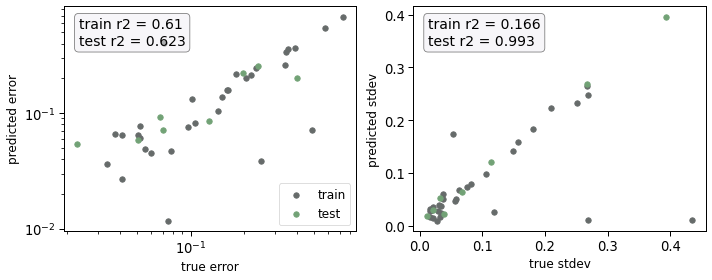

In [67]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))


# particle diameter distance from 300nm
ax0.scatter(train_values[:, 0], train_preds[:, 0], c='#666B6A', s=30, label='train')
ax0.scatter(test_values[:, 0], test_preds[:, 0], c='#72A276', s=30, label='test')

ax0.set_xscale('log')
ax0.set_yscale('log')

ax0.set_xlabel('true error', fontsize=12)
ax0.set_ylabel('predicted error', fontsize=12)

ax0.legend(loc='lower right', fontsize=12)

textstr = f'train r2 = {round(ps_train_r2, 3)}\ntest r2 = {round(ps_test_r2, 3)}'
props = dict(boxstyle='round', facecolor='#f0eff4', alpha=0.5)
ax0.text(
    0.05, 0.95, textstr, transform=ax0.transAxes, fontsize=14,
    verticalalignment='top', bbox=props,
)

# drug loading capacity
ax1.scatter(train_values[:, 1], train_preds[:, 1], c='#666B6A', s=30, label='train')
ax1.scatter(test_values[:, 1], test_preds[:, 1], c='#72A276', s=30, label='test')

ax1.set_xlabel('true stdev', fontsize=12)
ax1.set_ylabel('predicted stdev', fontsize=12)

textstr = f'train r2 = {round(dl_train_r2, 3)}\ntest r2 = {round(dl_test_r2, 3)}'
props = dict(boxstyle='round', facecolor='#f0eff4', alpha=0.5)
ax1.text(
    0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
    verticalalignment='top', bbox=props,
)

plt.tight_layout()


In [58]:
np.where(train_preds[:, 0]<1e-3)

(array([], dtype=int64),)

In [68]:
train_preds

array([[0.13328891, 0.05013297],
       [0.01173758, 0.04712926],
       [0.25997818, 0.01642479],
       [0.33927071, 0.14180961],
       [0.15897456, 0.06816175],
       [0.3570124 , 0.15933308],
       [0.20105587, 0.02830505],
       [0.13709284, 0.07994058],
       [0.36509176, 0.18292673],
       [0.24476154, 0.07421238],
       [0.10374759, 0.06091679],
       [0.21779977, 0.09794331],
       [0.06505979, 0.02831792],
       [0.4021563 , 0.17456836],
       [0.08269638, 0.03564303],
       [0.03615557, 0.00957967],
       [0.06627303, 0.03125659],
       [0.04497092, 0.03828375],
       [0.06440736, 0.03072516],
       [0.07780676, 0.01507081],
       [0.06040864, 0.02394077],
       [0.02689109, 0.03945171],
       [0.04850738, 0.01696435],
       [0.04728813, 0.02524528],
       [0.68537984, 0.2642425 ],
       [0.07155984, 0.01028967],
       [0.07564544, 0.05145489],
       [0.03842036, 0.01078728],
       [0.15924369, 0.2316837 ],
       [0.21404393, 0.22369836],
       [0.

## THF 500 $\mu$L

In [106]:
search_space = {
    'batch_size': hp.quniform('batch_size', 10, 50, 10),
    'hidden_act': hp.choice('hidden_act', ['leaky_relu'] ),
    'hidden_depth': hp.quniform('hidden_depth', 2, 5, 1),
    'hidden_nodes': hp.quniform('hidden_nodes', 28, 64, 4),
    'learning_rate': hp.uniform('learning_rate', 1e-5, 5e-3),
    'reg': hp.uniform('reg', 0.001, 1.0)
}

int_params = ['batch_size', 'hidden_depth', 'hidden_nodes']

all_emulators = []
all_losses = []
all_cv_scores = []
all_params = []

In [107]:
def objective(params):
    ''' average performance over cross-validation folds '''
    # build emualtor
    print(f'PARAMS : {params}')
    for param, val in params.items():
        if param in int_params:
            params[param] = int(val)
    model  = BayesNeuralNet(**params, out_act='linear')
    emulator = Emulator(
        dataset='liquid_thf_500', model=model, 
        feature_transform='standardize', target_transform='standardize',
    )

    cv_scores = emulator.cross_validate()
    loss = np.mean(cv_scores['validate_rmsd'])
    
    all_losses.append(loss)
    all_cv_scores.append(cv_scores)
    all_params.append(params)
    all_emulators.append(emulator)
    
    return {'loss': loss, 'status': STATUS_OK}

In [108]:
trials = Trials()

best = fmin(
    fn=objective,
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=15,
    trials=trials
)

print(f"BEST VALUE : {best}")

PARAMS : {'batch_size': 50.0, 'hidden_act': 'leaky_relu', 'hidden_depth': 3.0, 'hidden_nodes': 28.0, 'learning_rate': 0.004298151216261753, 'reg': 0.0463270184699379}                              
  0%|                                                                                                                                                        | 0/15 [00:00<?, ?trial/s, best loss=?][INFO] >>> Training model on fold #0...


/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.004          1.002         -1.630          0.655 *
[INFO]             100          0.545          0.675         -1.008          0.685
[INFO]             200          0.913          0.295         -0.923          0.631 *
[INFO]             300          0.943          0.238         -0.919          0.637
[INFO]             400          0.967          0.182         -0.874          0.678
[INFO]             500          0.979          0.145         -1.158          0.740
[INFO]             600          0.978          0.149         -0.845          0.666
[INFO]             700          0.989          0.106         -0.716          0.633
[INFO]             800          0.994          0.078         -0.751          0.626 

[INFO]            8600          1.000          0.003         -1.105          0.619
[INFO]            8700          1.000          0.010         -1.196          0.626
[INFO]            8800          1.000          0.007         -1.199          0.629
[INFO]            8900          0.999          0.024         -1.237          0.626
[INFO]            9000          1.000          0.014         -1.199          0.627
[INFO]            9100          1.000          0.019         -1.275          0.636
[INFO]            9200          1.000          0.010         -1.320          0.637
[INFO]            9300          1.000          0.010         -1.239          0.629
[INFO]            9400          1.000          0.009         -1.243          0.631
[INFO]            9500          0.992          0.087         -1.701          0.656
[INFO]            9600          1.000          0.004         -1.572          0.663
[INFO]            9700          1.000          0.002         -1.567          0.662
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0          0.001          0.999         -0.006          0.717 *
[INFO]             100          0.908          0.304         -0.044          0.734
[INFO]             200          0.956          0.209          0.154          0.664 *
[INFO]             300          0.976          0.156          0.148          0.666
[INFO]             400          0.982          0.133          0.107          0.676
[INFO]             500          0.980          0.140          0.129          0.666
[INFO]             600          0.979          0.146          0.110          0.672
[INFO]             700          0.994          0.076         -0.029          0.713
[INFO]             800          0.995          0.067          0.025          0.697


[INFO]            8600          0.999          0.038         -0.060          0.723
[INFO]            8700          1.000          0.006         -0.018          0.710
[INFO]            8800          1.000          0.004         -0.028          0.713
[INFO]            8900          1.000          0.003         -0.030          0.714
[INFO]            9000          1.000          0.008         -0.044          0.719
[INFO]            9100          1.000          0.006         -0.041          0.718
[INFO]            9200          1.000          0.005         -0.039          0.717
[INFO]            9300          1.000          0.009         -0.042          0.718
[INFO]            9400          0.990          0.101         -0.064          0.727
[INFO]            9500          1.000          0.005         -0.058          0.722
[INFO]            9600          1.000          0.002         -0.066          0.725
[INFO]            9700          1.000          0.005         -0.063          0.724
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0          0.014          0.993         -0.074          2.017 *
[INFO]             100          0.775          0.474         -0.122          2.095
[INFO]             200          0.910          0.301         -0.134          2.113
[INFO]             300          0.961          0.198         -0.085          2.091
[INFO]             400          0.979          0.144         -0.048          2.054
[INFO]             500          0.992          0.091         -0.055          2.062
[INFO]             600          0.993          0.084         -0.069          2.086
[INFO]             700          0.997          0.057         -0.075          2.096
[INFO]             800          0.996          0.066         -0.101          2.118
[I

[INFO]            8700          1.000          0.012         -0.068          2.102
[INFO]            8800          1.000          0.006         -0.066          2.102
[INFO]            8900          1.000          0.015         -0.065          2.103
[INFO]            9000          1.000          0.005         -0.069          2.105
[INFO]            9100          1.000          0.009         -0.071          2.107
[INFO]            9200          1.000          0.007         -0.069          2.104
[INFO]            9300          1.000          0.010         -0.071          2.107
[INFO]            9400          1.000          0.021         -0.075          2.108
[INFO]            9500          1.000          0.010         -0.066          2.101
[INFO]            9600          1.000          0.003         -0.069          2.103
[INFO]            9700          1.000          0.005         -0.068          2.103
[INFO]            9800          1.000          0.007         -0.071          2.105
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0          0.001          0.999         -0.011          1.033 *
[INFO]             100          0.712          0.537          0.529          0.718 *
[INFO]             200          0.931          0.263          0.459          0.772
[INFO]             300          0.963          0.193          0.528          0.727
[INFO]             400          0.974          0.162          0.463          0.753
[INFO]             500          0.972          0.166          0.550          0.721
[INFO]             600          0.991          0.093          0.577          0.706 *
[INFO]             700          0.990          0.099          0.495          0.754
[INFO]             800          0.997          0.051          0.507          0.75

[INFO]            8400          1.000          0.004          0.559          0.720
[INFO]            8500          1.000          0.004          0.559          0.720
[INFO]            8600          1.000          0.007          0.560          0.720
[INFO]            8700          1.000          0.006          0.565          0.716
[INFO]            8800          1.000          0.017          0.535          0.738
[INFO]            8900          0.999          0.027          0.590          0.696
[INFO]            9000          1.000          0.008          0.617          0.676
[INFO]            9100          1.000          0.005          0.613          0.680
[INFO]            9200          1.000          0.012          0.604          0.687
[INFO]            9300          1.000          0.008          0.630          0.665
[INFO]            9400          1.000          0.007          0.619          0.675
[INFO]            9500          1.000          0.016          0.623          0.672
[INF

[INFO]           17100          1.000          0.017          0.707          0.596
[INFO]           17200          1.000          0.012          0.720          0.583
[INFO]           17300          1.000          0.004          0.718          0.586
[INFO]           17400          1.000          0.004          0.714          0.589
[INFO]           17500          1.000          0.004          0.717          0.586
[INFO]           17600          1.000          0.018          0.736          0.567 *
[INFO]           17700          0.998          0.039          0.713          0.587
[INFO]           17800          1.000          0.002          0.717          0.586
[INFO]           17900          1.000          0.001          0.719          0.584
[INFO]           18000          1.000          0.002          0.720          0.584
[INFO]           18100          1.000          0.003          0.722          0.582
[INFO]           18200          1.000          0.002          0.720          0.584
[I

[INFO]           26000          1.000          0.007          0.736          0.567
[INFO]           26100          1.000          0.004          0.734          0.568
[INFO]           26200          1.000          0.014          0.722          0.579
[INFO]           26300          0.999          0.023          0.715          0.588
[INFO]           26400          1.000          0.013          0.722          0.579
[INFO]           26500          1.000          0.002          0.725          0.576
[INFO]           26600          1.000          0.002          0.724          0.577
[INFO]           26700          1.000          0.010          0.729          0.573
[INFO]           26800          1.000          0.005          0.723          0.579
[INFO]           26900          1.000          0.010          0.719          0.582
[INFO]           27000          1.000          0.017          0.715          0.586
[INFO]           27100          0.991          0.093          0.713          0.589
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0          0.004          0.998         -0.191          0.747 *
[INFO]             100          0.785          0.464         -0.248          0.757
[INFO]             200          0.940          0.246         -0.154          0.722 *
[INFO]             300          0.960          0.199         -0.456          0.806
[INFO]             400          0.975          0.160          0.058          0.644 *
[INFO]             500          0.989          0.102          0.036          0.655
[INFO]             600          0.982          0.133          0.158          0.612 *
[INFO]             700          0.996          0.063         -0.056          0.678
[INFO]             800          0.967          0.183         -0.459          0.

[INFO]            8600          1.000          0.003         -0.139          0.698
[INFO]            8700          1.000          0.004         -0.126          0.694
[INFO]            8800          1.000          0.007         -0.158          0.703
[INFO]            8900          1.000          0.004         -0.137          0.697
[INFO]            9000          1.000          0.006         -0.147          0.700
[INFO]            9100          1.000          0.005         -0.149          0.701
[INFO]            9200          1.000          0.011         -0.167          0.706
[INFO]            9300          1.000          0.015         -0.176          0.708
[INFO]            9400          1.000          0.008         -0.141          0.699
[INFO]            9500          1.000          0.013         -0.126          0.694
[INFO]            9600          1.000          0.011         -0.161          0.705
[INFO]            9700          1.000          0.018         -0.114          0.692
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.125          1.235         -0.066          1.208 *
[INFO]             100          0.690          0.680          0.491          0.763 *
[INFO]             200          0.716          0.609          0.492          0.860
[INFO]             300          0.604          0.751          0.388          0.940
[INFO]             400          0.422          0.888          0.147          1.019
[INFO]             500          0.304          0.954          0.088          1.087
[INFO]             600          0.024          1.146          0.138          1.056
[INFO]             700          0.229          1.039          0.022          1.086
[INFO]             800         -0.010          1.197          0.248          0.884


[INFO]            8500         -0.095          1.233          0.309          0.934
[INFO]            8600         -0.128          1.237         -0.137          1.125
[INFO]            8700         -0.152          1.262          0.083          1.100
[INFO]            8800         -0.043          1.211         -0.326          1.145
[INFO]            8900          0.174          1.059         -0.017          1.112
[INFO]            9000         -0.052          1.174          0.038          1.151
[INFO]            9100         -0.452          1.356         -0.285          1.262
[INFO]            9200         -0.539          1.416         -0.216          1.278
[INFO]            9300         -0.032          1.198          0.066          1.177
[INFO]            9400         -0.225          1.296         -0.014          1.144
[INFO]            9500         -0.035          1.183         -0.139          1.202
[INFO]            9600         -0.234          1.329         -0.339          1.282
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.044          0.988         -3.310          0.598 *
[INFO]             100          0.547          0.605         -0.395          0.419 *
[INFO]             200          0.622          0.540         -0.726          0.429
[INFO]             300          0.593          0.558         -0.971          0.453
[INFO]             400          0.508          0.710         -1.063          0.492
[INFO]             500          0.238          0.764         -1.262          0.455
[INFO]             600          0.311          0.812         -1.661          0.485
[INFO]             700          0.079          0.903         -1.028          0.466
[INFO]             800          0.155          0.916         -1.173          0.519


[INFO]            8500         -0.221          1.007         -1.751          0.496
[INFO]            8600          0.154          0.932         -0.992          0.413 *
[INFO]            8700         -0.268          0.951         -1.758          0.536
[INFO]            8800          0.079          0.934         -3.946          0.604
[INFO]            8900          0.373          0.820         -1.550          0.544
[INFO]            9000         -0.368          1.100         -1.969          0.569
[INFO]            9100          0.169          0.921         -1.452          0.503
[INFO]            9200         -0.229          1.009         -3.943          0.652
[INFO]            9300          0.061          0.843         -4.972          0.595
[INFO]            9400         -0.527          1.116        -12.569          0.936
[INFO]            9500          0.156          0.927         -0.853          0.520
[INFO]            9600         -0.642          1.209         -7.730          0.748
[I

[INFO]           17400         -0.007          0.993         -2.551          0.558
[INFO]           17500         -0.086          0.979         -4.029          0.783
[INFO]           17600         -0.111          0.972         -5.674          0.740
[INFO]           17700          0.207          0.881         -3.076          0.644
[INFO]           17800         -0.109          1.002         -1.298          0.473
[INFO]           17900          0.084          0.927         -1.568          0.558
[INFO]           18000          0.045          0.979         -1.809          0.746
[INFO]           18100          0.234          0.807         -1.534          0.544
[INFO]           18200         -0.145          0.988         -2.008          0.597
[INFO]           18300         -0.080          0.975         -2.673          0.696
[INFO]           18400         -0.120          1.028         -2.073          0.545
[INFO]           18500          0.169          0.881         -0.409          0.390 *
[I

[INFO]           26300         -0.279          1.119         -3.027          0.544
[INFO]           26400         -0.287          1.089        -11.774          0.941
[INFO]           26500         -0.053          0.992         -1.514          0.860
[INFO]           26600         -0.086          1.012         -1.962          0.533
[INFO]           26700          0.099          0.914         -2.977          0.579
[INFO]           26800          0.028          0.946         -4.696          0.677
[INFO]           26900          0.050          0.994         -2.274          0.529
[INFO]           27000         -0.083          1.006         -3.459          0.614
[INFO]           27100          0.030          0.978         -2.171          0.566
[INFO]           27200         -0.041          1.001         -1.926          0.524
[INFO]           27300          0.015          0.909         -2.623          0.602
[INFO]           27400          0.113          0.900         -4.714          0.677
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0          0.014          0.577         -1.353          0.414 *
[INFO]             100          0.688          0.312         -2.232          0.393 *
[INFO]             200          0.522          0.394         -3.138          0.422
[INFO]             300          0.027          0.539         -3.734          0.427
[INFO]             400          0.280          0.482         -5.504          0.511
[INFO]             500          0.478          0.403         -3.343          0.483
[INFO]             600          0.129          0.528         -7.104          0.577
[INFO]             700          0.147          0.541         -2.034          0.448
[INFO]             800         -0.795          0.753         -4.274          0.601


[INFO]            8600         -0.296          0.644         -3.406          0.524
[INFO]            8700         -1.159          0.829         -9.054          0.697
[INFO]            8800         -0.216          0.616         -1.981          0.380
[INFO]            8900         -0.320          0.670         -5.983          0.623
[INFO]            9000          0.067          0.589         -2.626          0.531
[INFO]            9100         -0.572          0.756         -2.040          0.501
[INFO]            9200          0.393          0.451         -3.104          0.481
[INFO]            9300          0.044          0.570         -2.915          0.475
[INFO]            9400         -3.414          1.154        -12.038          0.859
[INFO]            9500         -0.424          0.686         -9.772          0.694
[INFO]            9600          0.461          0.413         -2.229          0.431
[INFO]            9700          0.003          0.580         -1.941          0.398
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.068          1.575         -0.326          0.959 *
[INFO]             100         -0.136          1.608          0.021          0.804 *
[INFO]             200          0.084          1.477          0.085          0.776 *
[INFO]             300          0.097          1.448          0.167          0.777
[INFO]             400          0.404          1.158          0.022          0.860
[INFO]             500          0.110          1.453         -0.570          1.085
[INFO]             600          0.717          0.807         -0.885          1.167
[INFO]             700          0.180          1.429         -2.296          1.599
[INFO]             800         -0.076          1.581        -10.468          2.87

[INFO]            8500         -0.047          1.527        -43.332          5.121
[INFO]            8600          0.038          1.517        -20.513          4.139
[INFO]            8700         -0.128          1.593        -18.897          3.821
[INFO]            8800         -0.136          1.609        -11.652          3.104
[INFO]            8900          0.007          1.490        -34.951          4.981
[INFO]            9000         -0.161          1.644         -9.599          2.857
[INFO]            9100         -0.190          1.626         -9.140          2.725
[INFO]            9200         -0.198          1.637        -33.823          4.620
[INFO]            9300          0.119          1.391        -23.070          4.036
[INFO]            9400          0.102          1.365        -46.872          5.287
[INFO]            9500         -0.157          1.605        -20.065          3.842
[INFO]            9600          0.055          1.500        -22.213          4.314
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.005          0.695         -0.031          0.541 *
[INFO]             100          0.454          0.505         -0.359          0.569
[INFO]             200          0.042          0.605          0.020          0.500 *
[INFO]             300          0.156          0.576          0.338          0.413 *
[INFO]             400          0.548          0.493          0.426          0.404 *
[INFO]             500          0.030          0.662         -0.366          0.635
[INFO]             600          0.438          0.580          0.362          0.408
[INFO]             700          0.236          0.648          0.318          0.463
[INFO]             800          0.240          0.627          0.267          0.

[INFO]            8700         -0.134          0.722         -0.284          0.630
[INFO]            8800         -0.363          0.803         -0.805          0.670
[INFO]            8900         -0.188          0.731         -0.495          0.654
[INFO]            9000         -0.523          0.846         -0.718          0.748
[INFO]            9100          0.239          0.652         -0.034          0.545
[INFO]            9200         -0.108          0.701         -0.297          0.611
[INFO]            9300         -0.294          0.754          0.250          0.461
[INFO]            9400          0.409          0.600          0.205          0.484
[INFO]            9500         -0.549          0.841         -0.775          0.667
[INFO]            9600         -1.426          0.934         -3.072          0.957
[INFO]            9700         -1.096          0.897         -1.046          0.757
[INFO]            9800         -0.039          0.679         -0.360          0.613
[INF

[INFO]           17500          0.042          0.674         -0.607          0.681
[INFO]           17600          0.214          0.613         -0.075          0.543
[INFO]           17700         -0.428          0.751         -0.653          0.668
[INFO]           17800         -0.286          0.763         -0.723          0.640
[INFO]           17900         -0.256          0.794         -0.111          0.553
[INFO]           18000         -0.142          0.869          0.252          0.450
[INFO]           18100         -0.280          0.849          0.193          0.520
[INFO]           18200         -0.082          0.702         -0.557          0.656
[INFO] Training completed in 19.17 seconds.
[INFO] ===========================================================================

[INFO] Performance statistics based on transformed data [standardize, standardize]:
[INFO] Validation   R2: -0.1157 +/- 0.3246
[INFO] Validation RSMD: 0.5287 +/- 0.0984
PARAMS : {'batch_size': 40.0, 'hidden_a

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.007          0.754         -0.014          1.062 *
[INFO]             100          0.782          0.313         -0.225          1.187
[INFO]             200          0.845          0.300         -0.180          1.168
[INFO]             300          0.868          0.254         -0.128          1.150
[INFO]             400          0.881          0.237         -0.264          1.208
[INFO]             500          0.890          0.227         -0.313          1.243
[INFO]             600          0.902          0.222         -0.178          1.167
[INFO]             700          0.886          0.235         -0.256          1.214
[INFO]             800          0.902          0.225         -0.074          1.107
[I

[INFO]            8600          1.000          0.007         -0.541          1.262
[INFO]            8700          1.000          0.009         -0.537          1.263
[INFO]            8800          1.000          0.016         -0.538          1.265
[INFO]            8900          1.000          0.010         -0.503          1.250
[INFO]            9000          1.000          0.008         -0.530          1.261
[INFO]            9100          1.000          0.005         -0.529          1.260
[INFO]            9200          1.000          0.011         -0.518          1.257
[INFO]            9300          0.999          0.024         -0.516          1.254
[INFO]            9400          1.000          0.008         -0.503          1.256
[INFO]            9500          1.000          0.008         -0.506          1.253
[INFO]            9600          0.999          0.018         -0.511          1.260
[INFO]            9700          1.000          0.009         -0.479          1.246
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.169          0.809         -0.006          1.674 *
[INFO]             100          0.545          0.506         -0.234          1.863
[INFO]             200          0.615          0.466         -0.284          1.903
[INFO]             300          0.626          0.459         -0.297          1.908
[INFO]             400          0.680          0.424         -0.326          1.919
[INFO]             500          0.763          0.363         -0.340          1.959
[INFO]             600          0.807          0.326         -0.292          1.927
[INFO]             700          0.850          0.287         -0.326          1.927
[INFO]             800          0.899          0.235         -0.255          1.912
[I

[INFO]            8600          1.000          0.007         -0.241          1.914
[INFO]            8700          1.000          0.010         -0.237          1.911
[INFO]            8800          0.999          0.017         -0.228          1.905
[INFO]            8900          1.000          0.008         -0.240          1.912
[INFO]            9000          1.000          0.009         -0.231          1.904
[INFO]            9100          1.000          0.008         -0.236          1.908
[INFO]            9200          1.000          0.006         -0.240          1.910
[INFO]            9300          1.000          0.011         -0.235          1.907
[INFO]            9400          1.000          0.008         -0.238          1.912
[INFO]            9500          1.000          0.016         -0.235          1.909
[INFO]            9600          1.000          0.007         -0.236          1.910
[INFO]            9700          1.000          0.006         -0.228          1.905
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.030          1.078         -0.021          0.974 *
[INFO]             100          0.344          0.852          0.345          0.802 *
[INFO]             200          0.627          0.644          0.503          0.698 *
[INFO]             300          0.797          0.479          0.538          0.634 *
[INFO]             400          0.781          0.499          0.473          0.655
[INFO]             500          0.855          0.406          0.595          0.602 *
[INFO]             600          0.825          0.448          0.485          0.666
[INFO]             700          0.861          0.399          0.522          0.623
[INFO]             800          0.816          0.457          0.538          

[INFO]            8500          1.000          0.012          0.011          0.915
[INFO]            8600          1.000          0.015          0.012          0.915
[INFO]            8700          1.000          0.010          0.028          0.905
[INFO]            8800          1.000          0.015          0.024          0.913
[INFO]            8900          1.000          0.010          0.006          0.917
[INFO]            9000          1.000          0.023          0.020          0.911
[INFO]            9100          1.000          0.023          0.030          0.906
[INFO]            9200          1.000          0.013          0.015          0.912
[INFO]            9300          0.999          0.030          0.032          0.904
[INFO]            9400          1.000          0.018          0.037          0.904
[INFO]            9500          1.000          0.012          0.016          0.913
[INFO]            9600          1.000          0.011          0.034          0.906
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.011          1.118         -0.039          0.752 *
[INFO]             100          0.213          0.992         -0.151          0.787
[INFO]             200          0.732          0.590         -0.745          0.982
[INFO]             300          0.940          0.267         -2.430          1.357
[INFO]             400          0.954          0.229         -1.702          1.210
[INFO]             500          0.948          0.247         -1.403          1.145
[INFO]             600          0.969          0.189         -1.839          1.250
[INFO]             700          0.965          0.203         -1.760          1.224
[INFO]             800          0.929          0.298         -5.149          1.802
[I

[INFO]            8600          0.999          0.032         -1.582          1.196
[INFO]            8700          1.000          0.006         -1.358          1.145
[INFO]            8800          1.000          0.019         -1.258          1.122
[INFO]            8900          1.000          0.011         -1.361          1.146
[INFO]            9000          1.000          0.020         -1.474          1.171
[INFO]            9100          1.000          0.010         -1.550          1.189
[INFO]            9200          1.000          0.011         -1.409          1.157
[INFO]            9300          1.000          0.011         -1.445          1.166
[INFO]            9400          1.000          0.023         -1.274          1.126
[INFO]            9500          1.000          0.008         -1.438          1.164
[INFO]            9600          1.000          0.008         -1.413          1.158
[INFO]            9700          0.998          0.048         -1.179          1.104
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.022          1.277         -0.981          0.664 *
[INFO]             100          0.175          1.169         -0.134          0.494 *
[INFO]             200          0.921          0.336         -1.709          0.764
[INFO]             300          0.884          0.424         -1.637          0.795
[INFO]             400          0.939          0.303         -2.759          0.972
[INFO]             500          0.935          0.320         -2.360          0.917
[INFO]             600          0.937          0.306         -5.478          1.304
[INFO]             700          0.929          0.319         -6.276          1.400
[INFO]             800          0.956          0.253         -4.470          1.185


[INFO]            8600          1.000          0.009         -5.199          1.255
[INFO]            8700          1.000          0.012         -5.097          1.242
[INFO]            8800          1.000          0.012         -5.289          1.270
[INFO]            8900          1.000          0.020         -5.307          1.276
[INFO]            9000          0.999          0.030         -5.100          1.251
[INFO]            9100          1.000          0.013         -4.766          1.207
[INFO]            9200          0.998          0.058         -4.537          1.181
[INFO]            9300          1.000          0.014         -5.587          1.302
[INFO]            9400          1.000          0.010         -5.175          1.257
[INFO]            9500          1.000          0.026         -4.961          1.233
[INFO]            9600          0.999          0.043         -5.446          1.288
[INFO]            9700          1.000          0.014         -5.163          1.259
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.135          0.785         -5.136          0.482 *
[INFO]             100          0.540          0.508         -7.448          0.491
[INFO]             200          0.751          0.376         -3.917          0.374 *
[INFO]             300          0.789          0.339        -16.510          0.645
[INFO]             400          0.745          0.374         -7.686          0.452
[INFO]             500          0.822          0.313         -9.263          0.484
[INFO]             600          0.857          0.279         -6.306          0.418
[INFO]             700          0.822          0.312         -3.183          0.361 *
[INFO]             800          0.817          0.317         -5.884          0.43

[INFO]            8600          0.435          0.555         -7.895          0.489
[INFO]            8700          0.547          0.505        -11.515          0.576
[INFO]            8800          0.551          0.500         -3.875          0.401
[INFO]            8900          0.550          0.498         -4.634          0.419
[INFO]            9000          0.647          0.447         -4.673          0.437
[INFO]            9100          0.493          0.529         -5.980          0.433
[INFO]            9200          0.400          0.570         -5.705          0.430
[INFO]            9300          0.346          0.596         -3.923          0.383
[INFO]            9400          0.472          0.538         -2.942          0.379
[INFO]            9500          0.400          0.574         -2.097          0.319 *
[INFO]            9600          0.412          0.565         -3.196          0.360
[INFO]            9700          0.518          0.519         -1.584          0.327
[I

[INFO]           17400          0.394          0.577         -4.382          0.403
[INFO]           17500          0.462          0.543         -7.068          0.483
[INFO]           17600          0.407          0.570         -7.107          0.481
[INFO]           17700          0.421          0.560         -2.822          0.369
[INFO]           17800          0.543          0.499         -2.609          0.378
[INFO]           17900          0.440          0.554         -3.947          0.420
[INFO]           18000          0.526          0.506         -4.310          0.389
[INFO]           18100          0.550          0.498         -2.808          0.354
[INFO]           18200          0.542          0.497         -4.325          0.405
[INFO]           18300          0.584          0.477         -7.020          0.496
[INFO]           18400          0.463          0.543         -3.399          0.389
[INFO]           18500          0.457          0.540         -5.035          0.407
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.242          1.505         -0.046          0.751 *
[INFO]             100          0.646          0.949         -1.265          1.061
[INFO]             200          0.824          0.646         -1.468          1.103
[INFO]             300          0.846          0.543         -1.883          1.189
[INFO]             400          0.840          0.527         -1.649          1.146
[INFO]             500          0.818          0.459         -1.838          1.192
[INFO]             600          0.865          0.388         -1.842          1.183
[INFO]             700          0.860          0.403         -2.194          1.261
[INFO]             800          0.881          0.342         -1.996          1.222
[I

[INFO]            8500          0.700          0.629         -1.998          1.225
[INFO]            8600          0.763          0.509         -3.158          1.441
[INFO]            8700          0.764          0.524         -2.204          1.258
[INFO]            8800          0.751          0.563         -2.137          1.248
[INFO]            8900          0.729          0.660         -1.936          1.207
[INFO]            9000          0.806          0.504         -1.384          1.084
[INFO]            9100          0.794          0.572         -1.552          1.119
[INFO]            9200          0.723          0.592         -2.198          1.264
[INFO]            9300          0.757          0.551         -1.391          1.085
[INFO]            9400          0.738          0.579         -1.843          1.193
[INFO]            9500          0.785          0.587         -1.869          1.186
[INFO]            9600          0.691          0.570         -1.501          1.111
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.129          0.844          0.004          0.888 *
[INFO]             100          0.257          0.676          0.432          0.667 *
[INFO]             200          0.384          0.612          0.510          0.620 *
[INFO]             300          0.501          0.562          0.542          0.601 *
[INFO]             400          0.356          0.627          0.423          0.680
[INFO]             500          0.421          0.596          0.633          0.541 *
[INFO]             600          0.415          0.615          0.285          0.758
[INFO]             700          0.440          0.594          0.401          0.692
[INFO]             800          0.509          0.548          0.443          

[INFO]            8500         -0.011          0.761          0.618          0.548
[INFO]            8600          0.079          0.749          0.553          0.594
[INFO]            8700         -0.226          0.838          0.409          0.682
[INFO]            8800          0.160          0.712          0.638          0.534
[INFO]            8900         -0.172          0.845          0.433          0.667
[INFO]            9000          0.118          0.737          0.710          0.476
[INFO]            9100         -0.114          0.824          0.664          0.514
[INFO]            9200          0.207          0.719          0.634          0.538
[INFO]            9300         -0.148          0.870          0.538          0.603
[INFO]            9400         -0.258          0.843          0.484          0.635
[INFO]            9500          0.023          0.767          0.599          0.561
[INFO]            9600         -0.074          0.824          0.695          0.493
[INF

[INFO]           17400          0.150          0.723          0.488          0.634
[INFO]           17500          0.113          0.736          0.590          0.569
[INFO]           17600         -0.042          0.788          0.553          0.596
[INFO]           17700         -0.059          0.781          0.714          0.474
[INFO]           17800         -0.111          0.807          0.555          0.595
[INFO]           17900         -0.075          0.844          0.601          0.561
[INFO]           18000         -0.109          0.809          0.531          0.608
[INFO]           18100         -0.070          0.786          0.623          0.544
[INFO]           18200          0.117          0.733          0.688          0.498
[INFO]           18300         -0.052          0.775          0.506          0.625
[INFO]           18400          0.032          0.764          0.653          0.523
[INFO]           18500         -0.092          0.807          0.600          0.560
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0          0.019          0.602         -0.118          0.665 *
[INFO]             100          0.456          0.456          0.351          0.510 *
[INFO]             200          0.485          0.441          0.306          0.535
[INFO]             300          0.305          0.487         -0.713          0.803
[INFO]             400          0.602          0.367          0.055          0.633
[INFO]             500          0.696          0.327         -0.178          0.694
[INFO]             600          0.669          0.350          0.350          0.549
[INFO]             700          0.640          0.364          0.046          0.633
[INFO]             800          0.662          0.360          0.287          0.570


[INFO]            8400          0.506          0.434          0.511          0.444
[INFO]            8500          0.515          0.416          0.625          0.412
[INFO]            8600          0.424          0.480          0.497          0.486
[INFO]            8700         -0.047          0.577          0.455          0.503
[INFO]            8800          0.596          0.387          0.403          0.511
[INFO]            8900          0.606          0.374          0.509          0.453
[INFO]            9000          0.232          0.485          0.534          0.464
[INFO]            9100          0.301          0.513          0.487          0.472
[INFO]            9200          0.423          0.469          0.620          0.397
[INFO]            9300          0.423          0.453          0.562          0.414
[INFO]            9400          0.377          0.472          0.444          0.456
[INFO]            9500          0.259          0.500          0.594          0.421
[INF

[INFO] Training completed in 19.85 seconds.
[INFO] ===========================================================================

[INFO] >>> Training model on fold #4...


/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.355          0.617         -1.573          0.641 *
[INFO]             100          0.129          0.441         -1.640          0.573 *
[INFO]             200          0.484          0.324         -1.736          0.569 *
[INFO]             300          0.504          0.316         -1.797          0.585
[INFO]             400          0.554          0.310         -1.540          0.591
[INFO]             500          0.585          0.318         -1.612          0.570
[INFO]             600          0.438          0.321         -1.830          0.581
[INFO]             700          0.570          0.312         -0.686          0.543 *
[INFO]             800          0.567          0.285         -1.038          0.

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.001          1.001         -0.379          0.754 *
[INFO]             100          0.450          0.741          0.605          0.401 *
[INFO]             200          0.885          0.339          0.062          0.628
[INFO]             300          0.894          0.325          0.426          0.497
[INFO]             400          0.898          0.319          0.554          0.442
[INFO]             500          0.904          0.310          0.016          0.642
[INFO]             600          0.933          0.260          0.207          0.580
[INFO]             700          0.936          0.253          0.366          0.529
[INFO]             800          0.960          0.200          0.145          0.605


[INFO]            8600          1.000          0.013         -0.525          0.788
[INFO]            8700          1.000          0.006         -0.559          0.796
[INFO]            8800          1.000          0.008         -0.584          0.802
[INFO]            8900          1.000          0.006         -0.539          0.791
[INFO]            9000          1.000          0.016         -0.629          0.812
[INFO]            9100          1.000          0.006         -0.469          0.773
[INFO]            9200          1.000          0.009         -0.425          0.762
[INFO]            9300          1.000          0.010         -0.432          0.764
[INFO]            9400          1.000          0.013         -0.209          0.704
[INFO]            9500          1.000          0.006         -0.217          0.706
[INFO]            9600          1.000          0.011         -0.253          0.715
[INFO]            9700          1.000          0.007         -0.215          0.705
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.009          1.004         -0.187          1.029 *
[INFO]             100          0.586          0.644          0.057          0.915 *
[INFO]             200          0.911          0.298          0.108          0.891 *
[INFO]             300          0.932          0.261          0.194          0.847 *
[INFO]             400          0.929          0.267          0.305          0.786 *
[INFO]             500          0.943          0.240          0.280          0.800
[INFO]             600          0.949          0.226          0.211          0.838
[INFO]             700          0.957          0.208          0.200          0.845
[INFO]             800          0.971          0.171          0.233          

[INFO]            8600          1.000          0.011          0.074          0.909
[INFO]            8700          1.000          0.008          0.099          0.896
[INFO]            8800          1.000          0.017          0.079          0.906
[INFO]            8900          1.000          0.015          0.072          0.910
[INFO]            9000          0.999          0.024          0.089          0.901
[INFO]            9100          1.000          0.005          0.097          0.898
[INFO]            9200          1.000          0.012          0.110          0.891
[INFO]            9300          1.000          0.005          0.087          0.903
[INFO]            9400          1.000          0.005          0.090          0.901
[INFO]            9500          1.000          0.005          0.075          0.908
[INFO]            9600          1.000          0.006          0.086          0.903
[INFO]            9700          1.000          0.006          0.089          0.901
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.016          1.008         -0.038          1.891 *
[INFO]             100          0.761          0.489         -0.150          2.020
[INFO]             200          0.823          0.420         -0.188          2.048
[INFO]             300          0.874          0.355         -0.228          2.084
[INFO]             400          0.929          0.267         -0.296          2.136
[INFO]             500          0.957          0.206         -0.305          2.139
[INFO]             600          0.957          0.208         -0.408          2.221
[INFO]             700          0.978          0.149         -0.529          2.307
[INFO]             800          0.981          0.137         -0.489          2.284
[I

[INFO]            8600          1.000          0.008         -0.577          2.371
[INFO]            8700          1.000          0.014         -0.572          2.368
[INFO]            8800          1.000          0.007         -0.578          2.371
[INFO]            8900          1.000          0.005         -0.571          2.365
[INFO]            9000          1.000          0.008         -0.577          2.371
[INFO]            9100          0.999          0.030         -0.537          2.341
[INFO]            9200          1.000          0.005         -0.562          2.360
[INFO]            9300          1.000          0.005         -0.573          2.369
[INFO]            9400          1.000          0.006         -0.574          2.368
[INFO]            9500          1.000          0.005         -0.571          2.368
[INFO]            9600          1.000          0.012         -0.557          2.358
[INFO]            9700          1.000          0.014         -0.568          2.363
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.002          1.001         -0.032          0.774 *
[INFO]             100          0.692          0.555         -0.493          0.905
[INFO]             200          0.905          0.309         -1.125          1.055
[INFO]             300          0.928          0.269         -1.364          1.079
[INFO]             400          0.945          0.235         -0.966          0.979
[INFO]             500          0.953          0.217         -1.283          1.074
[INFO]             600          0.974          0.162         -1.067          1.032
[INFO]             700          0.976          0.154         -1.636          1.146
[INFO]             800          0.982          0.136         -1.969          1.220
[I

[INFO]            8600          1.000          0.019         -1.330          1.087
[INFO]            8700          1.000          0.013         -1.372          1.092
[INFO]            8800          1.000          0.004         -1.355          1.088
[INFO]            8900          1.000          0.007         -1.403          1.099
[INFO]            9000          0.999          0.024         -1.506          1.121
[INFO]            9100          0.999          0.023         -1.351          1.089
[INFO]            9200          1.000          0.009         -1.429          1.105
[INFO]            9300          1.000          0.011         -1.424          1.102
[INFO]            9400          1.000          0.012         -1.519          1.121
[INFO]            9500          1.000          0.010         -1.301          1.077
[INFO]            9600          1.000          0.008         -1.355          1.085
[INFO]            9700          1.000          0.004         -1.328          1.081
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.002          1.001         -0.119          0.685 *
[INFO]             100          0.614          0.622          0.575          0.423 *
[INFO]             200          0.866          0.365          0.487          0.464
[INFO]             300          0.880          0.346          0.553          0.433
[INFO]             400          0.891          0.330          0.522          0.448
[INFO]             500          0.910          0.300          0.467          0.473
[INFO]             600          0.918          0.286          0.449          0.481
[INFO]             700          0.944          0.236          0.469          0.473
[INFO]             800          0.953          0.216          0.213          0.575


[INFO]            8600          1.000          0.011          0.111          0.611
[INFO]            8700          1.000          0.016          0.138          0.602
[INFO]            8800          1.000          0.018          0.086          0.620
[INFO]            8900          1.000          0.007          0.127          0.606
[INFO]            9000          1.000          0.010          0.108          0.612
[INFO]            9100          0.998          0.039         -0.001          0.649
[INFO]            9200          1.000          0.009          0.060          0.629
[INFO]            9300          1.000          0.006          0.077          0.623
[INFO]            9400          1.000          0.009          0.072          0.624
[INFO]            9500          1.000          0.006          0.075          0.624
[INFO]            9600          1.000          0.011          0.065          0.627
[INFO]            9700          1.000          0.011          0.048          0.633
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.029          1.176         -0.085          2.022 *
[INFO]             100          0.552          0.769         -0.181          2.117
[INFO]             200          0.795          0.520         -0.274          2.204
[INFO]             300          0.845          0.454         -0.306          2.224
[INFO]             400          0.869          0.418         -0.315          2.226
[INFO]             500          0.862          0.427         -0.325          2.231
[INFO]             600          0.871          0.411         -0.377          2.261
[INFO]             700          0.880          0.398         -0.329          2.226
[INFO]             800          0.900          0.364         -0.341          2.228
[I

[INFO]            8700          0.940          0.282         -0.253          2.173
[INFO]            8800          0.930          0.306         -0.264          2.200
[INFO]            8900          0.939          0.283         -0.211          2.151
[INFO]            9000          0.938          0.286         -0.271          2.200
[INFO]            9100          0.934          0.295         -0.272          2.210
[INFO]            9200          0.935          0.296         -0.235          2.182
[INFO]            9300          0.925          0.317         -0.221          2.169
[INFO]            9400          0.938          0.287         -0.218          2.170
[INFO]            9500          0.927          0.311         -0.238          2.173
[INFO]            9600          0.945          0.269         -0.261          2.201
[INFO]            9700          0.935          0.293         -0.239          2.203
[INFO]            9800          0.954          0.249         -0.232          2.169
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.007          1.182         -0.352          0.878 *
[INFO]             100         -0.018          1.188          0.240          0.672 *
[INFO]             200          0.050          1.146          0.330          0.629 *
[INFO]             300          0.157          1.078          0.188          0.687
[INFO]             400          0.221          1.036          0.221          0.687
[INFO]             500          0.284          0.993          0.216          0.678
[INFO]             600          0.371          0.931          0.214          0.683
[INFO]             700          0.400          0.909          0.145          0.711
[INFO]             800          0.408          0.904          0.053          0.76

[INFO]            8600          0.838          0.477         -0.571          0.989
[INFO]            8700          0.825          0.496         -0.256          0.876
[INFO]            8800          0.889          0.395         -0.543          0.962
[INFO]            8900          0.861          0.443         -0.400          0.919
[INFO]            9000          0.871          0.426         -0.580          0.973
[INFO]            9100          0.854          0.453         -0.424          0.942
[INFO]            9200          0.860          0.444         -0.264          0.869
[INFO]            9300          0.847          0.462         -0.425          0.921
[INFO]            9400          0.883          0.407         -0.617          0.995
[INFO]            9500          0.855          0.449         -0.529          0.966
[INFO]            9600          0.876          0.416         -0.506          0.947
[INFO]            9700          0.859          0.446         -0.467          0.954
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.081          0.774         -0.286          0.579 *
[INFO]             100          0.330          0.608          0.046          0.495 *
[INFO]             200          0.569          0.478          0.160          0.464 *
[INFO]             300          0.587          0.468          0.156          0.467
[INFO]             400          0.654          0.433          0.293          0.425 *
[INFO]             500          0.664          0.422          0.303          0.421 *
[INFO]             600          0.646          0.435          0.217          0.446
[INFO]             700          0.653          0.432          0.043          0.493
[INFO]             800          0.628          0.444         -0.222          

[INFO]            8700          0.673          0.420         -0.685          0.649
[INFO]            8800          0.666          0.421         -0.586          0.630
[INFO]            8900          0.682          0.409         -1.236          0.747
[INFO]            9000          0.717          0.380         -0.852          0.682
[INFO]            9100          0.703          0.390         -1.136          0.731
[INFO]            9200          0.771          0.349         -1.201          0.740
[INFO]            9300          0.704          0.393         -1.034          0.712
[INFO]            9400          0.714          0.380         -0.614          0.634
[INFO]            9500          0.715          0.392         -0.384          0.589
[INFO]            9600          0.688          0.406         -0.618          0.637
[INFO]            9700          0.742          0.366         -0.633          0.640
[INFO]            9800          0.757          0.354         -0.887          0.689
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.009          0.825         -0.163          0.670 *
[INFO]             100          0.276          0.685          0.117          0.584 *
[INFO]             200          0.440          0.588          0.321          0.510 *
[INFO]             300          0.509          0.549          0.337          0.502 *
[INFO]             400          0.472          0.574          0.274          0.522
[INFO]             500          0.495          0.565          0.108          0.576
[INFO]             600          0.517          0.553          0.177          0.555
[INFO]             700          0.473          0.573          0.175          0.554
[INFO]             800          0.458          0.579          0.224          0.

[INFO]            8500          0.730          0.405         -0.711          0.809
[INFO]            8600          0.735          0.415         -1.046          0.883
[INFO]            8700          0.684          0.448         -0.758          0.814
[INFO]            8800          0.745          0.415         -0.591          0.775
[INFO]            8900          0.791          0.365         -0.787          0.822
[INFO]            9000          0.758          0.398         -0.978          0.862
[INFO]            9100          0.775          0.381         -0.655          0.787
[INFO]            9200          0.766          0.383         -1.091          0.894
[INFO]            9300          0.782          0.383         -0.854          0.836
[INFO]            9400          0.756          0.401         -0.491          0.746
[INFO]            9500          0.771          0.378         -1.251          0.923
[INFO]            9600          0.810          0.352         -1.016          0.870
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.007          1.244         -0.008          1.232 *
[INFO]             100          0.077          1.193          0.181          1.108 *
[INFO]             200          0.194          1.119          0.238          1.034 *
[INFO]             300          0.276          1.062          0.210          1.051
[INFO]             400          0.290          1.054          0.378          0.980 *
[INFO]             500          0.369          0.994          0.402          0.952 *
[INFO]             600          0.402          0.968          0.451          0.909 *
[INFO]             700          0.473          0.909          0.623          0.765 *
[INFO]             800          0.542          0.850          0.501      

[INFO]            8600          0.858          0.473          0.504          0.903
[INFO]            8700          0.856          0.474          0.592          0.818
[INFO]            8800          0.833          0.508          0.439          0.975
[INFO]            8900          0.845          0.492          0.521          0.912
[INFO]            9000          0.854          0.475          0.558          0.833
[INFO]            9100          0.880          0.434          0.519          0.932
[INFO]            9200          0.833          0.513          0.387          0.976
[INFO]            9300          0.857          0.472          0.447          0.941
[INFO]            9400          0.861          0.466          0.573          0.861
[INFO]            9500          0.844          0.492          0.568          0.851
[INFO]            9600          0.855          0.472          0.540          0.866
[INFO]            9700          0.863          0.463          0.527          0.919
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0          0.020          0.990         -0.092          0.780 *
[INFO]             100          0.049          0.975         -0.029          0.758 *
[INFO]             200          0.086          0.956          0.022          0.739 *
[INFO]             300          0.118          0.939          0.033          0.735 *
[INFO]             400          0.133          0.931          0.067          0.722 *
[INFO]             500          0.167          0.913          0.096          0.710 *
[INFO]             600          0.203          0.893          0.149          0.689 *
[INFO]             700          0.222          0.882          0.151          0.689 *
[INFO]             800          0.259          0.861          0.176    

[INFO]            8600          0.902          0.313         -1.108          1.086
[INFO]            8700          0.903          0.312         -1.346          1.145
[INFO]            8800          0.909          0.301         -1.278          1.129
[INFO]            8900          0.904          0.310         -1.229          1.117
[INFO]            9000          0.906          0.307         -1.297          1.133
[INFO]            9100          0.905          0.308         -1.299          1.134
[INFO]            9200          0.904          0.309         -1.184          1.105
[INFO]            9300          0.912          0.296         -1.223          1.115
[INFO]            9400          0.913          0.295         -1.318          1.138
[INFO]            9500          0.913          0.295         -1.350          1.146
[INFO]            9600          0.916          0.291         -1.342          1.144
[INFO]            9700          0.917          0.288         -1.252          1.122
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.035          1.017         -0.126          1.974 *
[INFO]             100          0.037          0.982         -0.132          1.981
[INFO]             200          0.109          0.944         -0.135          1.978
[INFO]             300          0.174          0.909         -0.153          1.989
[INFO]             400          0.245          0.869         -0.182          2.016
[INFO]             500          0.326          0.821         -0.227          2.054
[INFO]             600          0.378          0.788         -0.270          2.079
[INFO]             700          0.411          0.768         -0.285          2.095
[INFO]             800          0.440          0.748         -0.317          2.122
[I

[INFO]            8700          0.810          0.436         -0.412          2.217
[INFO]            8800          0.815          0.430         -0.388          2.203
[INFO]            8900          0.824          0.419         -0.404          2.207
[INFO]            9000          0.822          0.422         -0.374          2.192
[INFO]            9100          0.815          0.430         -0.430          2.225
[INFO]            9200          0.833          0.408         -0.389          2.213
[INFO]            9300          0.817          0.428         -0.398          2.205
[INFO]            9400          0.823          0.421         -0.467          2.264
[INFO]            9500          0.824          0.420         -0.418          2.217
[INFO]            9600          0.827          0.416         -0.422          2.228
[INFO]            9700          0.819          0.425         -0.419          2.226
[INFO]            9800          0.826          0.417         -0.432          2.232
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.037          1.019         -0.164          0.718 *
[INFO]             100          0.009          0.995         -0.015          0.678 *
[INFO]             200          0.044          0.978          0.057          0.659 *
[INFO]             300          0.076          0.961          0.076          0.656 *
[INFO]             400          0.103          0.947          0.136          0.638 *
[INFO]             500          0.143          0.926          0.179          0.623 *
[INFO]             600          0.171          0.910          0.189          0.620 *
[INFO]             700          0.195          0.897          0.197          0.622
[INFO]             800          0.231          0.877          0.204      

[INFO]            8700          0.841          0.399         -0.634          0.898
[INFO]            8800          0.832          0.410         -0.450          0.849
[INFO]            8900          0.823          0.421         -0.600          0.887
[INFO]            9000          0.841          0.399         -0.467          0.855
[INFO]            9100          0.836          0.405         -0.480          0.851
[INFO]            9200          0.844          0.395         -0.642          0.890
[INFO]            9300          0.849          0.389         -0.431          0.840
[INFO]            9400          0.856          0.379         -0.497          0.864
[INFO]            9500          0.855          0.381         -0.506          0.856
[INFO]            9600          0.850          0.388         -0.490          0.858
[INFO]            9700          0.862          0.371         -0.491          0.863
[INFO]            9800          0.868          0.363         -0.525          0.860
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.006          1.003          0.002          0.959 *
[INFO]             100          0.039          0.980          0.026          0.947 *
[INFO]             200          0.085          0.957          0.056          0.934 *
[INFO]             300          0.108          0.944          0.095          0.913 *
[INFO]             400          0.149          0.923          0.091          0.915
[INFO]             500          0.187          0.902          0.089          0.917
[INFO]             600          0.213          0.887          0.116          0.900 *
[INFO]             700          0.233          0.876          0.140          0.889 *
[INFO]             800          0.262          0.859          0.147        

[INFO]            8400          0.790          0.459         -0.088          0.980
[INFO]            8500          0.799          0.449         -0.071          0.979
[INFO]            8600          0.820          0.424         -0.046          0.967
[INFO]            8700          0.815          0.430         -0.060          0.972
[INFO]            8800          0.826          0.417         -0.087          0.976
[INFO]            8900          0.843          0.397         -0.029          0.957
[INFO]            9000          0.825          0.419         -0.018          0.949
[INFO]            9100          0.823          0.421         -0.063          0.974
[INFO]            9200          0.823          0.421         -0.102          0.988
[INFO]            9300          0.850          0.387         -0.027          0.954
[INFO]            9400          0.816          0.429         -0.008          0.943
[INFO]            9500          0.852          0.384         -0.040          0.958
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0          0.003          0.998         -0.056          0.707 *
[INFO]             100          0.045          0.977         -0.052          0.710
[INFO]             200          0.085          0.957         -0.002          0.697 *
[INFO]             300          0.124          0.936         -0.014          0.697
[INFO]             400          0.164          0.914          0.069          0.672 *
[INFO]             500          0.202          0.894          0.038          0.686
[INFO]             600          0.222          0.882          0.114          0.658 *
[INFO]             700          0.248          0.867          0.052          0.685
[INFO]             800          0.269          0.855          0.195          0.

[INFO]            8500          0.728          0.522         -0.582          0.897
[INFO]            8600          0.755          0.495         -0.480          0.873
[INFO]            8700          0.734          0.515         -0.610          0.912
[INFO]            8800          0.741          0.508         -0.701          0.937
[INFO]            8900          0.752          0.498         -0.592          0.903
[INFO]            9000          0.745          0.505         -0.453          0.862
[INFO]            9100          0.745          0.505         -0.436          0.859
[INFO]            9200          0.750          0.500         -0.555          0.895
[INFO]            9300          0.755          0.495         -0.519          0.880
[INFO]            9400          0.757          0.493         -0.545          0.883
[INFO]            9500          0.773          0.476         -0.671          0.930
[INFO]            9600          0.778          0.472         -0.578          0.902
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.061          1.113         -0.013          0.916 *
[INFO]             100          0.798          0.483         -0.192          0.917
[INFO]             200          0.820          0.458         -0.549          1.040
[INFO]             300          0.930          0.286         -0.361          0.995
[INFO]             400          0.942          0.261         -0.606          1.066
[INFO]             500          0.915          0.316         -0.390          1.046
[INFO]             600          0.927          0.293         -0.315          0.983
[INFO]             700          0.925          0.297         -0.412          0.954
[INFO]             800          0.947          0.250         -0.545          1.013
[I

[INFO]            8600          1.000          0.016         -1.105          1.113
[INFO]            8700          1.000          0.019         -1.041          1.098
[INFO]            8800          1.000          0.013         -1.072          1.098
[INFO]            8900          1.000          0.020         -1.123          1.107
[INFO]            9000          1.000          0.019         -1.037          1.096
[INFO]            9100          1.000          0.015         -1.030          1.091
[INFO]            9200          1.000          0.018         -1.118          1.105
[INFO]            9300          1.000          0.018         -1.075          1.099
[INFO]            9400          1.000          0.015         -1.042          1.094
[INFO]            9500          1.000          0.012         -1.083          1.102
[INFO]            9600          1.000          0.020         -1.077          1.098
[INFO]            9700          0.999          0.029         -1.092          1.100
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.044          0.897         -0.160          1.409 *
[INFO]             100          0.756          0.388          0.037          1.277 *
[INFO]             200          0.791          0.354          0.014          1.303
[INFO]             300          0.790          0.355         -0.088          1.354
[INFO]             400          0.818          0.326         -0.109          1.376
[INFO]             500          0.839          0.310         -0.020          1.315
[INFO]             600          0.830          0.303         -0.010          1.318
[INFO]             700          0.876          0.276         -0.149          1.379
[INFO]             800          0.846          0.302         -0.050          1.326


[INFO]            8600          1.000          0.017          0.086          1.266
[INFO]            8700          1.000          0.018          0.097          1.261
[INFO]            8800          1.000          0.013          0.091          1.267
[INFO]            8900          0.998          0.034          0.095          1.265
[INFO]            9000          1.000          0.011          0.093          1.265
[INFO]            9100          0.999          0.020          0.091          1.266
[INFO]            9200          1.000          0.017          0.086          1.268
[INFO]            9300          0.999          0.019          0.085          1.269
[INFO]            9400          0.998          0.031          0.090          1.267
[INFO]            9500          1.000          0.013          0.089          1.267
[INFO]            9600          0.999          0.018          0.100          1.260
[INFO]            9700          1.000          0.017          0.079          1.271
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0          0.019          0.884         -0.012          0.899 *
[INFO]             100          0.655          0.527          0.731          0.471 *
[INFO]             200          0.780          0.409          0.669          0.530
[INFO]             300          0.830          0.370          0.593          0.570
[INFO]             400          0.876          0.297          0.629          0.560
[INFO]             500          0.888          0.287          0.599          0.591
[INFO]             600          0.883          0.289          0.612          0.587
[INFO]             700          0.901          0.275          0.634          0.572
[INFO]             800          0.922          0.237          0.615          0.581


[INFO]            8500          1.000          0.017          0.472          0.673
[INFO]            8600          0.999          0.025          0.442          0.693
[INFO]            8700          1.000          0.009          0.455          0.684
[INFO]            8800          1.000          0.015          0.455          0.685
[INFO]            8900          1.000          0.017          0.454          0.686
[INFO]            9000          0.999          0.022          0.449          0.688
[INFO]            9100          1.000          0.017          0.477          0.671
[INFO]            9200          1.000          0.016          0.462          0.680
[INFO]            9300          1.000          0.015          0.465          0.678
[INFO]            9400          1.000          0.015          0.453          0.686
[INFO]            9500          1.000          0.015          0.476          0.672
[INFO]            9600          0.999          0.028          0.488          0.666
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.105          0.735         -0.896          0.578 *
[INFO]             100          0.680          0.401         -2.281          0.815
[INFO]             200          0.768          0.338         -2.067          0.764
[INFO]             300          0.819          0.297         -1.824          0.726
[INFO]             400          0.842          0.278         -1.576          0.722
[INFO]             500          0.878          0.248         -1.633          0.704
[INFO]             600          0.858          0.265         -1.741          0.721
[INFO]             700          0.849          0.271         -1.785          0.744
[INFO]             800          0.869          0.251         -1.559          0.736
[I

[INFO]            8600          0.999          0.019         -2.070          0.806
[INFO]            8700          0.999          0.022         -1.914          0.802
[INFO]            8800          0.999          0.016         -1.872          0.795
[INFO]            8900          0.999          0.019         -1.995          0.806
[INFO]            9000          0.999          0.017         -1.874          0.791
[INFO]            9100          1.000          0.014         -1.991          0.807
[INFO]            9200          1.000          0.015         -1.975          0.805
[INFO]            9300          0.998          0.034         -1.942          0.801
[INFO]            9400          1.000          0.012         -1.942          0.801
[INFO]            9500          1.000          0.013         -1.859          0.787
[INFO]            9600          0.999          0.016         -2.024          0.812
[INFO]            9700          1.000          0.013         -1.897          0.794
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.050          0.925         -0.054          1.321 *
[INFO]             100          0.632          0.570         -0.295          1.383
[INFO]             200          0.748          0.485         -0.890          1.558
[INFO]             300          0.794          0.439         -1.676          1.718
[INFO]             400          0.856          0.365         -1.376          1.706
[INFO]             500          0.861          0.349         -2.105          1.802
[INFO]             600          0.893          0.302         -1.732          1.773
[INFO]             700          0.906          0.283         -1.858          1.748
[INFO]             800          0.901          0.292         -1.090          1.580
[I

[INFO]            8600          1.000          0.015         -2.035          1.792
[INFO]            8700          1.000          0.015         -2.048          1.797
[INFO]            8800          1.000          0.014         -1.941          1.778
[INFO]            8900          1.000          0.012         -1.951          1.784
[INFO]            9000          0.999          0.019         -1.934          1.786
[INFO]            9100          0.999          0.022         -1.974          1.796
[INFO]            9200          1.000          0.017         -1.988          1.793
[INFO]            9300          1.000          0.015         -1.914          1.784
[INFO]            9400          1.000          0.016         -2.011          1.798
[INFO]            9500          1.000          0.015         -1.981          1.794
[INFO]            9600          1.000          0.010         -1.931          1.785
[INFO]            9700          1.000          0.011         -1.995          1.798
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.206          0.823         -0.124          2.166 *
[INFO]             100          0.141          0.693         -0.143          2.185
[INFO]             200          0.673          0.425         -0.271          2.293
[INFO]             300          0.689          0.414         -0.235          2.276
[INFO]             400          0.666          0.428         -0.243          2.282
[INFO]             500          0.689          0.414         -0.238          2.281
[INFO]             600          0.705          0.403         -0.238          2.281
[INFO]             700          0.719          0.393         -0.228          2.272
[INFO]             800          0.711          0.400         -0.189          2.237
[I

[INFO]            8700          0.893          0.245         -0.352          2.333
[INFO]            8800          0.857          0.282         -0.386          2.347
[INFO]            8900          0.867          0.272         -0.357          2.314
[INFO]            9000          0.888          0.249         -0.319          2.304
[INFO]            9100          0.885          0.253         -0.298          2.311
[INFO]            9200          0.867          0.272         -0.298          2.294
[INFO]            9300          0.880          0.258         -0.280          2.305
[INFO]            9400          0.876          0.262         -0.285          2.297
[INFO]            9500          0.888          0.248         -0.292          2.311
[INFO]            9600          0.879          0.259         -0.352          2.329
[INFO]            9700          0.879          0.259         -0.349          2.331
[INFO]            9800          0.894          0.241         -0.346          2.336
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.301          0.771         -6.844          0.679 *
[INFO]             100         -0.100          0.712         -5.799          0.644 *
[INFO]             200          0.368          0.536         -3.700          0.556 *
[INFO]             300          0.628          0.405         -3.133          0.548 *
[INFO]             400          0.718          0.354         -2.537          0.515 *
[INFO]             500          0.660          0.387         -2.643          0.530
[INFO]             600          0.685          0.371         -2.769          0.521
[INFO]             700          0.616          0.409         -3.358          0.561
[INFO]             800          0.683          0.372         -2.372          

[INFO]            8500          0.880          0.239         -0.108          0.393
[INFO]            8600          0.860          0.260         -0.382          0.395
[INFO]            8700          0.848          0.266         -0.370          0.416
[INFO]            8800          0.836          0.274         -0.350          0.393
[INFO]            8900          0.845          0.272         -0.581          0.403
[INFO]            9000          0.862          0.255         -0.289          0.389
[INFO]            9100          0.855          0.258         -0.752          0.443
[INFO]            9200          0.867          0.250         -0.234          0.401
[INFO]            9300          0.868          0.250         -0.328          0.417
[INFO]            9400          0.850          0.268         -0.497          0.428
[INFO]            9500          0.851          0.272         -0.055          0.384
[INFO]            9600          0.866          0.254         -0.643          0.440
[INF

[INFO]           17500          0.905          0.218         -0.131          0.381
[INFO]           17600          0.894          0.229         -0.310          0.403
[INFO]           17700          0.891          0.230         -0.134          0.382
[INFO]           17800          0.903          0.217         -0.164          0.397
[INFO] Training completed in 18.27 seconds.
[INFO] ===========================================================================

[INFO] >>> Training model on fold #2...


/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.064          0.794         -0.175          0.734 *
[INFO]             100          0.136          0.716          0.120          0.625 *
[INFO]             200          0.458          0.572          0.311          0.531 *
[INFO]             300          0.570          0.510          0.372          0.510 *
[INFO]             400          0.639          0.468          0.457          0.483 *
[INFO]             500          0.670          0.448          0.350          0.533
[INFO]             600          0.690          0.434          0.389          0.519
[INFO]             700          0.712          0.419          0.426          0.506
[INFO]             800          0.692          0.434          0.289          

[INFO]            8500          0.847          0.302         -0.147          0.733
[INFO]            8600          0.839          0.311         -0.346          0.810
[INFO]            8700          0.870          0.281         -0.048          0.719
[INFO]            8800          0.848          0.302         -0.133          0.747
[INFO]            8900          0.867          0.283          0.064          0.670
[INFO]            9000          0.847          0.303         -0.196          0.746
[INFO]            9100          0.867          0.281         -0.344          0.813
[INFO]            9200          0.863          0.287         -0.255          0.780
[INFO]            9300          0.865          0.285         -0.182          0.746
[INFO]            9400          0.865          0.283         -0.202          0.742
[INFO]            9500          0.862          0.289         -0.161          0.749
[INFO]            9600          0.877          0.271         -0.255          0.762
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.160          0.704         -1.860          0.440 *
[INFO]             100         -0.014          0.662         -1.833          0.433 *
[INFO]             200          0.423          0.510         -1.942          0.416 *
[INFO]             300          0.439          0.476         -1.902          0.408 *
[INFO]             400          0.421          0.458         -1.930          0.413
[INFO]             500          0.571          0.400         -0.917          0.353 *
[INFO]             600          0.541          0.411         -1.190          0.385
[INFO]             700          0.549          0.402         -1.692          0.419
[INFO]             800          0.584          0.387         -1.581          

[INFO]            8700          0.776          0.285        -10.393          0.819
[INFO]            8800          0.824          0.259        -11.385          0.846
[INFO]            8900          0.844          0.250        -10.819          0.818
[INFO]            9000          0.775          0.275        -10.429          0.805
[INFO]            9100          0.785          0.277         -8.284          0.721
[INFO]            9200          0.782          0.278         -7.749          0.704
[INFO]            9300          0.778          0.275        -11.165          0.828
[INFO]            9400          0.789          0.270         -9.404          0.782
[INFO]            9500          0.799          0.272        -10.871          0.804
[INFO]            9600          0.779          0.270        -11.447          0.851
[INFO]            9700          0.809          0.255        -12.481          0.858
[INFO]            9800          0.790          0.275        -11.944          0.846
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.133          0.680         -0.135          1.361 *
[INFO]             100          0.142          0.600         -0.008          1.286 *
[INFO]             200          0.378          0.512          0.207          1.104 *
[INFO]             300          0.616          0.403          0.264          1.020 *
[INFO]             400          0.685          0.367          0.266          1.005 *
[INFO]             500          0.742          0.336          0.193          1.045
[INFO]             600          0.735          0.335          0.110          1.107
[INFO]             700          0.787          0.301          0.010          1.157
[INFO]             800          0.797          0.296          0.115          

[INFO]            8500          0.852          0.252          0.298          1.020
[INFO]            8600          0.841          0.259          0.299          0.990
[INFO]            8700          0.808          0.286          0.297          1.005
[INFO]            8800          0.860          0.247          0.259          1.039
[INFO]            8900          0.839          0.260          0.281          1.000
[INFO]            9000          0.842          0.260          0.236          1.062
[INFO]            9100          0.805          0.287          0.239          1.037
[INFO]            9200          0.838          0.262          0.235          1.032
[INFO]            9300          0.805          0.288          0.287          1.011
[INFO]            9400          0.848          0.253          0.239          1.041
[INFO]            9500          0.822          0.277          0.323          0.977
[INFO]            9600          0.841          0.261          0.272          1.030
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.124          0.933         -0.069          1.298 *
[INFO]             100          0.605          0.493          0.584          0.831 *
[INFO]             200          0.739          0.404          0.685          0.720 *
[INFO]             300          0.798          0.357          0.596          0.818
[INFO]             400          0.789          0.391          0.657          0.759
[INFO]             500          0.720          0.433          0.626          0.790
[INFO]             600          0.598          0.553          0.552          0.864
[INFO]             700          0.681          0.493          0.536          0.880
[INFO]             800          0.605          0.538          0.710          0.69

[INFO]            8600         -0.615          0.972          0.684          0.711
[INFO]            8700          0.315          0.710          0.636          0.755
[INFO]            8800          0.252          0.681          0.413          0.952
[INFO]            8900          0.232          0.735          0.630          0.770
[INFO]            9000          0.093          0.795          0.604          0.807
[INFO]            9100          0.054          0.792          0.571          0.835
[INFO]            9200          0.282          0.736          0.666          0.729
[INFO]            9300          0.184          0.745          0.585          0.807
[INFO]            9400         -0.028          0.841          0.542          0.845
[INFO]            9500         -0.146          0.865          0.590          0.830
[INFO]            9600          0.135          0.720          0.536          0.852
[INFO]            9700         -0.052          0.814          0.600          0.805
[INF

[INFO]           17400          0.150          0.762          0.632          0.780
[INFO]           17500          0.262          0.709          0.506          0.884
[INFO]           17600          0.028          0.812          0.517          0.875
[INFO]           17700          0.183          0.730          0.542          0.827
[INFO]           17800         -0.090          0.869          0.583          0.825
[INFO]           17900          0.117          0.746          0.567          0.822
[INFO]           18000          0.096          0.771          0.755          0.623
[INFO]           18100          0.097          0.740          0.731          0.661
[INFO]           18200         -0.026          0.821          0.611          0.776
[INFO]           18300         -0.083          0.834          0.792          0.579 *
[INFO]           18400          0.283          0.699          0.413          0.964
[INFO]           18500          0.014          0.794          0.528          0.882
[I

[INFO]           26200          0.145          0.794          0.335          1.031
[INFO]           26300          0.268          0.732          0.611          0.799
[INFO]           26400         -0.218          0.844          0.717          0.676
[INFO]           26500         -0.151          0.847          0.578          0.837
[INFO]           26600         -0.015          0.818          0.720          0.682
[INFO]           26700          0.291          0.721          0.709          0.673
[INFO]           26800          0.026          0.815          0.741          0.624
[INFO]           26900         -0.124          0.824          0.617          0.774
[INFO]           27000          0.119          0.787          0.463          0.891
[INFO]           27100          0.271          0.728          0.765          0.612
[INFO]           27200          0.188          0.747          0.745          0.643
[INFO]           27300          0.205          0.718          0.736          0.638
[INF

[INFO]           35000          0.211          0.708          0.647          0.744
[INFO]           35100          0.542          0.555          0.444          0.921
[INFO]           35200          0.131          0.753          0.645          0.763
[INFO]           35300          0.255          0.678          0.594          0.799
[INFO]           35400          0.058          0.758          0.456          0.940
[INFO]           35500         -0.153          0.853          0.520          0.860
[INFO]           35600         -0.020          0.853          0.541          0.864
[INFO]           35700          0.304          0.716          0.687          0.715
[INFO]           35800          0.172          0.720          0.513          0.864
[INFO]           35900          0.146          0.802          0.397          0.999
[INFO]           36000         -0.126          0.829          0.665          0.737
[INFO]           36100         -0.148          0.854          0.640          0.772
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.067          0.881         -0.013          1.047 *
[INFO]             100          0.857          0.325         -0.289          1.167
[INFO]             200          0.850          0.336         -0.302          1.183
[INFO]             300          0.826          0.351         -0.262          1.184
[INFO]             400          0.858          0.320         -0.595          1.267
[INFO]             500          0.877          0.302         -0.109          1.100
[INFO]             600          0.827          0.355         -0.156          1.105
[INFO]             700          0.679          0.493         -0.084          1.075
[INFO]             800          0.811          0.373         -0.006          1.062
[I

[INFO]            8600          0.777          0.404         -1.258          1.375
[INFO]            8700          0.689          0.469          0.102          0.998
[INFO]            8800          0.624          0.517         -1.847          1.555
[INFO]            8900          0.788          0.394         -0.375          1.181
[INFO]            9000          0.639          0.511          0.110          1.008
[INFO]            9100          0.763          0.408         -0.908          1.279
[INFO]            9200          0.789          0.393          0.078          1.011
[INFO]            9300          0.722          0.444          0.154          0.997
[INFO]            9400          0.715          0.452          0.328          0.914
[INFO]            9500          0.721          0.444         -0.448          1.222
[INFO]            9600          0.588          0.535          0.002          1.079
[INFO]            9700          0.689          0.475         -0.265          1.138
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.339          0.870         -1.666          0.748 *
[INFO]             100          0.715          0.376         -4.680          0.815
[INFO]             200          0.889          0.246         -3.924          0.816
[INFO]             300          0.855          0.276         -3.849          0.793
[INFO]             400          0.878          0.262         -2.637          0.740 *
[INFO]             500          0.902          0.226         -6.105          0.927
[INFO]             600          0.805          0.319         -2.647          0.703 *
[INFO]             700          0.823          0.316         -1.874          0.678 *
[INFO]             800          0.689          0.428         -2.420          0.

[INFO]           17200          0.570          0.504         -2.523          0.667
[INFO]           17300          0.650          0.462         -2.221          0.606
[INFO]           17400          0.708          0.409         -2.242          0.639
[INFO]           17500          0.708          0.407         -2.279          0.655
[INFO]           17600          0.685          0.427         -1.842          0.620
[INFO]           17700          0.652          0.437         -1.180          0.548
[INFO]           17800          0.638          0.455         -1.961          0.591
[INFO]           17900          0.691          0.423         -1.969          0.640
[INFO]           18000          0.738          0.384         -1.718          0.615
[INFO]           18100          0.596          0.483         -2.298          0.632
[INFO]           18200          0.641          0.453         -2.033          0.619
[INFO]           18300          0.593          0.503         -2.360          0.657
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.027          0.928         -0.298          0.873 *
[INFO]             100          0.698          0.499         -0.036          0.743 *
[INFO]             200          0.734          0.468         -0.220          0.796
[INFO]             300          0.744          0.454          0.156          0.656 *
[INFO]             400          0.799          0.407         -0.238          0.804
[INFO]             500          0.770          0.436          0.152          0.674
[INFO]             600          0.764          0.447         -0.127          0.755
[INFO]             700          0.739          0.468         -0.015          0.707
[INFO]             800          0.712          0.495          0.170          0.66

[INFO]            8400          0.683          0.519          0.520          0.517
[INFO]            8500          0.687          0.514          0.463          0.543
[INFO]            8600          0.624          0.554          0.528          0.518
[INFO]            8700          0.665          0.532          0.568          0.480 *
[INFO]            8800          0.665          0.532          0.484          0.514
[INFO]            8900          0.710          0.500          0.310          0.600
[INFO]            9000          0.672          0.517          0.521          0.513
[INFO]            9100          0.700          0.497          0.440          0.557
[INFO]            9200          0.635          0.557          0.591          0.466 *
[INFO]            9300          0.507          0.639          0.539          0.515
[INFO]            9400          0.746          0.460          0.520          0.515
[INFO]            9500          0.673          0.524          0.280          0.623


[INFO]           17200          0.665          0.539          0.116          0.667
[INFO]           17300          0.587          0.579          0.247          0.624
[INFO]           17400          0.719          0.492          0.324          0.600
[INFO]           17500          0.701          0.504          0.071          0.682
[INFO]           17600          0.687          0.521          0.560          0.490
[INFO]           17700          0.673          0.523          0.470          0.531
[INFO]           17800          0.602          0.579          0.174          0.657
[INFO]           17900          0.606          0.581          0.535          0.511
[INFO]           18000          0.651          0.545          0.331          0.588
[INFO]           18100          0.726          0.473          0.398          0.558
[INFO]           18200          0.677          0.522          0.416          0.545
[INFO]           18300          0.704          0.494          0.294          0.605
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.441          0.678         -0.082          1.248 *
[INFO]             100          0.532          0.392          0.569          0.879 *
[INFO]             200          0.562          0.378          0.584          0.849 *
[INFO]             300          0.579          0.369          0.547          0.902
[INFO]             400          0.599          0.361          0.455          0.956
[INFO]             500          0.672          0.328          0.515          0.889
[INFO]             600          0.480          0.416          0.448          0.945
[INFO]             700          0.602          0.369          0.621          0.844 *
[INFO]             800          0.519          0.395          0.482          0.

[INFO]            8600          0.350          0.452          0.523          0.893
[INFO]            8700          0.416          0.437          0.455          0.941
[INFO]            8800          0.531          0.398          0.393          0.992
[INFO]            8900          0.508          0.401          0.509          0.896
[INFO]            9000          0.406          0.430          0.354          0.980
[INFO]            9100          0.395          0.448          0.477          0.970
[INFO]            9200          0.225          0.486          0.597          0.865
[INFO]            9300          0.375          0.437          0.485          0.934
[INFO]            9400          0.320          0.449          0.404          1.014
[INFO]            9500          0.174          0.510          0.377          0.977
[INFO]            9600          0.426          0.433          0.607          0.822 *
[INFO]            9700          0.550          0.387          0.380          0.984
[I

[INFO]           17400          0.213          0.489          0.335          1.004
[INFO]           17500          0.561          0.384          0.458          0.950
[INFO]           17600          0.296          0.463          0.420          0.928
[INFO]           17700          0.373          0.452          0.547          0.853
[INFO]           17800          0.352          0.454          0.373          0.973
[INFO]           17900          0.308          0.472          0.459          0.978
[INFO]           18000          0.309          0.462          0.486          0.919
[INFO]           18100          0.339          0.457          0.488          0.936
[INFO]           18200          0.476          0.412          0.471          0.927
[INFO]           18300          0.252          0.473          0.449          0.989
[INFO]           18400          0.504          0.416          0.554          0.878
[INFO]           18500          0.476          0.402          0.561          0.878
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.017          0.777         -0.121          0.991 *
[INFO]             100          0.219          0.678         -0.357          1.015
[INFO]             200          0.574          0.510         -0.588          1.079
[INFO]             300          0.607          0.491         -0.820          1.053
[INFO]             400          0.523          0.546         -1.070          1.079
[INFO]             500          0.661          0.461         -1.959          1.133
[INFO]             600          0.677          0.448         -1.749          1.149
[INFO]             700          0.754          0.395         -3.078          1.287
[INFO]             800          0.714          0.420         -0.959          1.064
[I

[INFO]            8600          0.999          0.029         -3.465          1.459
[INFO]            8700          0.998          0.032         -3.211          1.420
[INFO]            8800          0.998          0.033         -3.534          1.483
[INFO]            8900          0.998          0.035         -2.847          1.409
[INFO]            9000          0.998          0.035         -3.130          1.425
[INFO]            9100          0.999          0.026         -3.378          1.460
[INFO]            9200          0.999          0.027         -3.383          1.435
[INFO]            9300          0.998          0.035         -3.312          1.432
[INFO]            9400          0.999          0.029         -3.576          1.462
[INFO]            9500          0.999          0.026         -3.192          1.431
[INFO]            9600          0.998          0.033         -3.194          1.431
[INFO]            9700          0.997          0.038         -2.976          1.415
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.001          1.071         -0.546          0.561 *
[INFO]             100          0.373          0.850         -0.473          0.531 *
[INFO]             200          0.821          0.450         -0.020          0.444 *
[INFO]             300          0.829          0.440          0.310          0.357 *
[INFO]             400          0.838          0.426         -0.395          0.528
[INFO]             500          0.880          0.366         -0.160          0.483
[INFO]             600          0.841          0.423         -0.256          0.502
[INFO]             700          0.886          0.357         -0.530          0.562
[INFO]             800          0.840          0.428         -1.570          0.

[INFO]            8500          0.998          0.050         -1.237          0.665
[INFO]            8600          0.997          0.060         -1.184          0.660
[INFO]            8700          0.998          0.052         -1.467          0.703
[INFO]            8800          0.999          0.031         -1.169          0.657
[INFO]            8900          0.999          0.039         -1.171          0.656
[INFO]            9000          0.999          0.025         -1.075          0.640
[INFO]            9100          0.998          0.049         -1.125          0.651
[INFO]            9200          0.998          0.042         -0.985          0.623
[INFO]            9300          0.999          0.037         -1.227          0.664
[INFO]            9400          0.998          0.043         -1.200          0.660
[INFO]            9500          0.999          0.041         -1.102          0.644
[INFO]            9600          0.998          0.044         -0.985          0.623
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.073          1.045         -0.213          2.503 *
[INFO]             100          0.836          0.407         -0.235          2.598
[INFO]             200          0.888          0.337         -0.179          2.561
[INFO]             300          0.848          0.393         -0.201          2.566
[INFO]             400          0.902          0.315         -0.176          2.535
[INFO]             500          0.907          0.306         -0.201          2.554
[INFO]             600          0.891          0.333         -0.178          2.542
[INFO]             700          0.916          0.291         -0.216          2.566
[INFO]             800          0.915          0.293         -0.199          2.532
[I

[INFO]            8600          0.999          0.027         -0.317          2.655
[INFO]            8700          1.000          0.021         -0.314          2.645
[INFO]            8800          1.000          0.022         -0.310          2.643
[INFO]            8900          1.000          0.015         -0.320          2.662
[INFO]            9000          0.999          0.028         -0.307          2.643
[INFO]            9100          0.999          0.024         -0.312          2.641
[INFO]            9200          0.999          0.037         -0.300          2.637
[INFO]            9300          0.999          0.024         -0.305          2.630
[INFO]            9400          0.999          0.031         -0.329          2.638
[INFO]            9500          0.999          0.023         -0.295          2.625
[INFO]            9600          1.000          0.022         -0.298          2.617
[INFO]            9700          0.999          0.025         -0.296          2.613
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.101          1.406         -0.257          0.685 *
[INFO]             100          0.458          0.996          0.355          0.479 *
[INFO]             200          0.881          0.459          0.280          0.501
[INFO]             300          0.870          0.482          0.142          0.558
[INFO]             400          0.838          0.536          0.109          0.565
[INFO]             500          0.831          0.548         -0.135          0.634
[INFO]             600          0.851          0.515          0.226          0.528
[INFO]             700          0.866          0.489          0.082          0.573
[INFO]             800          0.774          0.643          0.139          0.560


[INFO]            8600          0.989          0.145         -0.585          0.760
[INFO]            8700          0.999          0.031         -0.598          0.760
[INFO]            8800          0.998          0.066         -0.628          0.768
[INFO]            8900          0.999          0.037         -0.530          0.744
[INFO]            9000          0.998          0.058         -0.593          0.759
[INFO]            9100          0.997          0.074         -0.606          0.764
[INFO]            9200          0.999          0.038         -0.526          0.743
[INFO]            9300          0.998          0.055         -0.566          0.753
[INFO]            9400          0.999          0.041         -0.566          0.753
[INFO]            9500          0.999          0.037         -0.528          0.744
[INFO]            9600          0.999          0.040         -0.577          0.754
[INFO]            9700          0.999          0.040         -0.611          0.765
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0          0.010          0.795          0.004          0.821 *
[INFO]             100          0.622          0.445          0.794          0.334 *
[INFO]             200          0.441          0.489         -3.108          1.474
[INFO]             300          0.667          0.403         -1.615          1.189
[INFO]             400          0.737          0.371         -0.712          0.958
[INFO]             500          0.667          0.412          0.365          0.570
[INFO]             600          0.669          0.412          0.169          0.652
[INFO]             700          0.677          0.401         -0.458          0.861
[INFO]             800          0.684          0.400         -0.424          0.843


[INFO]            8500          0.997          0.031         -1.349          1.108
[INFO]            8600          0.997          0.038         -1.212          1.077
[INFO]            8700          0.995          0.039         -1.070          1.046
[INFO]            8800          0.997          0.034         -0.979          1.021
[INFO]            8900          0.998          0.029         -1.350          1.110
[INFO]            9000          0.998          0.026         -1.220          1.079
[INFO]            9100          0.995          0.058         -1.345          1.113
[INFO]            9200          0.999          0.024         -1.077          1.045
[INFO]            9300          0.998          0.028         -1.472          1.136
[INFO]            9400          0.997          0.031         -1.343          1.106
[INFO]            9500          0.998          0.041         -1.061          1.044
[INFO]            9600          0.998          0.031         -1.020          1.029
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.141          1.329         -0.050          1.939 *
[INFO]             100          0.465          0.955         -0.259          2.125
[INFO]             200          0.597          0.823         -0.301          2.174
[INFO]             300          0.642          0.768         -0.252          2.132
[INFO]             400          0.701          0.682         -0.211          2.106
[INFO]             500          0.740          0.637         -0.232          2.125
[INFO]             600          0.770          0.587         -0.256          2.130
[INFO]             700          0.757          0.609         -0.229          2.109
[INFO]             800          0.774          0.563         -0.238          2.130
[I

[INFO]            8700          0.796          0.541         -0.275          2.095
[INFO]            8800          0.809          0.520         -0.306          2.137
[INFO]            8900          0.840          0.488         -0.235          2.089
[INFO]            9000          0.822          0.505         -0.270          2.122
[INFO]            9100          0.824          0.501         -0.207          2.084
[INFO]            9200          0.776          0.573         -0.230          2.099
[INFO]            9300          0.818          0.534         -0.280          2.122
[INFO]            9400          0.803          0.527         -0.262          2.115
[INFO]            9500          0.823          0.514         -0.277          2.137
[INFO]            9600          0.805          0.542         -0.305          2.165
[INFO]            9700          0.807          0.529         -0.282          2.153
[INFO]            9800          0.831          0.507         -0.242          2.104
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.096          1.113         -2.538          0.482 *
[INFO]             100          0.442          0.803         -3.067          0.465 *
[INFO]             200          0.637          0.638         -4.219          0.512
[INFO]             300          0.706          0.573         -3.955          0.505
[INFO]             400          0.748          0.511         -5.596          0.576
[INFO]             500          0.762          0.506         -4.961          0.563
[INFO]             600          0.750          0.511         -4.538          0.542
[INFO]             700          0.795          0.457         -5.286          0.580
[INFO]             800          0.811          0.440         -5.131          0.571


[INFO]            8500          0.817          0.446         -3.369          0.490
[INFO]            8600          0.809          0.456         -3.072          0.474
[INFO]            8700          0.852          0.397         -2.570          0.442
[INFO]            8800          0.810          0.458         -2.519          0.464
[INFO]            8900          0.823          0.437         -1.986          0.431
[INFO]            9000          0.789          0.469         -2.419          0.459
[INFO]            9100          0.825          0.442         -4.110          0.512
[INFO]            9200          0.785          0.483         -1.903          0.433
[INFO]            9300          0.825          0.434         -2.637          0.450
[INFO]            9400          0.863          0.386         -2.544          0.473
[INFO]            9500          0.859          0.392         -3.810          0.531
[INFO]            9600          0.805          0.484         -1.868          0.455
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.057          0.803         -0.004          0.954 *
[INFO]             100          0.501          0.586          0.161          0.862 *
[INFO]             200          0.649          0.471          0.137          0.838 *
[INFO]             300          0.703          0.407          0.002          0.883
[INFO]             400          0.740          0.370         -0.213          0.928
[INFO]             500          0.724          0.377         -0.377          0.995
[INFO]             600          0.762          0.343         -0.356          0.984
[INFO]             700          0.725          0.373         -0.488          1.012
[INFO]             800          0.686          0.397         -0.453          0.98

[INFO]            8600          0.758          0.352         -0.074          0.935
[INFO]            8700          0.790          0.320         -0.265          0.956
[INFO]            8800          0.764          0.337         -0.093          0.936
[INFO]            8900          0.768          0.341         -0.258          1.000
[INFO]            9000          0.771          0.341         -0.134          0.945
[INFO]            9100          0.686          0.384          0.025          0.895
[INFO]            9200          0.797          0.327         -0.124          0.990
[INFO]            9300          0.723          0.376         -0.111          0.957
[INFO]            9400          0.745          0.354         -0.353          1.005
[INFO]            9500          0.705          0.377         -0.108          0.948
[INFO]            9600          0.734          0.356         -0.027          0.927
[INFO]            9700          0.771          0.330         -0.042          0.928
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.188          0.616          0.091          0.626 *
[INFO]             100          0.391          0.442          0.392          0.509 *
[INFO]             200          0.468          0.412          0.266          0.538
[INFO]             300          0.514          0.396          0.147          0.577
[INFO]             400          0.448          0.421          0.079          0.598
[INFO]             500          0.461          0.416         -0.010          0.626
[INFO]             600          0.264          0.481          0.008          0.632
[INFO]             700          0.418          0.428          0.016          0.627
[INFO]             800          0.360          0.450          0.131          0.588


[INFO]            8600          0.479          0.414         -0.584          0.789
[INFO]            8700          0.451          0.421         -0.480          0.767
[INFO]            8800          0.564          0.380         -0.141          0.668
[INFO]            8900          0.458          0.422         -0.545          0.769
[INFO]            9000          0.529          0.395         -0.405          0.756
[INFO]            9100          0.516          0.397         -0.390          0.735
[INFO]            9200          0.431          0.429         -0.634          0.807
[INFO]            9300          0.531          0.393         -0.849          0.839
[INFO]            9400          0.479          0.410         -0.653          0.807
[INFO]            9500          0.467          0.416         -0.847          0.883
[INFO]            9600          0.584          0.371         -0.263          0.720
[INFO]            9700          0.548          0.386         -1.286          0.943
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.108          0.774         -0.186          1.153 *
[INFO]             100          0.409          0.565          0.075          1.024 *
[INFO]             200          0.519          0.510          0.290          0.877 *
[INFO]             300          0.615          0.456          0.372          0.822 *
[INFO]             400          0.598          0.466          0.354          0.827
[INFO]             500          0.582          0.475          0.331          0.835
[INFO]             600          0.521          0.509          0.202          0.913
[INFO]             700          0.485          0.528          0.207          0.924
[INFO]             800          0.441          0.549          0.107          0.

[INFO]            8700          0.623          0.451          0.301          0.918
[INFO]            8800          0.653          0.433          0.135          0.968
[INFO]            8900          0.630          0.447          0.241          0.927
[INFO]            9000          0.648          0.436          0.308          0.896
[INFO]            9100          0.603          0.463          0.245          0.937
[INFO]            9200          0.656          0.431          0.199          0.988
[INFO]            9300          0.617          0.455          0.196          0.998
[INFO]            9400          0.583          0.475          0.272          0.953
[INFO]            9500          0.653          0.433          0.126          1.046
[INFO]            9600          0.578          0.478          0.289          0.914
[INFO]            9700          0.639          0.442          0.154          0.987
[INFO]            9800          0.600          0.465          0.199          0.966
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.065          1.282         -0.841          0.619 *
[INFO]             100          0.432          0.941         -0.070          0.468 *
[INFO]             200          0.850          0.478         -0.386          0.529
[INFO]             300          0.902          0.386         -0.436          0.534
[INFO]             400          0.887          0.416         -0.548          0.551
[INFO]             500          0.880          0.432         -0.226          0.492
[INFO]             600          0.902          0.388         -0.628          0.575
[INFO]             700          0.898          0.398         -0.425          0.534
[INFO]             800          0.857          0.471         -0.908          0.607


[INFO]            8600          0.924          0.342         -4.414          1.063
[INFO]            8700          0.937          0.312         -2.442          0.838
[INFO]            8800          0.942          0.297         -3.586          0.980
[INFO]            8900          0.942          0.296         -4.449          1.063
[INFO]            9000          0.948          0.282         -2.650          0.882
[INFO]            9100          0.942          0.300         -4.438          1.074
[INFO]            9200          0.940          0.301         -3.017          0.923
[INFO]            9300          0.918          0.355         -3.375          0.957
[INFO]            9400          0.938          0.308         -2.658          0.874
[INFO]            9500          0.911          0.370         -2.044          0.795
[INFO]            9600          0.941          0.300         -2.372          0.845
[INFO]            9700          0.894          0.407         -2.148          0.810
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.013          1.540         -0.043          1.016 *
[INFO]             100          0.617          0.936          0.120          0.921 *
[INFO]             200          0.959          0.300          0.324          0.815 *
[INFO]             300          0.961          0.292          0.133          0.926
[INFO]             400          0.971          0.253          0.103          0.948
[INFO]             500          0.923          0.414          0.287          0.838
[INFO]             600          0.965          0.275          0.275          0.843
[INFO]             700          0.932          0.399          0.282          0.837
[INFO]             800          0.914          0.438          0.107          0.94

[INFO]            8600          0.965          0.279          0.221          0.882
[INFO]            8700          0.958          0.302          0.120          0.942
[INFO]            8800          0.968          0.266          0.297          0.826
[INFO]            8900          0.960          0.300          0.268          0.850
[INFO]            9000          0.960          0.298          0.104          0.950
[INFO]            9100          0.963          0.283          0.249          0.862
[INFO]            9200          0.962          0.292          0.331          0.812
[INFO]            9300          0.945          0.352          0.318          0.819
[INFO]            9400          0.952          0.323          0.259          0.854
[INFO]            9500          0.967          0.268          0.308          0.829
[INFO]            9600          0.968          0.261          0.236          0.863
[INFO]            9700          0.969          0.258          0.271          0.843
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.160          0.755          0.007          0.616 *
[INFO]             100          0.303          0.577          0.379          0.481 *
[INFO]             200          0.454          0.512          0.396          0.456 *
[INFO]             300          0.484          0.503          0.382          0.466
[INFO]             400          0.452          0.518          0.254          0.482
[INFO]             500          0.507          0.490          0.247          0.492
[INFO]             600          0.490          0.499          0.202          0.503
[INFO]             700          0.493          0.495          0.341          0.478
[INFO]             800          0.489          0.494          0.259          0.49

[INFO]            8600          0.510          0.487          0.321          0.458
[INFO]            8700          0.493          0.496          0.281          0.474
[INFO]            8800          0.513          0.488          0.411          0.435
[INFO]            8900          0.493          0.495          0.362          0.458
[INFO]            9000          0.457          0.511          0.413          0.429
[INFO]            9100          0.523          0.480          0.268          0.486
[INFO]            9200          0.484          0.502          0.381          0.454
[INFO]            9300          0.514          0.484          0.133          0.513
[INFO]            9400          0.436          0.526          0.156          0.494
[INFO]            9500          0.494          0.496          0.379          0.444
[INFO]            9600          0.471          0.508          0.315          0.455
[INFO]            9700          0.497          0.493          0.337          0.461
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.043          0.995         -0.203          2.274 *
[INFO]             100          0.445          0.733         -0.239          2.302
[INFO]             200          0.586          0.634         -0.299          2.351
[INFO]             300          0.682          0.555         -0.336          2.381
[INFO]             400          0.782          0.459         -0.409          2.442
[INFO]             500          0.847          0.384         -0.355          2.396
[INFO]             600          0.833          0.400         -0.331          2.381
[INFO]             700          0.909          0.293         -0.352          2.401
[INFO]             800          0.883          0.335         -0.283          2.338
[I

[INFO]            8600          0.968          0.175         -0.388          2.423
[INFO]            8700          0.956          0.205         -0.387          2.427
[INFO]            8800          0.945          0.229         -0.370          2.412
[INFO]            8900          0.953          0.212         -0.412          2.445
[INFO]            9000          0.957          0.201         -0.419          2.448
[INFO]            9100          0.966          0.180         -0.391          2.425
[INFO]            9200          0.964          0.184         -0.389          2.424
[INFO]            9300          0.960          0.195         -0.398          2.432
[INFO]            9400          0.958          0.200         -0.377          2.414
[INFO]            9500          0.962          0.189         -0.407          2.441
[INFO]            9600          0.954          0.210         -0.441          2.469
[INFO]            9700          0.963          0.187         -0.382          2.414
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0          0.006          1.065         -9.768          0.645 *
[INFO]             100          0.524          0.739        -10.460          0.740
[INFO]             200          0.768          0.518        -10.628          0.730
[INFO]             300          0.906          0.334        -11.019          0.686
[INFO]             400          0.882          0.372         -9.785          0.696
[INFO]             500          0.922          0.304        -10.924          0.691
[INFO]             600          0.914          0.327        -12.115          0.742
[INFO]             700          0.894          0.350        -11.780          0.745
[INFO]             800          0.798          0.475        -14.388          0.822
[I

[INFO]            8600          0.916          0.311        -13.885          0.765
[INFO]            8700          0.921          0.300        -13.232          0.746
[INFO]            8800          0.929          0.280        -14.959          0.790
[INFO]            8900          0.932          0.278        -13.682          0.756
[INFO]            9000          0.930          0.279        -14.443          0.779
[INFO]            9100          0.932          0.277        -15.239          0.831
[INFO]            9200          0.928          0.285        -17.603          0.804
[INFO]            9300          0.922          0.295        -15.974          0.808
[INFO]            9400          0.936          0.270        -14.645          0.791
[INFO]            9500          0.927          0.285        -13.949          0.788
[INFO]            9600          0.937          0.265        -12.788          0.762
[INFO]            9700          0.918          0.301        -16.802          0.818
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.029          1.015         -0.042          0.881 *
[INFO]             100          0.542          0.677          0.013          0.859 *
[INFO]             200          0.766          0.484         -0.819          1.129
[INFO]             300          0.872          0.358         -0.582          1.069
[INFO]             400          0.892          0.329         -0.391          1.016
[INFO]             500          0.898          0.319         -0.319          0.971
[INFO]             600          0.919          0.285         -0.456          1.043
[INFO]             700          0.909          0.302         -0.565          1.073
[INFO]             800          0.908          0.304         -0.894          1.156


[INFO]            8600          0.997          0.057         -0.444          1.028
[INFO]            8700          0.996          0.063         -0.469          1.034
[INFO]            8800          0.997          0.057         -0.495          1.041
[INFO]            8900          0.997          0.054         -0.368          1.001
[INFO]            9000          0.996          0.060         -0.474          1.034
[INFO]            9100          0.997          0.056         -0.510          1.052
[INFO]            9200          0.997          0.058         -0.515          1.053
[INFO]            9300          0.997          0.057         -0.471          1.040
[INFO]            9400          0.998          0.049         -0.505          1.051
[INFO]            9500          0.997          0.057         -0.391          1.015
[INFO]            9600          0.997          0.056         -0.447          1.032
[INFO]            9700          0.998          0.048         -0.443          1.033
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0          0.026          0.987         -0.627          0.759 *
[INFO]             100          0.479          0.722         -1.051          0.781
[INFO]             200          0.702          0.546         -0.841          0.768
[INFO]             300          0.808          0.438         -1.041          0.752 *
[INFO]             400          0.815          0.430         -0.882          0.734 *
[INFO]             500          0.831          0.412         -1.343          0.773
[INFO]             600          0.834          0.408         -0.759          0.734 *
[INFO]             700          0.858          0.377         -1.010          0.779
[INFO]             800          0.868          0.363         -1.206          0.

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.017          1.008         -0.027          1.733 *
[INFO]             100          0.766          0.484         -0.445          2.042
[INFO]             200          0.834          0.408         -0.467          2.067
[INFO]             300          0.864          0.369         -0.498          2.080
[INFO]             400          0.894          0.326         -0.480          2.059
[INFO]             500          0.919          0.284         -0.441          2.028
[INFO]             600          0.924          0.276         -0.334          1.970
[INFO]             700          0.935          0.254         -0.482          2.054
[INFO]             800          0.937          0.251         -0.544          2.090
[I

[INFO]            8600          1.000          0.016         -0.445          2.047
[INFO]            8700          1.000          0.013         -0.445          2.045
[INFO]            8800          1.000          0.014         -0.439          2.045
[INFO]            8900          1.000          0.017         -0.419          2.031
[INFO]            9000          1.000          0.012         -0.441          2.047
[INFO]            9100          1.000          0.016         -0.421          2.035
[INFO]            9200          1.000          0.012         -0.425          2.035
[INFO]            9300          1.000          0.014         -0.441          2.045
[INFO]            9400          1.000          0.011         -0.431          2.039
[INFO]            9500          1.000          0.013         -0.457          2.056
[INFO]            9600          1.000          0.016         -0.440          2.045
[INFO]            9700          1.000          0.012         -0.434          2.044
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.005          1.003         -0.129          1.051 *
[INFO]             100          0.411          0.767          0.256          0.840 *
[INFO]             200          0.742          0.508          0.027          0.950
[INFO]             300          0.873          0.356          0.115          0.914
[INFO]             400          0.898          0.319         -0.176          1.056
[INFO]             500          0.923          0.277         -0.157          1.045
[INFO]             600          0.923          0.278         -0.417          1.155
[INFO]             700          0.877          0.350         -0.346          1.117
[INFO]             800          0.925          0.274         -0.341          1.118


[INFO]            8600          0.998          0.040         -0.810          1.275
[INFO]            8700          0.999          0.035         -0.891          1.303
[INFO]            8800          0.998          0.042         -0.779          1.264
[INFO]            8900          0.998          0.041         -0.879          1.299
[INFO]            9000          0.998          0.042         -0.851          1.288
[INFO]            9100          0.999          0.031         -0.831          1.282
[INFO]            9200          0.998          0.039         -0.880          1.302
[INFO]            9300          0.998          0.042         -0.785          1.266
[INFO]            9400          0.999          0.037         -0.806          1.273
[INFO]            9500          0.999          0.027         -0.852          1.289
[INFO]            9600          0.999          0.027         -0.799          1.272
[INFO]            9700          0.998          0.045         -0.809          1.275
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0          0.006          0.997         -2.237          0.725 *
[INFO]             100          0.482          0.720         -0.551          0.504 *
[INFO]             200          0.668          0.576          0.102          0.456 *
[INFO]             300          0.833          0.408         -0.068          0.433 *
[INFO]             400          0.840          0.401         -0.378          0.471
[INFO]             500          0.878          0.350         -0.143          0.451
[INFO]             600          0.877          0.351         -0.465          0.489
[INFO]             700          0.876          0.352         -0.877          0.496
[INFO]             800          0.878          0.350         -0.325          0.

[INFO]            8600          0.998          0.047         -1.350          0.479
[INFO]            8700          0.998          0.044         -1.606          0.498
[INFO]            8800          0.998          0.044         -1.454          0.490
[INFO]            8900          0.999          0.038         -1.193          0.467
[INFO]            9000          0.998          0.044         -1.267          0.475
[INFO]            9100          0.999          0.036         -1.337          0.477
[INFO]            9200          0.999          0.034         -1.547          0.494
[INFO]            9300          0.998          0.039         -1.079          0.457
[INFO]            9400          0.997          0.053         -1.409          0.485
[INFO]            9500          0.998          0.042         -1.369          0.482
[INFO]            9600          0.998          0.040         -1.425          0.484
[INFO]            9700          0.999          0.036         -1.315          0.474
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.007          0.979          0.002          1.946 *
[INFO]             100          0.768          0.459          0.033          1.941 *
[INFO]             200          0.804          0.431         -0.089          2.052
[INFO]             300          0.861          0.359         -0.054          2.022
[INFO]             400          0.874          0.338         -0.056          2.027
[INFO]             500          0.875          0.336         -0.094          2.058
[INFO]             600          0.861          0.360         -0.044          2.017
[INFO]             700          0.865          0.350         -0.051          2.024
[INFO]             800          0.820          0.410         -0.042          2.013


/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.186          1.613         -0.064          0.785 *
[INFO]             100          0.162          1.360          0.429          0.567 *
[INFO]             200          0.735          0.767          0.402          0.593
[INFO]             300          0.908          0.452          0.351          0.622
[INFO]             400          0.925          0.408          0.540          0.525 *
[INFO]             500          0.923          0.414          0.562          0.507 *
[INFO]             600          0.918          0.427          0.492          0.551
[INFO]             700          0.910          0.447          0.493          0.552
[INFO]             800          0.859          0.556          0.509          0.

[INFO]            8600          0.186          1.338         -0.047          0.809
[INFO]            8700          0.226          1.301         -2.355          1.313
[INFO]            8800          0.419          1.127          0.034          0.779
[INFO]            8900         -0.033          1.507         -0.444          0.964
[INFO]            9000          0.236          1.292         -1.314          1.204
[INFO]            9100          0.088          1.415          0.016          0.755
[INFO]            9200          0.065          1.433         -0.647          0.967
[INFO]            9300          0.216          1.310         -0.504          0.961
[INFO]            9400          0.357          1.188         -0.906          1.089
[INFO]            9500          0.388          1.157         -3.167          1.560
[INFO]            9600          0.411          1.133         -5.290          1.987
[INFO]            9700          0.067          1.431         -0.545          0.919
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.134          0.608         -0.387          0.861 *
[INFO]             100          0.593          0.364          0.423          0.630 *
[INFO]             200          0.430          0.434          0.213          0.688
[INFO]             300          0.707          0.309          0.189          0.716
[INFO]             400          0.738          0.291          0.485          0.652
[INFO]             500          0.714          0.304          0.435          0.664
[INFO]             600          0.813          0.244          0.543          0.644
[INFO]             700          0.742          0.288          0.540          0.656
[INFO]             800          0.756          0.279          0.412          0.696


[INFO]            8600          0.143          0.529         -0.159          0.696
[INFO]            8700          0.290          0.481          0.278          0.773
[INFO]            8800         -0.139          0.610          0.037          0.792
[INFO]            8900          0.065          0.552         -0.565          0.811
[INFO]            9000         -0.052          0.587         -0.261          0.854
[INFO]            9100          0.273          0.488          0.138          0.798
[INFO]            9200          0.266          0.492          0.032          0.740
[INFO]            9300          0.103          0.541         -0.276          0.887
[INFO]            9400          0.272          0.488          0.034          0.743
[INFO]            9500          0.157          0.524          0.085          0.730
[INFO]            9600          0.236          0.498          0.213          0.746
[INFO]            9700          0.119          0.536          0.231          0.713
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.424          0.657          0.007          0.723 *
[INFO]             100          0.522          0.386          0.264          0.613 *
[INFO]             200          0.756          0.283         -0.031          0.725
[INFO]             300          0.776          0.262         -0.146          0.766
[INFO]             400          0.795          0.257         -0.048          0.735
[INFO]             500          0.811          0.245          0.205          0.642
[INFO]             600          0.754          0.280          0.216          0.634
[INFO]             700          0.744          0.278         -0.540          0.897
[INFO]             800          0.812          0.246          0.259          0.614


[INFO]            8600          0.029          0.574         -0.548          0.887
[INFO]            8700          0.299          0.481          0.482          0.529 *
[INFO]            8800          0.180          0.534         -0.129          0.775
[INFO]            8900          0.039          0.559         -0.135          0.783
[INFO]            9000         -0.191          0.649         -1.226          1.061
[INFO]            9100          0.278          0.502         -2.566          1.325
[INFO]            9200          0.052          0.575          0.293          0.616
[INFO]            9300          0.014          0.582          0.096          0.704
[INFO]            9400         -0.017          0.576          0.305          0.613
[INFO]            9500          0.392          0.442          0.308          0.598
[INFO]            9600          0.171          0.531         -0.345          0.816
[INFO]            9700          0.131          0.524         -0.248          0.800
[I

[INFO]           17400          0.429          0.435          0.158          0.657
[INFO]           17500          0.119          0.541          0.284          0.619
[INFO]           17600          0.061          0.571          0.110          0.675
[INFO]           17700         -0.015          0.595          0.020          0.713
[INFO]           17800          0.217          0.513          0.290          0.607
[INFO]           17900          0.301          0.504         -0.045          0.740
[INFO]           18000          0.271          0.514          0.101          0.679
[INFO]           18100          0.251          0.512          0.273          0.627
[INFO]           18200          0.304          0.488          0.137          0.678
[INFO]           18300          0.120          0.546          0.581          0.482 *
[INFO]           18400          0.360          0.480          0.294          0.617
[INFO]           18500          0.478          0.427          0.183          0.665
[I

[INFO]           26200          0.439          0.440          0.051          0.726
[INFO]           26300          0.149          0.553          0.288          0.616
[INFO]           26400          0.216          0.519          0.222          0.631
[INFO]           26500          0.177          0.527          0.195          0.647
[INFO]           26600          0.189          0.540         -0.033          0.738
[INFO]           26700          0.054          0.569         -0.035          0.745
[INFO]           26800          0.364          0.468          0.308          0.607
[INFO]           26900          0.126          0.532         -0.528          0.895
[INFO]           27000          0.143          0.548          0.084          0.690
[INFO]           27100          0.341          0.490          0.114          0.695
[INFO]           27200          0.365          0.472          0.056          0.708
[INFO]           27300          0.395          0.450         -0.004          0.725
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.422          0.518         -0.022          0.781 *
[INFO]             100          0.570          0.290          0.307          0.669 *
[INFO]             200          0.298          0.357         -0.177          0.853
[INFO]             300          0.501          0.307         -0.164          0.832
[INFO]             400          0.587          0.282         -0.058          0.813
[INFO]             500          0.546          0.293         -0.141          0.839
[INFO]             600          0.572          0.285         -0.136          0.830
[INFO]             700          0.586          0.284         -0.198          0.828
[INFO]             800          0.617          0.270         -0.002          0.783


[INFO]            8600          0.106          0.417         -3.946          1.499
[INFO]            8700          0.270          0.375         -0.930          1.026
[INFO]            8800          0.033          0.428         -0.608          1.009
[INFO]            8900         -0.094          0.451         -3.528          1.393
[INFO]            9000          0.112          0.415         -0.852          0.978
[INFO]            9100         -0.230          0.483         -6.368          1.866
[INFO]            9200         -0.166          0.468         -1.771          1.097
[INFO]            9300          0.403          0.335         -3.746          1.577
[INFO]            9400          0.306          0.367         -4.353          1.683
[INFO]            9500         -0.028          0.432         -0.438          0.883
[INFO]            9600          0.045          0.426         -1.803          1.192
[INFO]            9700          0.207          0.390         -1.824          1.277
[INF

In [109]:
best_idx = np.argmin(all_losses)
best_emulator = all_emulators[best_idx]
#best_emulator
best

# hyperparams = {
#          'batch_size': 20,
#          'hidden_act': 'leaky_relu',
#          'hidden_depth': 3,
#          'hidden_nodes': 48,
#          'learning_rate': 0.0006294335973278528,
#          'reg': 0.51913491756375406,
#     }

# model  = BayesNeuralNet(**hyperparams, out_act='linear')
# emulator = Emulator(
#     dataset='liquid_thf_500', 
#     model=model,
#     feature_transform='standardize',
#     target_transform='standardize'
    
# )


{'batch_size': 10.0,
 'hidden_act': 0,
 'hidden_depth': 4.0,
 'hidden_nodes': 52.0,
 'learning_rate': 0.0006433064786536777,
 'reg': 0.12398038054128416}

In [110]:
best_emulator.train(retrain=True)

[INFO] >>> Training model on 80% of the dataset, testing on 20%...


/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.098          0.699         -0.084          0.764 *
[INFO]             100          0.105          0.559          0.415          0.564 *
[INFO]             200          0.200          0.522          0.429          0.550 *
[INFO]             300          0.285          0.505          0.214          0.647
[INFO]             400          0.189          0.512          0.189          0.656
[INFO]             500          0.190          0.514          0.262          0.633
[INFO]             600          0.102          0.537          0.252          0.639
[INFO]             700          0.413          0.467          0.269          0.626
[INFO]             800          0.314          0.465          0.254          0.63

[INFO]            8600          0.088          0.592          0.354          0.589
[INFO]            8700          0.340          0.536          0.047          0.700
[INFO]            8800         -0.287          0.662          0.339          0.590
[INFO]            8900          0.326          0.552          0.543          0.489
[INFO]            9000         -0.072          0.666          0.639          0.431 *
[INFO]            9100         -0.155          0.684          0.395          0.566
[INFO]            9200         -0.346          0.632          0.528          0.506
[INFO]            9300         -0.143          0.633          0.398          0.571
[INFO]            9400          0.199          0.546          0.355          0.590
[INFO]            9500         -0.003          0.649          0.582          0.466
[INFO]            9600          0.052          0.655          0.504          0.512
[INFO]            9700          0.352          0.527          0.582          0.469
[I

[INFO]           17400         -0.447          0.695          0.346          0.588
[INFO]           17500          0.108          0.540          0.571          0.484
[INFO]           17600         -0.121          0.619          0.510          0.518
[INFO]           17700         -0.559          0.650          0.549          0.488
[INFO]           17800         -0.212          0.656          0.678          0.412 *
[INFO]           17900          0.191          0.595          0.479          0.525
[INFO]           18000          0.137          0.568          0.334          0.596
[INFO]           18100         -0.007          0.589          0.450          0.545
[INFO]           18200          0.013          0.598          0.454          0.536
[INFO]           18300         -0.207          0.691          0.613          0.447
[INFO]           18400         -0.012          0.659          0.496          0.510
[INFO]           18500          0.118          0.592          0.388          0.570
[I

[INFO]           26200          0.064          0.583          0.510          0.509
[INFO]           26300          0.179          0.577          0.479          0.532
[INFO]           26400          0.084          0.606          0.580          0.475
[INFO]           26500          0.133          0.582          0.406          0.560
[INFO]           26600         -0.029          0.594          0.332          0.596
[INFO]           26700         -0.416          0.702          0.482          0.517
[INFO]           26800          0.302          0.551          0.493          0.517
[INFO]           26900          0.221          0.566          0.492          0.513
[INFO]           27000          0.018          0.641          0.549          0.486
[INFO]           27100         -0.039          0.630          0.583          0.463
[INFO]           27200          0.102          0.592          0.594          0.463
[INFO]           27300         -0.347          0.630          0.635          0.440
[INF

{'train_r2': 0.054323207630697035,
 'test_r2': 0.726047295790778,
 'train_rmsd': 0.592839453394675,
 'test_rmsd': 0.3738746739165031}

In [111]:
emulator = best_emulator
dataset = Dataset(kind='liquid_thf_500')
# make predictions on train and test set
train_params = dataset.train_set_features.to_numpy()
# train_params = emulator.transform_cat_params(train_params)
train_values = dataset.train_set_targets.to_numpy()
test_params = dataset.test_set_features.to_numpy()
# test_params = emulator.transform_cat_params(test_params)

test_values = dataset.test_set_targets.to_numpy()

train_preds = emulator.run(train_params, num_samples=50)
test_preds  = emulator.run(test_params, num_samples=50)

ps_train_r2 = r2_score(train_values[:, 0], train_preds[:, 0])
ps_train_rmsd = np.sqrt(mean_squared_error(train_values[:, 0], train_preds[:, 0]))

ps_test_r2 = r2_score(test_values[:, 0], test_preds[:, 0])
ps_test_rmsd = np.sqrt(mean_squared_error(test_values[:, 0], test_preds[:, 0]))


dl_train_r2 = r2_score(train_values[:, 1], train_preds[:, 1])
dl_train_rmsd = np.sqrt(mean_squared_error(train_values[:, 1], train_preds[:, 1]))

dl_test_r2 = r2_score(test_values[:, 1], test_preds[:, 1])
dl_test_rmsd = np.sqrt(mean_squared_error(test_values[:, 1], test_preds[:, 1]))

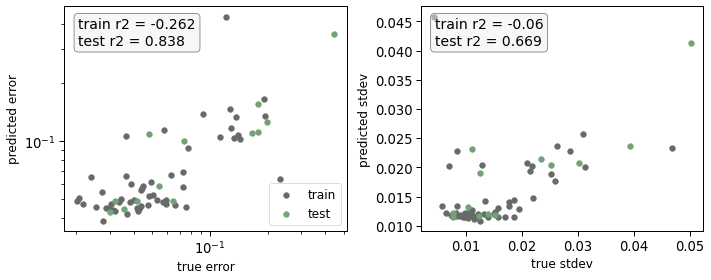

In [112]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))

# particle diameter distance from 300nm
ax0.scatter(train_values[:, 0], train_preds[:, 0], c='#666B6A', s=30, label='train')
ax0.scatter(test_values[:, 0], test_preds[:, 0], c='#72A276', s=30, label='test')

ax0.set_xscale('log')
ax0.set_yscale('log')

ax0.set_xlabel('true error', fontsize=12)
ax0.set_ylabel('predicted error', fontsize=12)

ax0.legend(loc='lower right', fontsize=12)

textstr = f'train r2 = {round(ps_train_r2, 3)}\ntest r2 = {round(ps_test_r2, 3)}'
props = dict(boxstyle='round', facecolor='#f0eff4', alpha=0.5)
ax0.text(
    0.05, 0.95, textstr, transform=ax0.transAxes, fontsize=14,
    verticalalignment='top', bbox=props,
)

# drug loading capacity
ax1.scatter(train_values[:, 1], train_preds[:, 1], c='#666B6A', s=30, label='train')
ax1.scatter(test_values[:, 1], test_preds[:, 1], c='#72A276', s=30, label='test')

ax1.set_xlabel('true stdev', fontsize=12)
ax1.set_ylabel('predicted stdev', fontsize=12)

textstr = f'train r2 = {round(dl_train_r2, 3)}\ntest r2 = {round(dl_test_r2, 3)}'
props = dict(boxstyle='round', facecolor='#f0eff4', alpha=0.5)
ax1.text(
    0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
    verticalalignment='top', bbox=props,
)

plt.tight_layout()